# Executive Summary

In keeping with the approach described in the [projectoverview.ipynb](projectoverview.ipynb), this notebook focus on the following: 

1. get to know the data well enough so that
2. various combinations of transformational preprocessing strategies can be applied to each feature in an "agile" way
3. this translates to encapsulating the details of all requirements, components, and flow for a given transformational strategy that can be readily applied by referencing some moniker or name identifying the composition as a whole
4. this "agile way" equates to a data-driven approach to the flow by virtue of reading the sequence of transformational strategies to apply from some configuration file (or even a string)

The end result is that different preprocessing approaches can be attempted without having to write an entirely new notebook for a new combination of strategies - all that is required is simply modifying the config file (with changes to which preprocessing strategies should be used) and then re-running the [preprocessing.ipynb](preprocessing.ipynb).

So, the major output of this notebook is:

1. the development of python classes that encapsulate all of the various preprocessing strategies (called `StrategyTransformer`s) we might want to use in the preprocessing phase (driven by a config file referring to those classes)
2. the set of applicable `StrategyTransformer`s that can be applied to a given feature based on in-depth feature analysis

That being said, this notebook does not do any preprocessing to produce transformed data sets to use for modeling.  Again, that work is done in the [preprocessing.ipynb](preprocessing.ipynb).

Therefore, <b>it is not recommended to re-run THIS notebook (as it takes a long time) <i>unless you want to see the examples/analysis used to develop those strategies running</i></b>.

# Import Libraries

In [1]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

import json
from json_minify import json_minify

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.strategy_transformers as scjpnstrattransformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import DropColumnsTransformer, LambdaTransformer, SimpleValueTransformer, OneHotEncodingTransformer, LabelEncodingTransformer, TargetEncoderLOOTransformer
from sklearn.preprocessing import FunctionTransformer

%load_ext autoreload
%autoreload 2

# Load/Read Config

The following reads properties from the `eda-config.txt` file as JSON.  (see the `eda-config.txt` file for documentation on config parameters)

In [2]:
fm = FileManager()
eda_config = fm.load_json('eda-config.txt')

# Obtain the Data: Labels, Labeled Predictors, and Unlabeled Predictors

In [3]:
fname_unlabeled_predictors = eda_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = eda_config['official_data']['labeled_predictors']['local_fname']
fname_labels = eda_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: eda_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: eda_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: eda_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

# Explore the Data

Before we get into our analysis, let's initialize some objects/variables that will be used throughout.

One thing to note: in keeping with the Approach outline above, we will be building the preprocessing `Pipeline` as we go.  

So let's take care of these initialization details now.

In [4]:
SEED = eda_config['SEED'] # for random_state reproducability

In [5]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

labeled_with_target

amount_tsh date_recorded             funder  gps_height     installer  \
id                                                                             
0             0.0    2012-11-13              Tasaf           0         TASAF   
1             0.0    2011-03-05              Shipo        1978         SHIPO   
2             0.0    2011-03-27               Lvia           0          LVIA   
3            10.0    2013-06-03    Germany Republi        1639           CES   
4             0.0    2011-03-22               Cmsr           0          CMSR   
...           ...           ...                ...         ...           ...   
74240         0.0    2013-03-22       World Vision        1183  World vision   
74242         0.0    2011-04-12             Danida           0        DANIDA   
74243         0.0    2012-11-13  Ministry Of Water        1188        Hesawa   
74246        50.0    2011-03-07              Ruthe        1428         Ruthe   
74247        50.0    2013-02-16            Mission         965           DWE   

       longitude   latitude               wpt_name  num_private  \
id                                                                
0      33.125828  -5.118154                Mratibu            0   
1      34.770717  -9.395642                   none            0   
2      36.115056  -6.279268                Bombani            0   
3      37.147432  -3.187555         Area 7 Namba 5            0   
4      36.164893  -6.099289                Ezeleda            0   
...          ...        ...                    ...          ...   
74240  37.007726  -3.280868  Upendo Primary School            0   
74242  33.724987  -8.940758            Kwa Mvulula            0   
74243  33.963539  -1.429477      Kwa Wambura Msege            0   
74246  35.630481  -7.710549                   none            0   
74247  35.432998 -10.639270            Kwa Mapunda            0   

                         basin  ... water_quality quality_group      quantity  \
id                              ...                                             
0              Lake Tanganyika  ...         milky         milky        enough   
1                       Rufiji  ...          soft          good        enough   
2                  Wami / Ruvu  ...          soft          good  insufficient   
3                      Pangani  ...          soft          good        enough   
4                  Wami / Ruvu  ...          soft          good           dry   
...                        ...  ...           ...           ...           ...   
74240                  Pangani  ...          soft          good  insufficient   
74242                   Rufiji  ...          soft          good        enough   
74243            Lake Victoria  ...          soft          good        enough   
74246                   Rufiji  ...          soft          good           dry   
74247  Ruvuma / Southern Coast  ...          soft          good           dry   

       quantity_group                source           source_type  \
id                                                                  
0              enough          shallow well          shallow well   
1              enough          shallow well          shallow well   
2        insufficient           machine dbh              borehole   
3              enough                spring                spring   
4                 dry          shallow well          shallow well   
...               ...                   ...                   ...   
74240    insufficient  rainwater harvesting  rainwater harvesting   
74242          enough                 river            river/lake   
74243          enough                  lake            river/lake   
74246             dry                spring                spring   
74247             dry                 river            river/lake   

       source_class              waterpoint_type waterpoint_type_group  \
id                                                                  

So, since we have 59400 rows after the join, all rows of predictors match up to a label, based on <b>id</b>.

## Labels

In [6]:
labels = labeled_with_target[['status_group']]
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 74247
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  59400 non-null  object
dtypes: object(1)
memory usage: 928.1+ KB


In [7]:
labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [8]:
labels.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [9]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)
labels_encoded.status_group.unique()

array([2, 0, 1])

In [10]:
classes = list(let_labels.labelencoder.classes_)
classes

['functional', 'functional needs repair', 'non functional']

In [11]:
labels_encoded.status_group.value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [12]:
labels_encoded.status_group.value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
Name: status_group, dtype: float64

In [13]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

## Predictors

In [14]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [15]:
# check to see if there is any target leakage into unlabeled based on id
check_unlabeled_leakage = pd.concat([X_unlabeled, labeled_with_target[['status_group']]], axis=1, join='inner')
check_unlabeled_leakage

Empty DataFrame
Columns: [amount_tsh, date_recorded, funder, gps_height, installer, longitude, latitude, wpt_name, num_private, basin, subvillage, region, region_code, district_code, lga, ward, population, public_meeting, recorded_by, scheme_management, scheme_name, permit, construction_year, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group, status_group]
Index: []

[0 rows x 40 columns]

No inadvertant target leakage into unlabeled predictors.

### Labeled (Predictors)

Here, before we get into more detailed analysis, let's consider the descriptions (retrieved from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list) of the predictors/features:


- **amount_tsh** - Total static head (amount water available to waterpoint)
- **date_recorded** - The date the row was entered
- **funder** - Who funded the well
- **gps_height** - Altitude of the well
- **installer** - Organization that installed the well
- **longitude** - GPS coordinate
- **latitude** - GPS coordinate
- **wpt_name** - Name of the waterpoint if there is one
- **num_private** -
- **basin** - Geographic water basin
- **subvillage** - Geographic location
- **region** - Geographic location
- **region_code** - Geographic location (coded)
- **district_code** - Geographic location (coded)
- **lga** - Geographic location
- **ward** - Geographic location
- **population** - Population around the well
- **public_meeting** - True/False
- **recorded_by** - Group entering this row of data
- **scheme_management** - Who operates the waterpoint
- **scheme_name** - Who operates the waterpoint
- **permit** - If the waterpoint is permitted
- **construction_year** - Year the waterpoint was constructed
- **extraction_type** - The kind of extraction the waterpoint uses
- **extraction_type_group** - The kind of extraction the waterpoint uses
- **extraction_type_class** - The kind of extraction the waterpoint uses
- **management** - How the waterpoint is managed
- **management_group** - How the waterpoint is managed
- **payment** - What the water costs
- **payment_type** - What the water costs
- **water_quality** - The quality of the water
- **quality_group** - The quality of the water
- **quantity** - The quantity of water
- **quantity_group** - The quantity of water
- **source** - The source of the water
- **source_type** - The source of the water
- **source_class** - The source of the water
- **waterpoint_type** - The kind of waterpoint
- **waterpoint_type_group** - The kind of waterpoint

Based on the descriptions and names alone, it appears that there is some duplication of data (which is perhaps represented differently).

Let's have a high-level look at the features.

In [16]:
scjpnutils.analyze_values(X_labeled, 'X_labeled');

The first things to notice are:

1. Most predictors appear to be objects (strings) and those are likely categorical.
2. Some predictors have null/missing values.

Before moving on, let's split the labeled data into corresponding test/validation (train) partitions.

In [17]:
eda_config['test_ratio']

0.1

In [18]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=eda_config['test_ratio'], random_state=SEED)

In [19]:
X_train.index

Int64Index([56146, 38945, 11841,  1186, 36420, 57631, 14207, 51349, 57940,
            49053,
            ...
            21005,  7817, 68674, 14096, 55895, 67998, 47669,  1071, 19703,
            70556],
           dtype='int64', name='id', length=53460)

In [20]:
y_train.index

Int64Index([56146, 38945, 11841,  1186, 36420, 57631, 14207, 51349, 57940,
            49053,
            ...
            21005,  7817, 68674, 14096, 55895, 67998, 47669,  1071, 19703,
            70556],
           dtype='int64', name='id', length=53460)

In [21]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [22]:
y_train_encoded.index

Int64Index([56146, 38945, 11841,  1186, 36420, 57631, 14207, 51349, 57940,
            49053,
            ...
            21005,  7817, 68674, 14096, 55895, 67998, 47669,  1071, 19703,
            70556],
           dtype='int64', name='id', length=53460)

In [23]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 0 to 74247
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             53460 non-null  float64
 1   date_recorded          53460 non-null  object 
 2   funder                 50191 non-null  object 
 3   gps_height             53460 non-null  int64  
 4   installer              50173 non-null  object 
 5   longitude              53460 non-null  float64
 6   latitude               53460 non-null  float64
 7   wpt_name               53460 non-null  object 
 8   num_private            53460 non-null  int64  
 9   basin                  53460 non-null  object 
 10  subvillage             53125 non-null  object 
 11  region                 53460 non-null  object 
 12  region_code            53460 non-null  int64  
 13  district_code          53460 non-null  int64  
 14  lga                    53460 non-null  object 
 15  wa

In [24]:
X_validation.index

Int64Index([ 3746,  6544, 28265, 49830, 16680,  6871, 61612, 29110,    66,
            28672,
            ...
            69201,  6205, 21747, 26212, 17364, 36183, 60526, 73729, 17620,
            32518],
           dtype='int64', name='id', length=5940)

In [25]:
y_validation.index

Int64Index([ 3746,  6544, 28265, 49830, 16680,  6871, 61612, 29110,    66,
            28672,
            ...
            69201,  6205, 21747, 26212, 17364, 36183, 60526, 73729, 17620,
            32518],
           dtype='int64', name='id', length=5940)

In [26]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [27]:
y_validation_encoded.index

Int64Index([ 3746,  6544, 28265, 49830, 16680,  6871, 61612, 29110,    66,
            28672,
            ...
            69201,  6205, 21747, 26212, 17364, 36183, 60526, 73729, 17620,
            32518],
           dtype='int64', name='id', length=5940)

In [28]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']
data_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5940 entries, 4 to 74229
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             5940 non-null   float64
 1   date_recorded          5940 non-null   object 
 2   funder                 5574 non-null   object 
 3   gps_height             5940 non-null   int64  
 4   installer              5572 non-null   object 
 5   longitude              5940 non-null   float64
 6   latitude               5940 non-null   float64
 7   wpt_name               5940 non-null   object 
 8   num_private            5940 non-null   int64  
 9   basin                  5940 non-null   object 
 10  subvillage             5904 non-null   object 
 11  region                 5940 non-null   object 
 12  region_code            5940 non-null   int64  
 13  district_code          5940 non-null   int64  
 14  lga                    5940 non-null   object 
 15  war

We can now dive deep into analysis.  Going forward, all analysis will be executed strictly upon the training predictors and then those results will be similarly applied to both validation predictors and also unlabeled predictors.

<p><br><br><br>
Let's examine our predictors in more detail.  There are a number of ways to look at these predictors.

Since, from a high-level, based on their descriptions, various predictors can be grouped together by the *kind* of content (data) they contain.

For example, we see that features **extraction_type**, **extraction_type_group**, and **extraction_type_class** all have the same description:

   "The kind of extraction the waterpoint uses".

So, our first angle of attack will be to group features accordingly.  What we are doing here is effectively ad-hoc classification of the "meta-data" (kind) of features.

In [29]:
feat_groupings = eda_config['feature_groupings']
scjpnutils.display_pretty_feature_groupings(feat_groupings)

# Detailed Analysis, Organized by <i>kind</i> of Predictor (as given above)

## Predictors <i>Kind</i> TOC

<ol>
    <li><a href="#amount_tsh">amount_tsh</a></li>
    <li><a href="#pump_age_at_observation_date">pump_age_at_observation_date</a></li>
    <li><a href="#funder">funder</a></li>
    <li><a href="#gps_height">gps_height</a></li>
    <li><a href="#installer">installer</a></li>
    <li><a href="#gps_coordinates">gps_coordinates</a></li>
    <li><a href="#wpt_name">wpt_name</a></li>
    <li><a href="#num_private">num_private</a></li>
    <li><a href="#basin">basin</a></li>
    <li><a href="#geographic_location_coded">geographic_location_coded</a></li>
    <li><a href="#geographic_location">geographic_location</a></li>
    <li><a href="#population">population</a></li>
    <li><a href="#public_meeting">public_meeting</a></li>
    <li><a href="#recorded_by">recorded_by</a></li>
    <li><a href="#wpt_operator">wpt_operator</a></li>
    <li><a href="#permit">permit</a></li>
    <li><a href="#wpt_extraction_type_class">wpt_extraction_type_class</a></li>
    <li><a href="#wpt_management">wpt_management</a></li>
    <li><a href="#payment_frequency_class">payment_frequency_class</a></li>
    <li><a href="#water_quality_class">water_quality_class</a></li>
    <li><a href="#water_quantity_class">water_quantity_class</a></li>
    <li><a href="#water_source_type_class">water_source_type_class</a></li>
    <li><a href="#wpt_type_class">wpt_type_class</a></li>
</ol>

We now move on to analyze each feature grouping (in the config).

In [30]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'amount_tsh', X_train, 'X_train')

#### Feature Analysis: *amount_tsh*

It has no null/missing values.  Great.

Having a miniscule ratio of values, <b>amount_tsh</b> is likely categorical-ordinal.

Let's have a look at its value counts.

In [31]:
X_train.amount_tsh.value_counts()

0.0         37461
500.0        2815
50.0         2215
1000.0       1342
20.0         1321
            ...  
8500.0          1
6300.0          1
11000.0         1
120000.0        1
220.0           1
Name: amount_tsh, Length: 96, dtype: int64

<b>amount_tsh</b> appears to be dominated by the value zero.

Let's have a more detailed look.

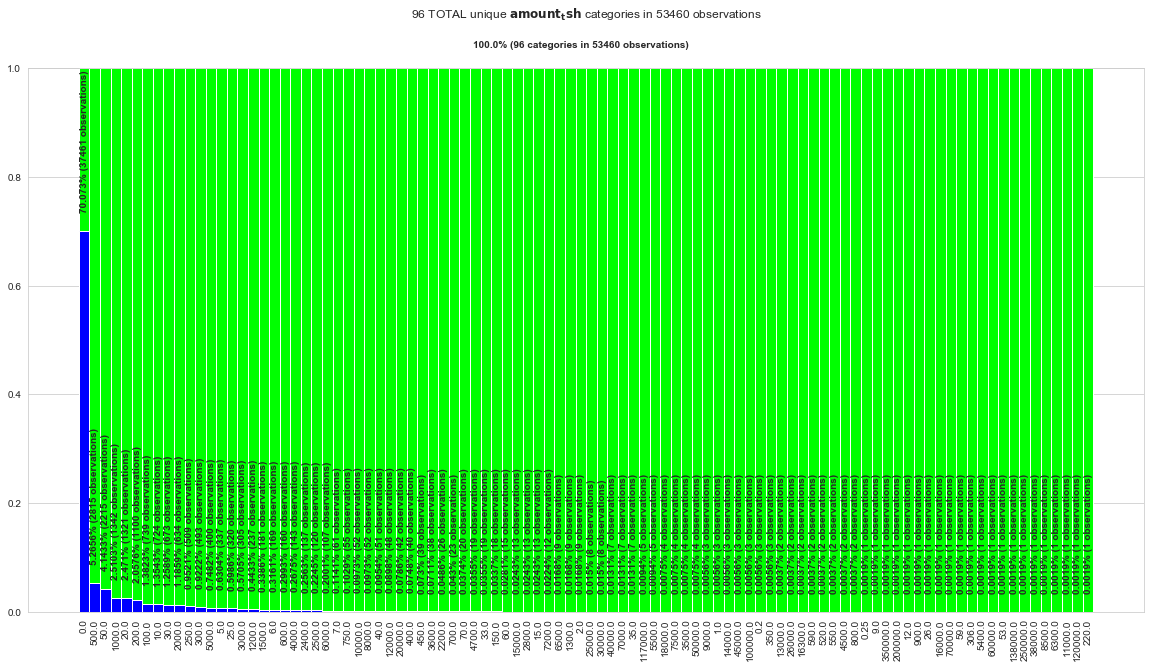

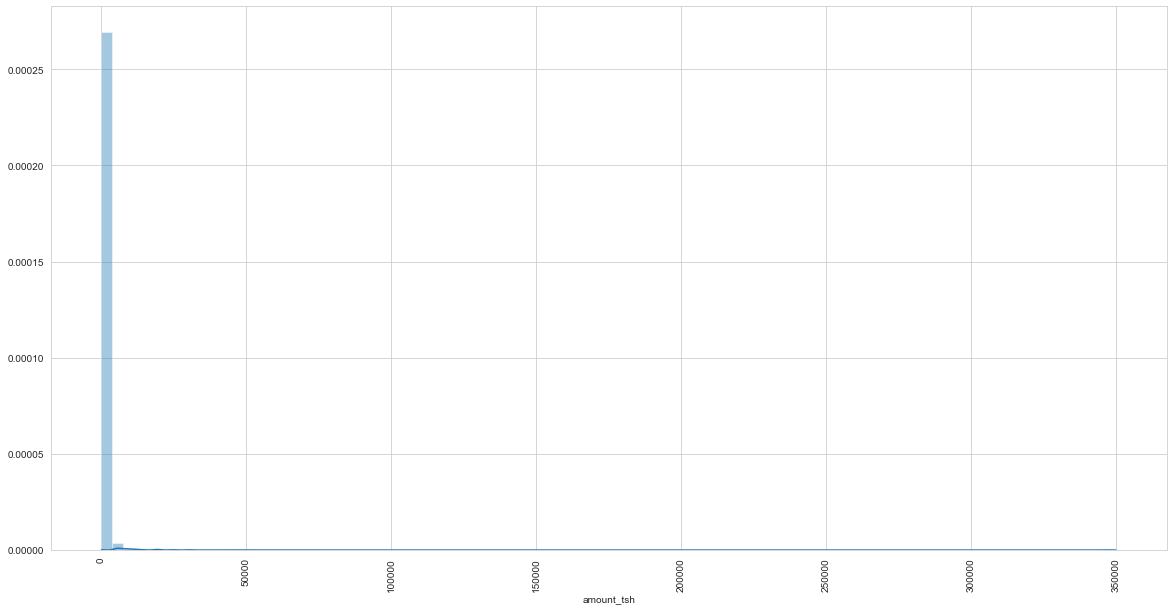

In [32]:
scjpnutils.analyze_distributions(X_train, 'X_train', 'amount_tsh');

Now let's consider the possibility that <b>amount_tsh</b> is continuous and then let's look at its outliers.

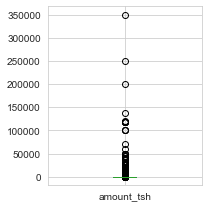

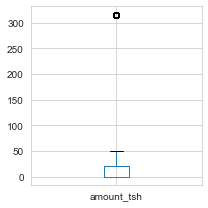

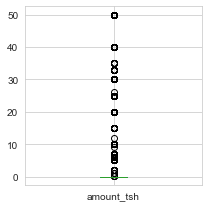

In [33]:
scjpnutils.analyze_outliers_detailed(
    X_train, 
    'X_train', 
    'amount_tsh', 
    top_percentile=100, 
    outlier_ratio_reduction_threshold=.10
);

Let's consider grouping **amount_tsh** by target class.

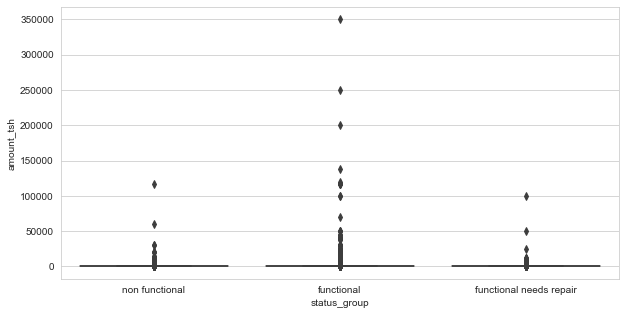

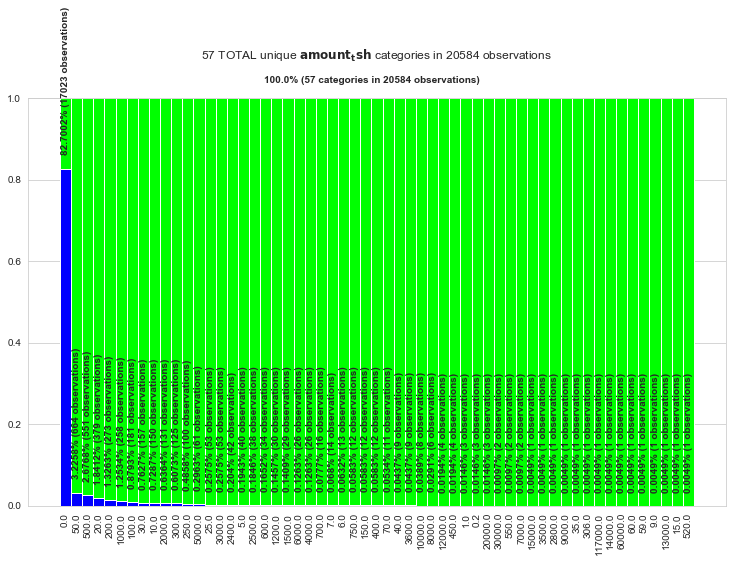

/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


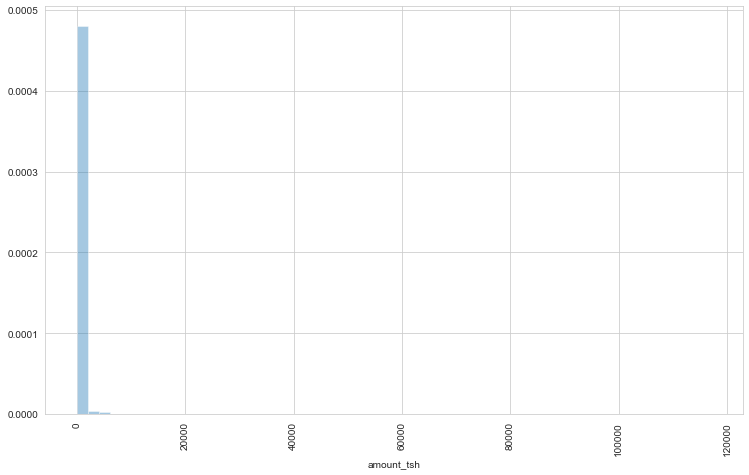

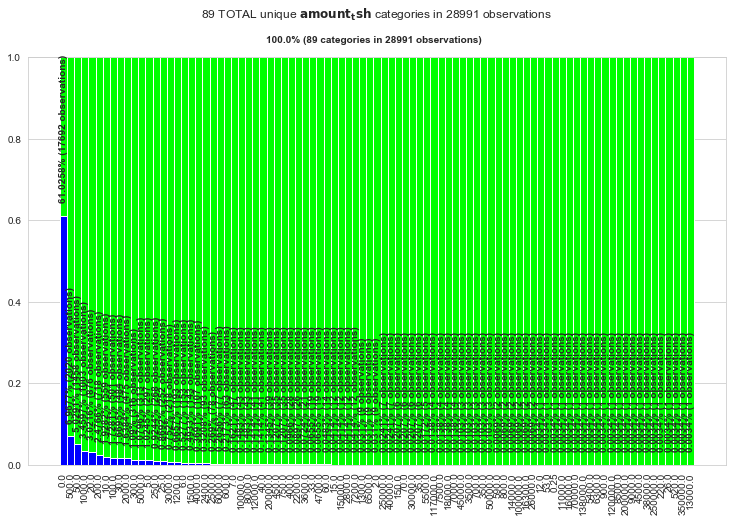

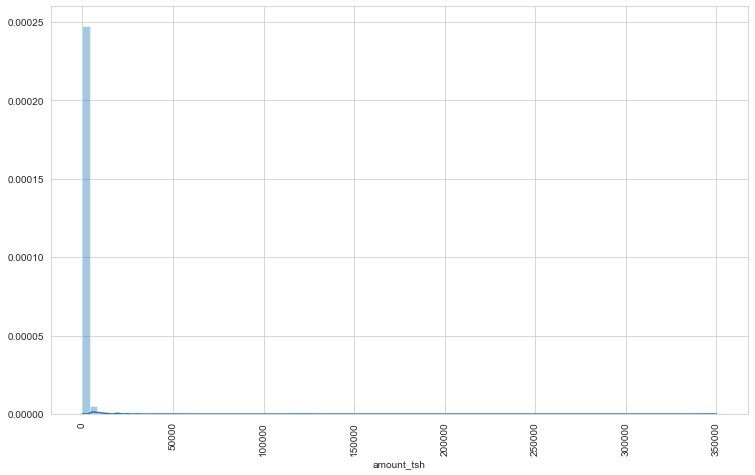

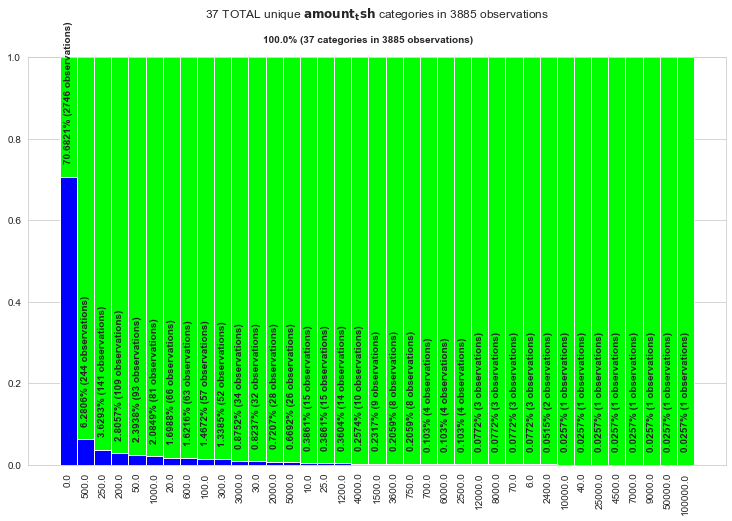

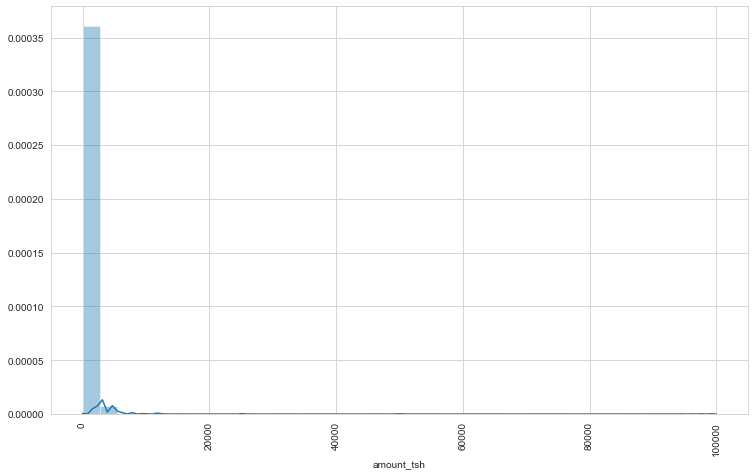

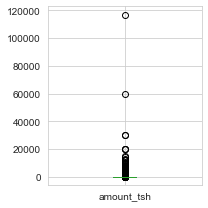

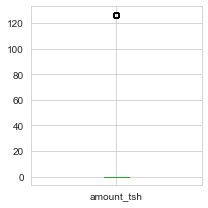

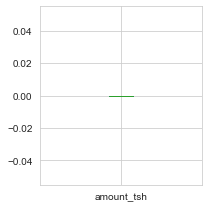

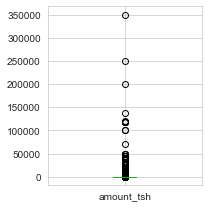

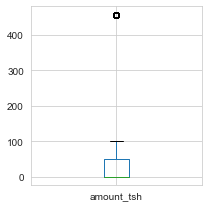

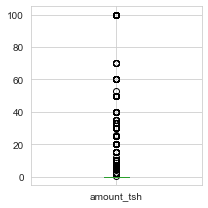

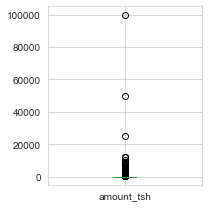

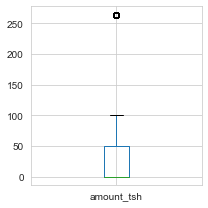

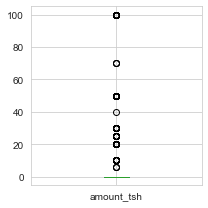

In [34]:
scjpnutils.analyze_distributions_grouped_by(data_train, 'amount_tsh', 'status_group', fs=(12.5,7.5))
scjpnutils.analyze_outliers_grouped_by(data_train, 'amount_tsh', 'status_group', suppress_header=True)

Observations:

0. From the feature description, "Total static head (amount water available to waterpoint)", this seems like a fairly important feature and intuituively seems unwise to drop it.
1. Whether categorical (ordinal) or continuous, <b>amount_tsh</b> has many outlier values.
2. More than 70% of the observations (in train) have <b>amount_tsh</b> value 0, which would explain why traditional outlier-imputation semantics (mean/median/mode) won't do much to improve the situation; the distributions and outlier patterns don't change much when grouping by target class

From a high-level, it seems that the best approach to handle this feature for modeling is to drop it.


<p><br><br>
Nevertheless, the following possible methods for handling this feature are considered.

1. Leave the feature as is (do nothing, no transformations whatsoever)
2. Target-encode it - this feature *appears* to be categorical (but ordinal); since, if categorical, it is ordinal, we might consider that the size between values is not properly mathematically meaningful; if this is the case, target encoding could help this in modeling
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set) - in this case, `nan` values occur (after target encoding is applied) in the validation and unlabeled transformed data sets when categories not seen in training are observed; thus a mapping from training is not possible; a `nan` value therefore would exclude the observation when modeling; mapping to the global mean counters this
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values are left as is - i.e. NOT mapped to the global mean of the fit target (from the training set); note that this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    4. (Leave-One-Out) target encoding with `nan` values left as is; again, this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
3. Replace 0-values with `nan` so that the feature is effectively ignored in the model for would-be 0-values - this technique is employed if we treat the feature as purely continuous, in an effort to deal with the lopsided distribution toward 0; the effect is for the model to consider only non-zero values as relevant in modeling; again, this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
4.Drop the feature - again, if we consider the feature as continuous, this is another way of handling it; analysis suggests this is the way to go

<p><br><br>
Let's inspect the methodology (and code) for each approach, by starting with the easiest ones first: "Leave the feature as is" and "Drop the feature".

<p><br><br>

### Strategy Development: *Leave the Feature As Is*

#### Concept

First, leaving the feature as is is self-explanatory.

Our high-level approach is to seek out and encapsulate patterned strategies so that the transformations they are composed of can be applied to a variable feature and this strategy can be persisted.  The end goal is to be able to capture different strategic approaches within a config file.  This makes trying different approaches simple without the need to build an entirely new Jupyter notebook for each different combination of strategies - when we want to try a different transformation for a given feature and then build a model based on that, we simply alter the config file and rerun the [preprocessing.ipynb](preprocessing.ipynb) notebook.

But this means we need to capture all of the above approaches within code.  For this, we employ the well-known `Strategy` design pattern to create `StrategyTransformer` classes to capture each approach above.

So, we'll start by developing the idea constituting the first one: `C__leave_it_as_is__StrategyTransformer`.

#### Implementation Details of `StrategyTransformer` class: `C__leave_it_as_is__StrategyTransformer`

This class simply wraps an sklearn `FunctionTransformer` that does nothing to the dataframe passed to it.

In [35]:
ft_leave_it_as_is = FunctionTransformer(lambda X: X, validate=False)

In [36]:
X_train_amount_tsh_after_leave_it_as_is_transformation = ft_leave_it_as_is.fit_transform(X_train[['amount_tsh']])

scjpnutils.analyze_values(
    X_train_amount_tsh_after_leave_it_as_is_transformation, 
    'X_train_amount_tsh_after_leave_it_as_is_transformation', 
    standard_options_kargs={'sort_unique_vals':True}
);

As you can see, the high-level summary provided by `analyze_values` indicates no changes to the resulting dataframe from the original (`X_train`).

Now let's use the `C__leave_it_as_is__StrategyTransformer` class that wraps the above functionality.

In [37]:
amount_tsh_strat_transformer = scjpnstrattransformers.C__leave_it_as_is__StrategyTransformer(
    'amount_tsh', 
    pipeline_data_preprocessor=None, 
    verbose=True
)
X_train_amount_tsh_after_leave_it_as_is_transformation_2 = amount_tsh_strat_transformer.fit_transform(X_train[['amount_tsh']])

scjpnutils.analyze_values(
    X_train_amount_tsh_after_leave_it_as_is_transformation_2, 
    'X_train_amount_tsh_after_leave_it_as_is_transformation', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "leave feature as is (do nothing): amount_tsh" transformation is COMPLETE!


So what's the difference?  The first thing is that `StrategyTransformer` objects all have the capability to update an sklearn `Pipeline` being used in the project and that is exactly what we do.  Why?  Because we want to *cleanly* apply all of the same transformations that we did to the training set later to the validation/test set (without having to write a bunch of code in order to do so).

The biggest difference is that we can store which strategy should be used for a given feature inside of a config file (as strings) and then apply it by using the function, `instantiate_strategy_transformer`.

For example, after many iterations, suppose we find that the best strategy is in fact to leave **amount_tsh** as is.  

This would be represented in the config as:

<pre>
["amount_tsh", "C__drop_it__StrategyTransformer"]
</pre>

So let's emulate this in code.  The config is stored as `JSON` so we have to emulate a document stored in that format.

In [38]:
s_cfg__amount_tsh = '''
    {
        "feature_groupings": {
            "amount_tsh": {
                "preprocessing_strategy": [
                    ["amount_tsh", "C__leave_it_as_is__StrategyTransformer"]
                ]
            }
        }
    }
'''
feat_groupings_cfg = json.loads(json_minify(s_cfg__amount_tsh))

amount_tsh_strat_transformer_from_fake_cfg_file = scjpnstrattransformers.instantiate_strategy_transformer(
    feat_groupings_cfg['feature_groupings']['amount_tsh']['preprocessing_strategy'], 
    'amount_tsh',
    pipeline=None
)

X_train_amount_tsh_after_leave_it_as_is_transformation_3 = amount_tsh_strat_transformer_from_fake_cfg_file.fit_transform(X_train[['amount_tsh']])

scjpnutils.analyze_values(
    X_train_amount_tsh_after_leave_it_as_is_transformation_3, 
    'X_train_amount_tsh_after_leave_it_as_is_transformation_3', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "leave feature as is (do nothing): amount_tsh" transformation is COMPLETE!


Obviously the two approaches - talking about the very first, using `ft_leave_it_as_is` (coded in a cell) vs. the above -  are indentical but one is defined within a cell and one within a config file. 

To see the power in this, we first need another building block to encapsulate the "Drop the feature" strategy.

### Strategy Development: *Drop the Feature*

#### Concept

The strategy itself requires no explanation as it is self-explanatory.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__drop_it__StrategyTransformer`

This class simply wraps the `DropColumnsTransformer` found within `skl_transformers.py`.

In [39]:
dct_drop_amount_tsh = DropColumnsTransformer(['amount_tsh'])
X_train__after_dropping_amount_tsh = dct_drop_amount_tsh.fit_transform(X_train)
X_train__after_dropping_amount_tsh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          53460 non-null  object 
 1   funder                 50191 non-null  object 
 2   gps_height             53460 non-null  int64  
 3   installer              50173 non-null  object 
 4   longitude              53460 non-null  float64
 5   latitude               53460 non-null  float64
 6   wpt_name               53460 non-null  object 
 7   num_private            53460 non-null  int64  
 8   basin                  53460 non-null  object 
 9   subvillage             53125 non-null  object 
 10  region                 53460 non-null  object 
 11  region_code            53460 non-null  int64  
 12  district_code          53460 non-null  int64  
 13  lga                    53460 non-null  object 
 14  ward                   53460 non-null  object 
 15

In [40]:
amount_tsh_strat_transformer = scjpnstrattransformers.C__drop_it__StrategyTransformer(
    'amount_tsh', 
    pipeline_data_preprocessor=None, 
    verbose=True
)
X_train__after_dropping_amount_tsh_2 = amount_tsh_strat_transformer.fit_transform(X_train)
X_train__after_dropping_amount_tsh_2.info()

strategy "drop feature: amount_tsh" transformation is COMPLETE!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          53460 non-null  object 
 1   funder                 50191 non-null  object 
 2   gps_height             53460 non-null  int64  
 3   installer              50173 non-null  object 
 4   longitude              53460 non-null  float64
 5   latitude               53460 non-null  float64
 6   wpt_name               53460 non-null  object 
 7   num_private            53460 non-null  int64  
 8   basin                  53460 non-null  object 
 9   subvillage             53125 non-null  object 
 10  region                 53460 non-null  object 
 11  region_code            53460 non-null  int64  
 12  district_code          53460 non-null  int64  
 13  lga                    53460 non-null 

Now we can continue on with illustrating the power in setting this inside of a configuration file.

So far we have seen how to instantiate and executate a strategy transformation that was stored within a configuration file.

Now we want to emulate how easy it ease to retarget a given transformation by simply changing the config file.

In [41]:
def demo_emulate_strat_transformation_via_config(feature_groupings_cfg, group_id, feat, X, y_train_encoded=None):
    feat_strat_transformer_from_fake_cfg_file = scjpnstrattransformers.instantiate_strategy_transformer(
        feature_groupings_cfg['feature_groupings'][group_id]['preprocessing_strategy'], 
        feat,
        pipeline=None
    )
    return feat_strat_transformer_from_fake_cfg_file.fit_transform(X, y_train_encoded)

In [42]:
# emulate C__leave_it_as_is__StrategyTransformer in config file
s_cfg__amount_tsh = '''
    {
        "feature_groupings": {
            "a_related_feat_group_containing_amount_tsh": {
                "preprocessing_strategy": [
                    ["amount_tsh", "C__leave_it_as_is__StrategyTransformer"]
                ]
            }
        }
    }
'''
feat_groupings_cfg = json.loads(json_minify(s_cfg__amount_tsh)) # emulates loading this config from a file

X_train_amount_tsh_after_strat_trans = demo_emulate_strat_transformation_via_config(feat_groupings_cfg, 'a_related_feat_group_containing_amount_tsh', 'amount_tsh', X_train)
X_train_amount_tsh_after_strat_trans.info()

strategy "leave feature as is (do nothing): amount_tsh" transformation is COMPLETE!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             53460 non-null  float64
 1   date_recorded          53460 non-null  object 
 2   funder                 50191 non-null  object 
 3   gps_height             53460 non-null  int64  
 4   installer              50173 non-null  object 
 5   longitude              53460 non-null  float64
 6   latitude               53460 non-null  float64
 7   wpt_name               53460 non-null  object 
 8   num_private            53460 non-null  int64  
 9   basin                  53460 non-null  object 
 10  subvillage             53125 non-null  object 
 11  region                 53460 non-null  object 
 12  region_code            53460 non-null  int64  
 13  district_code     

In [43]:
# emulate changing to C__drop_it__StrategyTransformer in config file
s_cfg__amount_tsh = '''
    {
        "feature_groupings": {
            "a_related_feat_group_containing_amount_tsh": {
                "preprocessing_strategy": [
                    ["amount_tsh", "C__drop_it__StrategyTransformer"]
                ]
            }
        }
    }
'''
feat_groupings_cfg = json.loads(json_minify(s_cfg__amount_tsh)) # emulates loading this config from a file

X_train_amount_tsh_after_strat_trans_2 = demo_emulate_strat_transformation_via_config(feat_groupings_cfg, 'a_related_feat_group_containing_amount_tsh', 'amount_tsh', X_train)
X_train_amount_tsh_after_strat_trans_2.info()

strategy "drop feature: amount_tsh" transformation is COMPLETE!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          53460 non-null  object 
 1   funder                 50191 non-null  object 
 2   gps_height             53460 non-null  int64  
 3   installer              50173 non-null  object 
 4   longitude              53460 non-null  float64
 5   latitude               53460 non-null  float64
 6   wpt_name               53460 non-null  object 
 7   num_private            53460 non-null  int64  
 8   basin                  53460 non-null  object 
 9   subvillage             53125 non-null  object 
 10  region                 53460 non-null  object 
 11  region_code            53460 non-null  int64  
 12  district_code          53460 non-null  int64  
 13  lga                    53460 non-null 

<p><br>

### Strategy Development: *Target Encoding*

#### Concept

First we require a little background discussion.

*Target Encoding* is used for *high-cardinality* categorical features.

Normally we opt to *One-Hot* encode our categorical features.  But, as cardinality increases, of course more columns are added with One-Hot encoding transformation.  Looking at the summary above, we see that there are many unique values - treating **amount_tsh** as a categorical variable.  

This makes One-Hot encoding undesirable as it will negatively impact our training performance in model building, especially if we wish to employ `GridSearch` in order to tune hyper-parameters for our models.  

Additionally and perhaps more importantly, it has been documented that One-Hot encoding high-cardinality features can degrade accuracy (relative to Target Encoding) for tree-based classifiers. (see the article [One-Hot Encoding is making your Tree-Based Ensembles worse, here’s why?](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769))

But how does Target Encoding solve the problem encountered in One-Hot encoding high-cardinality categorical variables?  Without redeveloping the entire theory behind it, I will summarize it like this.  In short, Target Encoding (from a VERY HIGH LEVEL) is:

1. for each category, compute the number of observations of each target class
2. divide that by the total number of observations of that category

This is done for the training data set.  For the test/validation set, the target encoded values are mapped from those computed on the training data set.

This means that if there is a category in test/validation not seen when applying the above to the training data set, a null (`nan`) value will occur since there is no corresponding mapping available.  There are two approaches to take when this happens:

1. encode these values as the global mean of the target
2. leave those `nan` values as is

Both approaches can be useful.  In the former, we have encoded the representation of `nan` as a `float` (the global mean), which means classifiers unable to handle `nan` values can be used.  In the latter, only the non-`nan` values will be modeled for potentially better accuracy but this precludes the use of classifiers unable to handle `nan` values such as `DecisionTreeClassifier` and `RandomForestClassifier`.  (By the way, the three classifier types we consider when model building are `DecisionTreeClassifier`, `RandomForestClassifier`, and `XGBClassifier`)

Finally - and here is the crux - **Target Encoding retains the single dimension of the original categorical variable - i.e. with Target Encoding, if we have $m$ unique categories, we avoid adding $m-1$ columns to the data set that we would have by using One-Hot Encoding instead**.  This GREATLY improves performance relative to One-Hot encoding but, more importantly, for high-cardinality categoricals, we should also a see a "significant" boost to accuracy (according to the article).  By the way, I can attest to this fact - initially I attempted to use One-Hot Encoding approach - since, not only did it take hours and hours to build the models, but accuracy was a lot worse!

We will see that we have A LOT of high-cardinality categorical features in this data set.  So, in keeping with the above, that rules out the use of One-Hot encoding and justifies the use of Target Encoding.

**But by using Target Encoding, we effectively engineer a new feature: the target-encoded version (`float`) of the original categorical variable (may be `string` or numeric/ordinal).  This means that whenever we Target Encode a categorical, we must drop the original.  So, in effect, the new Target-Encoded version of the feature should replace the original.**

We present some code to capture the above, encapsulated in the following four classes: 

1. `C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer`
2. `C__target_encode__not_LOO__not_post_encode_null_to_global_mean__StrategyTransformer`
3. `C__target_encode__LOO__post_encode_null_to_global_mean__StrategyTransformer`
4. `C__target_encode__LOO__not_post_encode_null_to_global_mean__StrategyTransformer`

The above four classes are specialized derivations of the base class, `C__target_encode__StrategyTransformer`.  Each derived class differs by whether Leave-One-Out Target Encoding is used or not as well as how `nan` values (categories not seen when fit) are handled in the validation set.

#### Implementation Details of `StrategyTransformer` class: `C__target_encode__StrategyTransformer` (base class)

At its core, this class wraps the `TargetEncoderLOOTransformer` class found within `skl_transformers.py`.

Fitting a train set using this transformer has been simplified via the `fit_target_encoder` function within that same python file.

In [44]:
scjpnutils.display_sourcecode(scjpnskltransformers.fit_target_encoder)

I forgot to mention that **the target must first be label-encoded** for this.

In [45]:
target_encoder__amount_tsh = scjpnskltransformers.fit_target_encoder(
    feat='amount_tsh', 
    X=X_train, 
    y_target_label_encoded=y_train_encoded.status_group, 
    post_encode_null_to_global_mean=True
)

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X


Now, let's use this to transform `X_train` first.

In [46]:
X_train__amount_tsh_target_encoded = target_encoder__amount_tsh.transform(X_train)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit


Because we did not supply `y_train_encoded.status_group` via `target_encoder__funder.transform(X_train, y_train_encoded.status_group)`, we are NOT using Leave-One-Out.  On the other hand, if we do...

In [47]:
X_train__amount_tsh_target_encoded = target_encoder__amount_tsh.transform(X_train, y_train_encoded.status_group)

** TargetEncoderLOOTransformer TRANSFORM INFO **: using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 22 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816


Leave-one-out basically implements computations using stratified k-folds to ensure absolutely no target leakage.  The drawback is some loss of information.  Also note that, because we set `post_encode_null_to_global_mean=True` for the fit, `nan` values have been mapped to the global mean (loss of information but not null).

In [48]:
scjpnutils.analyze_values(
    X_train__amount_tsh_target_encoded[['amount_tsh']], 
    'X_train__amount_tsh_target_encoded <i>amount_tsh</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

There are a couple of things to note here.  First, the `unique_vals` column clearly shows some of the new (target) encodings.  Secondly, `TargetEncoderLOOTransformer` implicitly replaces the original categorical column (values and of course data type) with the target-encoded version.

In our case, we want to explicitly see that this feature has been target encoded in our data set.  So we use the following wrapper whenever we want a Target-Encoded transformation.

In [49]:
scjpnutils.display_sourcecode(scjpnskltransformers.target_encoder_transform)

In [50]:
X_train__amount_tsh_target_encoded = scjpnskltransformers.target_encoder_transform(
    target_encoder=target_encoder__amount_tsh, 
    feat='amount_tsh', 
    X=X_train, 
    y_target_label_encoded=None # for this example, we don't LOO target encode
)

scjpnutils.analyze_values(
    X_train__amount_tsh_target_encoded[['amount_tsh', 'amount_tsh_target_encoded']], 
    'X_train__amount_tsh_target_encoded <i>amount_tsh</i> and <i>amount_target_encoded</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded


But now when we execute the strategy encapsulating all of this, we want to drop the original feature since we now have the new target-encoded version (appropriately named).  Similar to the `C__drop_it__StrategyTransformer` strategy transformer, `C__target_encode__StrategyTransformer` uses `DropColumnsTransformer` to accomplish this, but AFTER target encoding is complete (and the new target encoded feature has been added to the transformed data set).

All of the above processing has been wrapped within the `C__target_encode__StrategyTransformer` class and, depending on which settings are desired, use on of the following specialized versions of it:

1. `C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer`
2. `C__target_encode__not_LOO__not_post_encode_null_to_global_mean__StrategyTransformer`
3. `C__target_encode__LOO__post_encode_null_to_global_mean__StrategyTransformer`
4. `C__target_encode__LOO__not_post_encode_null_to_global_mean__StrategyTransformer`

To wrap this part of the discussion up, we'll use `C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer` as an example.

In [51]:
amount_tsh_strat_transformer = scjpnstrattransformers.C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer(
    'amount_tsh', 
    pipeline_data_preprocessor=None, 
    verbose=True
)
X_train__after_target_encoding_amount_tsh = amount_tsh_strat_transformer.fit_transform(X_train, y_train_encoded.status_group)

X_train__after_target_encoding_amount_tsh.info()
scjpnutils.analyze_values(
    X_train__after_target_encoding_amount_tsh[['amount_tsh_target_encoded']], 
    'X_train__after_target_encoding_amount_tsh <i>amount_target_encoded</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' dropped feature 'amount_tsh' after target encoding
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' transformation of feature 'amount_tsh' to 'amount_tsh_target_encoded' is COMPLETE!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_recorded              53460 non-null  object 
 1   funder                     50191 non-null  

<p><br><br>

### Strategy Development: *Replace 0-values with `nan`*

#### Concept

First, why would we want to do this?  As we see with **amount_tsh**, the distribution is dominated by 0.  In our case, we see that more than 70% of the observations have value 0 for **amount_tsh**.  Treating **amount_tsh** as continuous, with our outliers-analysis, we found no replacement semantic that would effectively handle these outliers.  As a continuous feature, we can either handle outliers or drop the feature (or do nothing).  We want to avoid dropping this feature, yet, again, we found our normal replacement semantics - i.e. mean/median/mode - ineffective.  One thing we can do is to replace these 0-values with null so that only non-zero values are factored into model building for this feature.

As a consequence, however, this precludes using both `DecisionTreeClassifier` as well as `RandomForestClassifier` - i.e. only `XGBClassifier` can be used if ANY feature invokes this strategy.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__replace_0_with_nan__StrategyTransformer`

Under normal circumstances, we could use the `SimpleValueTransformer` class (which wraps sklearn's `SimpleImputer`) for most value-replacement.  However, it turns out that there appears to be some bug in `SimpleImputer` when attempting to impute `nan` - a weird rounding error occurs and the resulting replacement turns out to be some weird floating point number and, in fact, NOT `nan`.  To deal with, this the special function `impute_TO_nan` was written.  `C__replace_0_with_nan__StrategyTransformer` simply wraps this function within a `FunctionTransformer`.

In [52]:
scjpnutils.display_sourcecode(scjpnutils.impute_TO_nan)

For example...

In [53]:
amount_tsh_strat_transformer = scjpnstrattransformers.C__replace_0_with_nan__StrategyTransformer(
    'amount_tsh', 
    pipeline_data_preprocessor=None, 
    verbose=True
)
X_train__amount_tsh_after_replacing_0_with_nan = amount_tsh_strat_transformer.fit_transform(X_train)

scjpnutils.analyze_values(
    X_train__amount_tsh_after_replacing_0_with_nan[['amount_tsh']], 
    'X_train__amount_tsh_after_replacing_0_with_nan <i>amount_tsh</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


<p><br><br>

### Feature grouping *amount_tsh* analysis Summary

There is obviously only one feature in this group: **amount_tsh**.

As this is a numeric feature with no apparent null-values, there is no *required* preprocessing.

All possible options for preprocessing the **amount_tsh** feature are:

1. Leave the feature as is (do nothing, no transformations whatsoever)
2. Target-encode it - this feature *appears* to be categorical (but ordinal); since, if categorical, it is ordinal, we might consider that the size between values is not properly mathematically meaningful; if this is the case, target encoding could help this in modeling
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set) - in this case, `nan` values occur (after target encoding is applied) in the validation and unlabeled transformed data sets when categories not seen in training are observed; thus a mapping from training is not possible; a `nan` value therefore would exclude the observation when modeling; mapping to the global mean counters this
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values are left as is - i.e. NOT mapped to the global mean of the fit target (from the training set); note that this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    4. (Leave-One-Out) target encoding with `nan` values left as is; again, this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
3. Replace 0-values with `nan` so that the feature is effectively ignored in the model for would-be 0-values - this technique is employed if we treat the feature as purely continuous, in an effort to deal with the lopsided distribution toward 0; the effect is for the model to consider only non-zero values as relevant in modeling; again, this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
4.Drop the feature - again, if we consider the feature as continuous, this is another way of handling it; analysis suggests this is the way to go

Based on all of the analysis preceding the development of the above `StrategyTransformer` classes, it seems likely that the best strategy to employ is using `C__drop_it__StrategyTransformer`.  But with the above discussion, we now have manageable workflow to try every strategy discussed so far to determine if, empiracally speaking, `C__drop_it__StrategyTransformer` is in fact the "best" strategy.  But we leave this exploration for the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Now let's move on to feature grouping <b>pump_age_at_observation_date</b>.

<p><br><br>

In [54]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'pump_age_at_observation_date', X_train, 'X_train')

Here, our goal is to engineer a new feature (as described) and there is really only one way to do it.

There is one important question to highlight beforehand: <b><i>if</i> it occurs, what does a <u>negative</u> pump age mean</b>?

#### Feature Analysis: *date_recorded*

It has no null/missing values.  

This feature clearly should be a `date` type but is a `string`.

We'll convert it to a `date` type accordingly.

<p><br><br>

### Strategy Development: *Convert `string` date representation to `datetime` type*

#### Concept

The strategy is self-explanatory.

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__convert_string_date_to_datetime__StrategyTransformer`

The first thing to note is that `pandas` `Series.astype()` function is insufficient for this since a date can be represented in all kinds of different formats as a `string`.

The simple `convert_col_to_date_type` function was written to account for this.

In [55]:
scjpnutils.display_sourcecode(scjpnutils.convert_col_to_date_type)

In [56]:
ft_date_recorded_to_date = FunctionTransformer(lambda X: scjpnutils.convert_col_to_date_type(X, 'date_recorded'), validate=False)

X_train__pump_age__feature_eng = ft_date_recorded_to_date.fit_transform(X_train)
scjpnutils.analyze_values(
    X_train__pump_age__feature_eng[['date_recorded']], 
    'X_train__date_recorded_to_datetime_type <i>date_recorded</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

And now using `C__convert_string_date_to_datetime__StrategyTransformer`...

In [57]:
date_recorded_strat_transformer = scjpnstrattransformers.C__convert_string_date_to_datetime__StrategyTransformer(
    'date_recorded', 
    from_format="%Y-%m-%d",
    pipeline_data_preprocessor=None, 
    verbose=True
)

X_train__pump_age__feature_eng = date_recorded_strat_transformer.fit_transform(X_train)
scjpnutils.analyze_values(
    X_train__pump_age__feature_eng[['date_recorded']], 
    'X_train__pump_age__feature_eng <i>date_recorded</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation is COMPLETE!


In [58]:
X_train__pump_age__feature_eng.date_recorded.min()

Timestamp('2002-10-14 00:00:00')

In [59]:
X_train__pump_age__feature_eng.date_recorded.max()

Timestamp('2013-12-03 00:00:00')

In [60]:
X_train__pump_age__feature_eng.date_recorded.value_counts()

2011-03-15    515
2011-03-17    509
2013-02-03    489
2011-03-16    465
2011-03-14    451
             ... 
2011-09-19      1
2004-08-01      1
2011-09-14      1
2011-09-27      1
2011-09-12      1
Name: date_recorded, Length: 352, dtype: int64

Let's have a look at the distribution just to ensure there is nothing wonky about it.

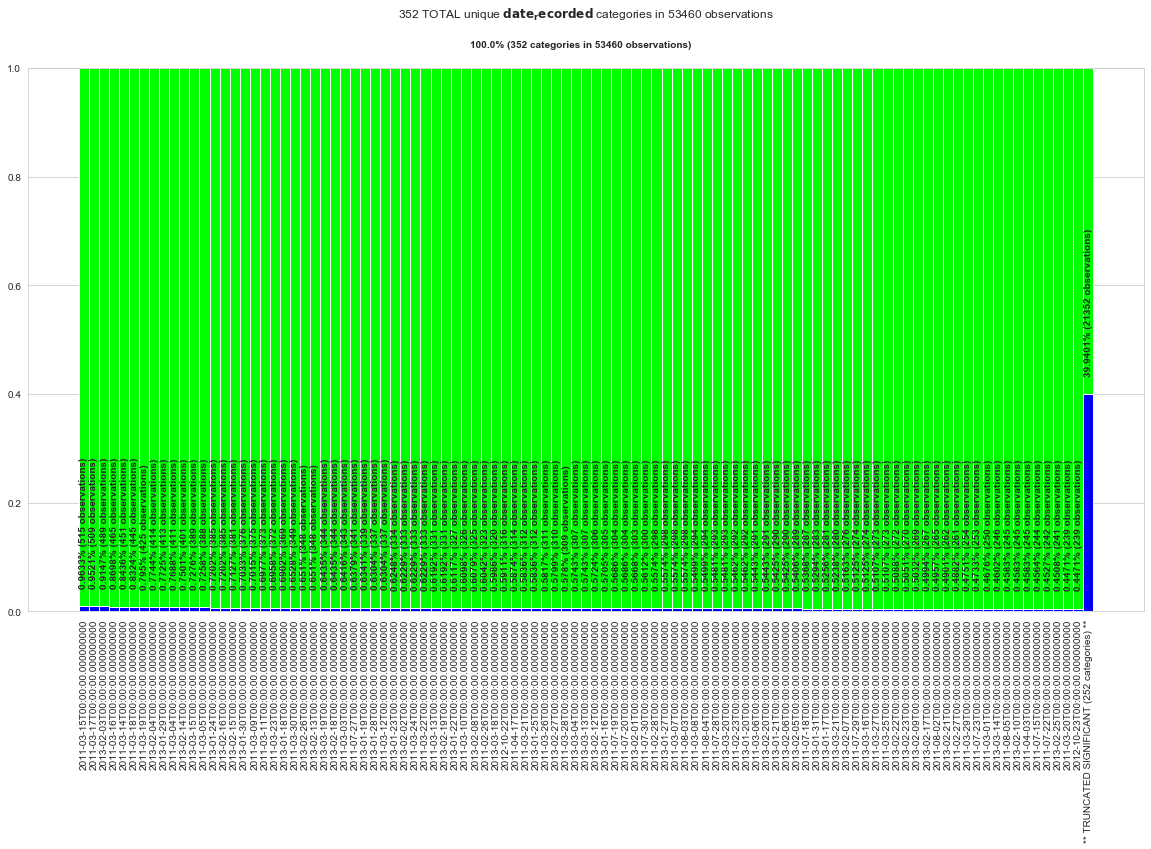

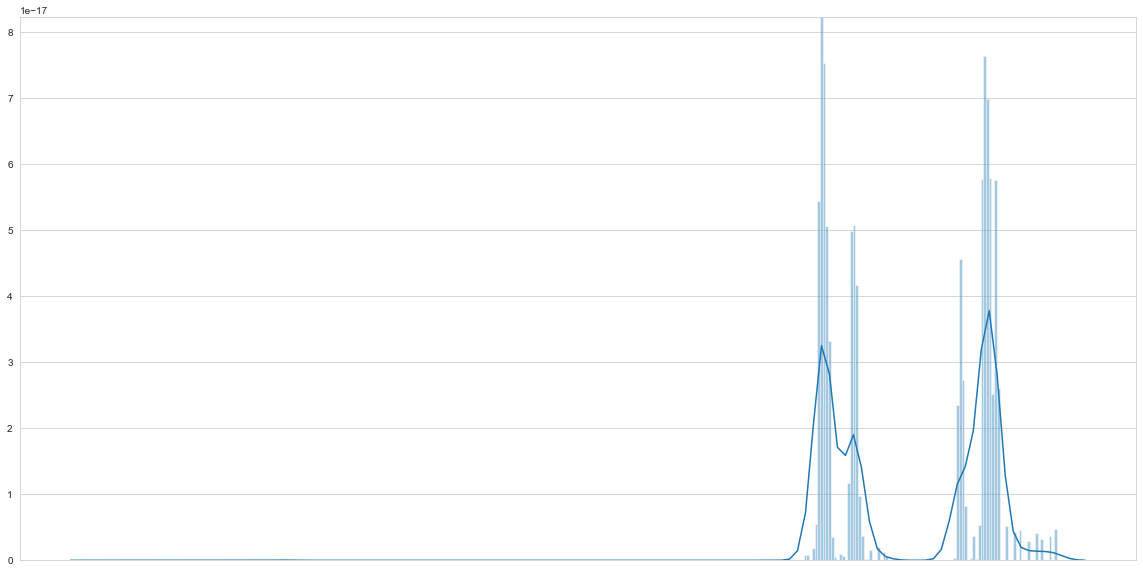

In [61]:
scjpnutils.analyze_distributions(
    X_train__pump_age__feature_eng, 
    'X_train__pump_age__feature_eng', 
    'date_recorded'
);

There are some older <b>date_recorded</b> values but, for the most part, everything looks good so we'll move on to <b>construction_year</b>.

#### Feature Analysis: *construction_year*

It has no null/missing values.  

This feature clearly should be a `date` type but is an `int`.

We'll convert it to a `date` type accordingly.

We notice there is a 0 <b>construction_year</b> value.  

This will cause problems for us so we need to replace it with a meaningful value that doesn't otherwise disturb the distribution.

Note that this MUST be done prior to conversion to `date` type.

<p><br>
Additionally, we need to address the "<b><i>if</i> it occurs, what does a <u>negative</u> pump age mean</b>?" question...

This circumstance occurs when <b>construction_year</b> > <b>date_recorded</b>.

Let's take a quick look at the value counts.

In [62]:
X_train__pump_age__feature_eng.construction_year.value_counts()

0       18688
2010     2375
2008     2339
2009     2301
2000     1886
2007     1426
2006     1316
2003     1157
2011     1127
2004     1015
2002      983
2012      966
1978      927
1995      924
2005      897
1999      892
1998      856
1985      847
1990      845
1996      731
1980      728
1984      712
1982      660
1994      659
1972      641
1974      610
1997      580
1992      565
1993      548
2001      472
1988      471
1983      442
1986      392
1975      388
1976      373
1970      372
1991      289
1989      275
1987      268
1981      220
1977      186
1973      168
1979      167
2013      164
1971      127
1960       93
1967       83
1963       77
1968       64
1969       52
1964       36
1962       28
1965       18
1966       17
1961       17
Name: construction_year, dtype: int64

In order to find all observations where <b>construction_year</b> > <b>date_recorded</b>, we must convert <b>construction_year</b> to a `date` type to make it comparable to <b>date_recorded</b>.  

But this presents an odd situation since the ability to do so requires handling 0-valued <b>construction_year</b> observations FIRST!

So how do we choose an appropriate replacement semantic?  Let's take a look at some simple statistics.

In [63]:
X_train__pump_age__feature_eng.construction_year.describe()

count    53460.000000
mean      1298.789338
std        952.211910
min          0.000000
25%          0.000000
50%       1985.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

We see that replacing 0 with the mean value is a bad idea since this will map all of those 0-valued <b>construction_year</b> observations to an unrealistic year!  We might think that replacing with the median can work - and it can - but then, since our goal is to track pump age (at the time the observation was recorded), the computed pump age (distribution) will be thrown off.

So let's analyze the distribution of values WITHOUT 0.  We will compare this to the distribution after replacement.

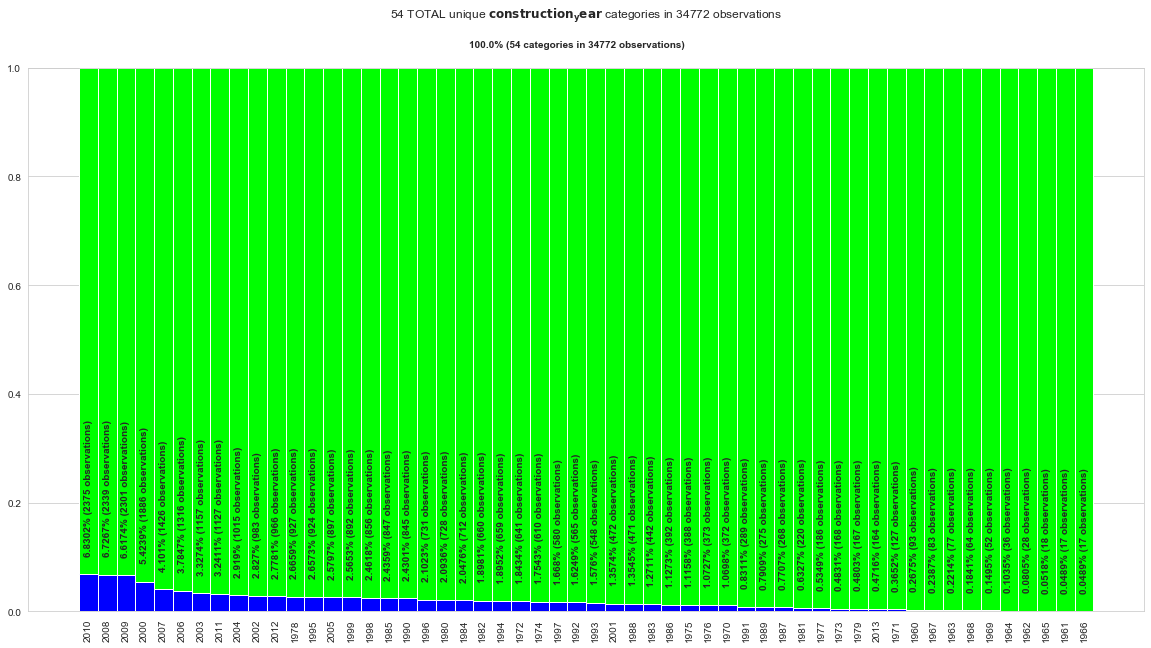

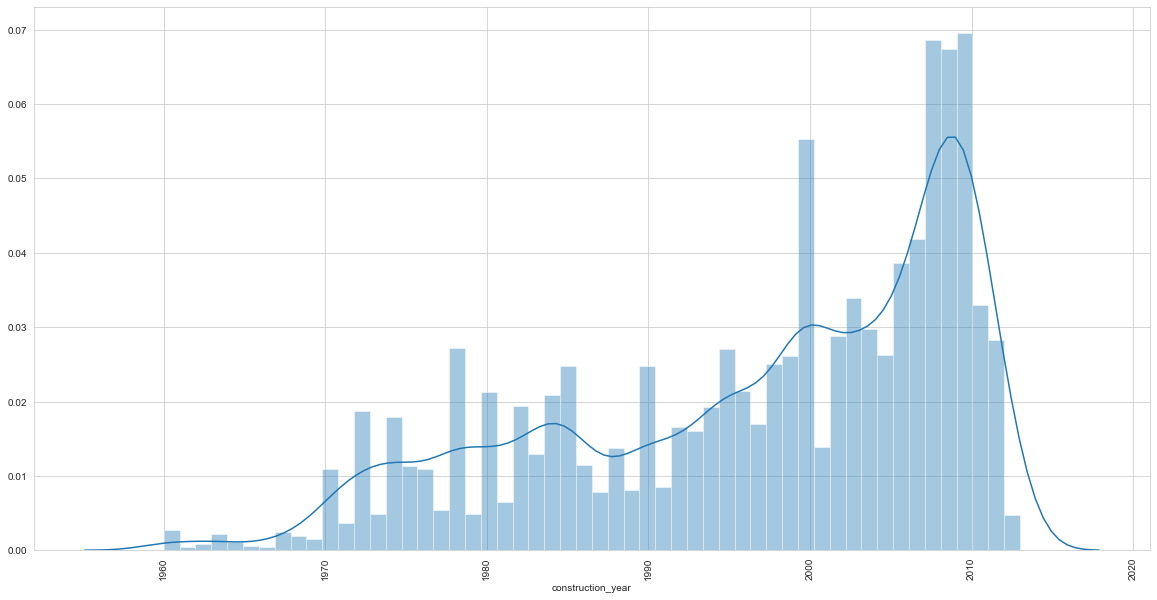

In [64]:
X_train__ct_yr_no_0 = X_train__pump_age__feature_eng[X_train__pump_age__feature_eng.construction_year != 0]
scjpnutils.analyze_distributions(
    X_train__ct_yr_no_0, 
    'X_train__ct_yr_no_0', 
    'construction_year'
);

In [65]:
X_train__ct_yr_no_0.construction_year.describe()

count    34772.000000
mean      1996.815771
std         12.478127
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

The mean <b>construction_year</b> is around 1997 and the median is 2000.  Replacing <b>construction_year</b> with either of these could work.  BUT, we now have to think about the goal of this sub-exercise: to track pump age at the time of the observation recording.  Recall that <b>construction_year</b> 0 essentially represents the unknown.  By replacing this value with ANY value whatsoever will create a synthetic and known pump age, derived from a <b>construction_year</b> that was previously unknown.  So how do we resolve this?

We might resolve this by replacing 0 <b>construction_year</b> with the OLDEST (minimum) <b>date_recorded</b>.

This will ensure that the new <b>pump_age_at_observation_date</b> is at best 0 (years) at and, at worst, $most\_recent(date\_recorded) - oldest(date\_recorded)$.

Note that this obviously requires that **date_recorded** has already been converted to `datetime` type.

In [66]:
def replace_0_construction_year_with_min_date_recorded(df):
    df_copy = df.copy()
    replace_0_construction_year_rules = {
        'construction_year': [{
            'missing_values': 0, 
            'strategy': 'constant', 
            'fill_value': df_copy.date_recorded.min().year
        }]
    }
    svt_0_construction_year = SimpleValueTransformer(replace_0_construction_year_rules)
    df_copy = svt_0_construction_year.fit_transform(df_copy)
    return df_copy

ft_replace_0_construction_year_with_min_date_recorded = FunctionTransformer(lambda X: replace_0_construction_year_with_min_date_recorded(X), validate=False)

X_train__0_construction_year_replaced_with_min_date_recorded = ft_replace_0_construction_year_with_min_date_recorded.fit_transform(X_train__pump_age__feature_eng)

Now we should be able to safely convert <b>construction_year</b> to `date` type. 

In [67]:
ft_construction_year_to_date = FunctionTransformer(lambda X: scjpnutils.convert_col_to_date_type(X, 'construction_year', format="%Y"), validate=False)

X_train__0_construction_year_replaced_with_min_date_recorded = ft_construction_year_to_date.fit_transform(X_train__0_construction_year_replaced_with_min_date_recorded)

Now let's find all observations where <b>construction_year</b> > <b>date_recorded</b>.

In [68]:
X_train__0_construction_year_replaced_with_min_date_recorded[X_train__0_construction_year_replaced_with_min_date_recorded['construction_year']>X_train__0_construction_year_replaced_with_min_date_recorded['date_recorded']][['construction_year', 'date_recorded']]

construction_year date_recorded
id                                   
48759        2011-01-01    2004-06-01
5971         2007-01-01    2004-03-01
9195         2005-01-01    2004-03-01
1251         2008-01-01    2004-12-01
20198        2008-01-01    2004-05-01
55069        2006-01-01    2004-12-01
20534        2009-01-01    2004-03-01
15921        2009-01-01    2004-03-06

How can this be?  From above, we saw that the oldest <b>date_recorded</b> is 2002-10-14.  Recall the semantic for 0-valued <b>construction_year</b> was to replace with the oldest <b>date_recorded</b> (2002-10-14).  Since no <b>construction_year</b> above has value 2002-10-14, this was not the problem.  So the reason for the above must be something else.  Could it be that either <b>construction_year</b> or <b>date_recorded</b> values are errors, or is it still yet something else?

One plausible explanation could be that <u><b>construction_year</b> tracks when construction completed and <b>date_recorded</b> tracks when it began</u>.

If this is indeed the case, and it seems likely it is, then our replacement semantic above was INCORRECT!  Therefore, for 0-valued <b>construction_year</b>, it seems the best we can do is replace <b>construction_year</b> with the observation's <b>date_recorded</b>.  This will yield a 0-value for <b>pump_age_at_observation_date</b>, which is acceptable since this likely represents the case that construction had begun at the time the observation was recorded but was not yet finished.  A 0-value for <b>pump_age_at_observation_date</b> captures this information.

But, then, how do we handle observations, such as those above, in which construction had begun but was not yet completed at the time the observation was recorded (<b>date_recorded</b>) BUT the recorder later updates the record when construction completes?  To be clear, we see that the observations above indicate the following:

1. At the time the observation was recorded, construction had begun but was not yet finished.
2. Then, upon completion of construction, the recorder evidently updated the record with the date construction finally did complete.

So, with that in mind, if we ALLOW <b>construction_year</b> > <b>date_recorded</b>, then <b>pump_age_at_observation_date</b> < 0 also captures the above information (which probably can have some impact on the predictive model)!

Let's put this into play!

The first thing to do is to replace 0-valued <b>construction_year</b> with the observation's <b>date_recorded</b>.

In [69]:
# this is a very specialized function which has intimate knowledge of both construction_year and date_recorded
# it assumes date_recorded has already been converted to datetime
# it assumes construction_year is still and int - i.e. has not yet been converted to datetime
# for 0-valued construction_year, it will extract the year (as an int) from date_recorded to use as a replacement
def replace_0_construction_year_with_date_recorded(df, suppress_output=True):
    df_copy = df.copy()
    df_copy_0_construction_year = df_copy[df_copy.construction_year==0]
    if not suppress_output:
        display(HTML(f"<h3>BEFORE replacing 0-valued <i>construction_year</i> (with <i>date_recorded</i>):</h3>"))
        display(HTML(df_copy.loc[df_copy_0_construction_year.index][['date_recorded', 'construction_year']].to_html(notebook=True, justify='left', max_rows=25)))
    df_copy['dt_recorded_yr'] = df_copy.date_recorded.dt.year
    df_copy['construction_year'] = np.where(df_copy['construction_year']==0, df_copy['dt_recorded_yr'], df_copy['construction_year'])
    df_copy = df_copy.drop('dt_recorded_yr', axis=1)
    if not suppress_output:
        display(HTML(f"<h3>AFTER replacing 0-valued <i>construction_year</i> (with <i>date_recorded</i>):</h3>"))
        display(HTML(df_copy.loc[df_copy_0_construction_year.index][['date_recorded', 'construction_year']].to_html(notebook=True, justify='left', max_rows=25)))
    return df_copy, df_copy_0_construction_year.index

ft_replace_0_construction_year_with_date_recorded = FunctionTransformer(lambda X: replace_0_construction_year_with_date_recorded(X)[0], validate=False)

# test
_, at_index = replace_0_construction_year_with_date_recorded(X_train__pump_age__feature_eng, suppress_output=False)

The transformation looks good.

In [70]:
X_train__pump_age__feature_eng = ft_replace_0_construction_year_with_date_recorded.fit_transform(X_train__pump_age__feature_eng)

Now execute the conversion of <b>construction_year</b> to `datetime` type...

In [71]:
X_train__pump_age__feature_eng = ft_construction_year_to_date.fit_transform(X_train__pump_age__feature_eng)

In [72]:
# this function assumes that both data_recorded and construction_year have aleady been transformed to datetime time
#   this is required
def add_pump_age_feature(df):
    df_copy = df.copy()

    df__pump_age__debug = df_copy[['date_recorded', 'construction_year']].copy()

    # now simply compute date diff (in years)
    df__pump_age__debug['pump_age'] = df__pump_age__debug['date_recorded'].dt.year - df__pump_age__debug['construction_year'].dt.year
    df_copy['pump_age'] = df__pump_age__debug['pump_age']

    return df_copy

# test
X_train__pump_age__feature_eng = add_pump_age_feature(X_train__pump_age__feature_eng)
X_train__pump_age__feature_eng[['date_recorded', 'construction_year', 'pump_age']]

date_recorded construction_year  pump_age
id                                             
56146    2013-03-06        2012-01-01         1
38945    2013-02-05        2009-01-01         4
11841    2011-07-24        2011-01-01         0
1186     2012-11-05        2012-01-01         0
36420    2011-03-26        1996-01-01        15
...             ...               ...       ...
67998    2013-02-18        2005-01-01         8
47669    2013-01-22        2009-01-01         4
1071     2013-01-27        1979-01-01        34
19703    2011-07-17        2011-01-01         0
70556    2013-03-04        2003-01-01        10

[53460 rows x 3 columns]

We're almost ready to apply and commit this step.  The last thing we need to do is make sure that negative <b>pump_age</b> (for the case when construction was still under way at the time the observation was recorded and then later updated) is captured appropriately.

In [73]:
X_train__pump_age__feature_eng[X_train__pump_age__feature_eng['pump_age']<0][['date_recorded', 'construction_year', 'pump_age']]

date_recorded construction_year  pump_age
id                                             
48759    2004-06-01        2011-01-01        -7
5971     2004-03-01        2007-01-01        -3
9195     2004-03-01        2005-01-01        -1
1251     2004-12-01        2008-01-01        -4
20198    2004-05-01        2008-01-01        -4
55069    2004-12-01        2006-01-01        -2
20534    2004-03-01        2009-01-01        -5
15921    2004-03-06        2009-01-01        -5

Finally, let's have a look at the distribution of <b>pump_age</b>.

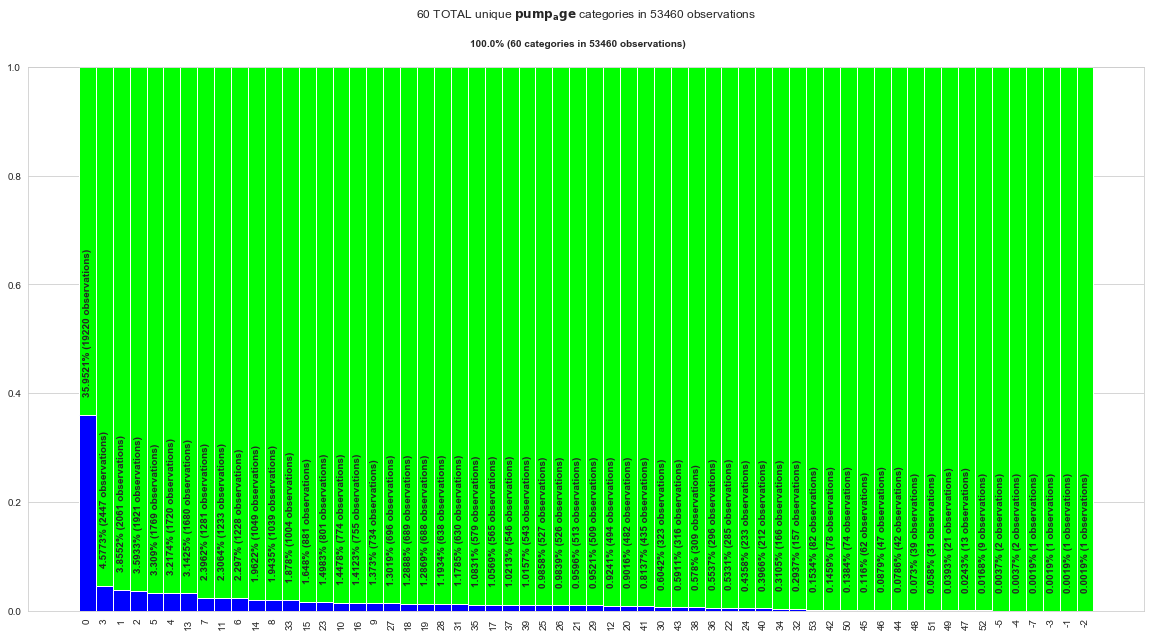

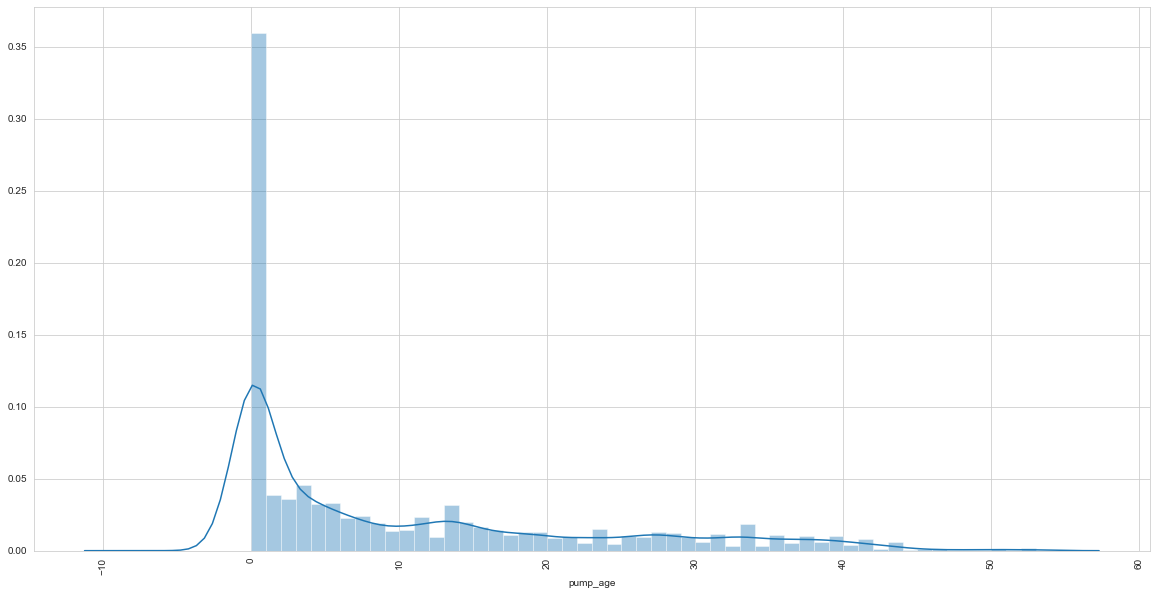

In [74]:
scjpnutils.analyze_distributions(
    X_train__pump_age__feature_eng, 
    'X_train__pump_age__feature_eng', 
    'pump_age'
);

This all looks great so far.

But since we extracted "more" information from <b>date_recorded</b> and <b>construction_year</b> than they both individually contained, we will drop them from consideration in the cleaned data set so that the final classification will not be overfit.

In [75]:
dct_date_recorded_and_construction_year = DropColumnsTransformer(['date_recorded', 'construction_year'])

X_train__pump_age__feature_eng = dct_date_recorded_and_construction_year.fit_transform(X_train__pump_age__feature_eng)
X_train__pump_age__feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             53460 non-null  float64
 1   funder                 50191 non-null  object 
 2   gps_height             53460 non-null  int64  
 3   installer              50173 non-null  object 
 4   longitude              53460 non-null  float64
 5   latitude               53460 non-null  float64
 6   wpt_name               53460 non-null  object 
 7   num_private            53460 non-null  int64  
 8   basin                  53460 non-null  object 
 9   subvillage             53125 non-null  object 
 10  region                 53460 non-null  object 
 11  region_code            53460 non-null  int64  
 12  district_code          53460 non-null  int64  
 13  lga                    53460 non-null  object 
 14  ward                   53460 non-null  object 
 15

<p><br><br>

### Strategy Development: *Create pump_age feature*

#### Concept

The concept follows from all preceding transformations in this section.

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__pump_age__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the preceding discussion.

In [76]:
s_cfg__pump_age_at_observation_date = '''
    {
        "feature_groupings": {
            "pump_age_at_observation_date": {
                "preprocessing_strategy": [
                    ["pump_age", "C__required_proprocessing__pump_age__StrategyTransformer"]
                ]
            }
        }
    }
'''
feat_groupings_cfg = json.loads(json_minify(s_cfg__pump_age_at_observation_date)) # emulates loading this config from a file

X_train__pump_age__feature_eng = demo_emulate_strat_transformation_via_config(feat_groupings_cfg, 'pump_age_at_observation_date', 'pump_age', X_train)

strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation is COMPLETE!
strategy "replace 0 with date_recorded value: construction_year" transformation is COMPLETE!
strategy "convert (from string date format '%Y') to datetime type: construction_year" transformation is COMPLETE!
strategy "create feature from date_recorded and construction_year: pump_age" transformation is COMPLETE!
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy "drop feature: construction_year" transformation is COMPLETE!


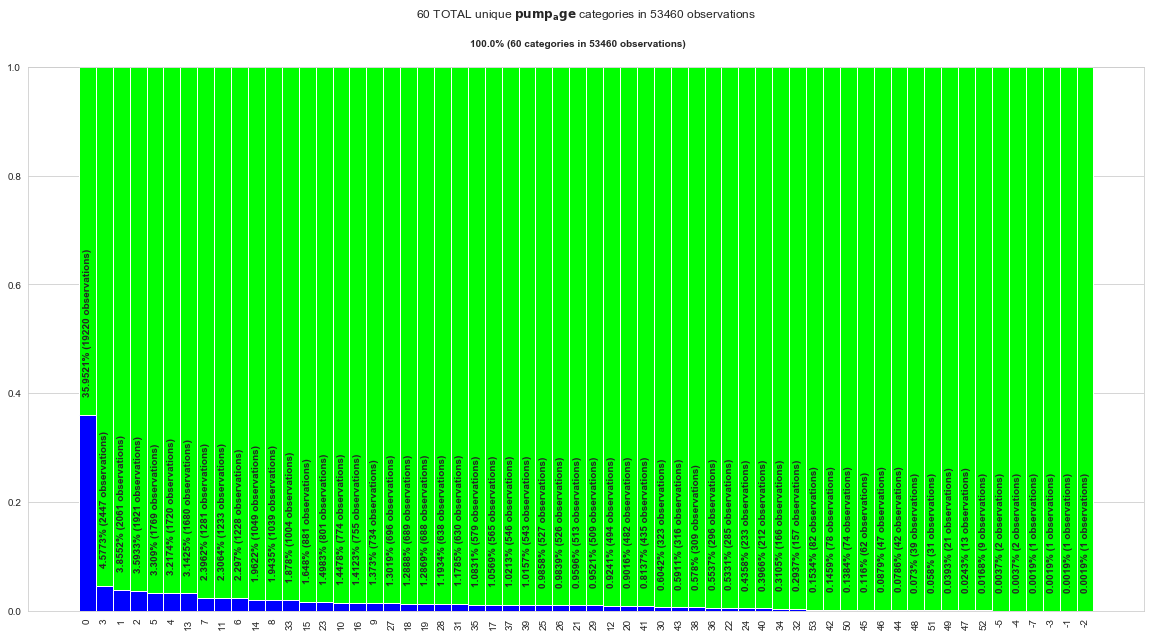

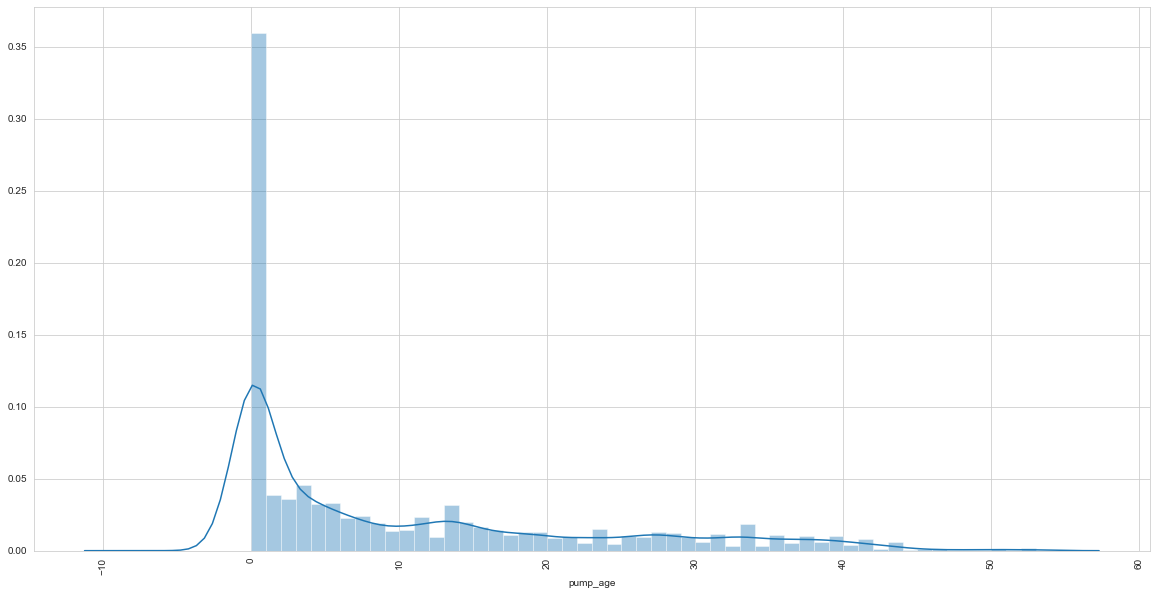

In [77]:
scjpnutils.analyze_distributions(
    X_train__pump_age__feature_eng, 
    'X_train__pump_age__feature_eng', 
    'pump_age'
);

In [78]:
X_train__pump_age__feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             53460 non-null  float64
 1   funder                 50191 non-null  object 
 2   gps_height             53460 non-null  int64  
 3   installer              50173 non-null  object 
 4   longitude              53460 non-null  float64
 5   latitude               53460 non-null  float64
 6   wpt_name               53460 non-null  object 
 7   num_private            53460 non-null  int64  
 8   basin                  53460 non-null  object 
 9   subvillage             53125 non-null  object 
 10  region                 53460 non-null  object 
 11  region_code            53460 non-null  int64  
 12  district_code          53460 non-null  int64  
 13  lga                    53460 non-null  object 
 14  ward                   53460 non-null  object 
 15

<p><br><br>

### Feature grouping *pump_age_at_observation_date* analysis Summary

There is obviously only one (new, engineered) feature in this group: **pump_age**.

As this is an *engineered* feature, all transformations explored are *required* <u>if including it in the model is desired</u>.

So, options (to do this via the config file) are:

1. Creating/engineering this new feature by including the example "pump_age_at_observation_date" config node from above (precisely as it is) within the config file, OR
2. NOT creating/engineering this new feature, in which case the "pump_age_at_observation_date" config node should be removed entirely from the config file

Now let's move on to feature grouping <b>funder</b>.

<p><br><br>

In [79]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'funder', X_train, 'X_train')

#### Feature Analysis: *funder*

There are a fair amount of null/missing values.

This is clearly a categorical feature.

Let's have a look at its value counts that aren't null/missing.

In [80]:
X_train.funder.value_counts()

Government Of Tanzania    8167
Danida                    2784
Hesawa                    1998
Rwssp                     1247
World Bank                1231
                          ... 
Quick Win                    1
Lottery                      1
Soko La Magomeni             1
Hez                          1
Bread Of The Worl            1
Name: funder, Length: 1798, dtype: int64

But we need to handle those null/missing values in order to get a clearer picture.

So what do we replace null/missing values with??

Let's see if <b>funder</b> contains common "none" type words...

But before we do that, let's impute lcase via `C__impute_lcase__StrategyTransformer` that we already created in the analysis of **amount_tsh**.

In [81]:
impute_lcase_transformer__funder = scjpnstrattransformers.C__impute_lcase__StrategyTransformer('funder', pipeline_data_preprocessor=None, verbose=True)
X_train_funder_lcase = impute_lcase_transformer__funder.fit_transform(X_train)

# finally, check to see if there is an appropriate existing value to indicate null - e.g. 'none', 'unknown', 'not known', etc.
scjpnutils.index_of_values(X_train_funder_lcase, 'X_train_funder_lcase', 'funder', ['none', 'unknown', 'not known'])

strategy "impute lower-case transform: funder" transformation is COMPLETE!


(array([  886,  3156,  4944,  5913,  6895,  9058, 11852, 12367, 16005,
        16208, 16432, 19917, 20406, 22652, 23169, 23287, 24323, 28104,
        31103, 33451, 33999, 36005, 38081, 38414, 39279, 40039, 40570,
        43909, 45756]),
 array(['not known', 'unknown', 'none'], dtype=object))

So, not only do we have null/missing values to contend with, we also have multiple non-null representations of the same concept: *unknown* **funder**.

Also, "unknown" (or "not known") is not the same concept as *no* **installer** ("none").  

To make it even messier, there is also a "0" (string) installer, which will also be mapped to "none".  This begs the question, what other "weird" values are present that can be effectively replaced with "none"?

In [82]:
scjpnutils.find_weird_vals(X_train_funder_lcase[['funder']], 'X_train_funder_lcase <i>funder</i>')

funder:
	'0' is weird (according to weird-value regex: '\b[^a-zA-Z]+\b')



{'funder': ['0']}

Let's deal with null/missing and weird values first.

Note that we will adopt the semantic in general for ALL null/missing (and "weird" values) `string`-type variable values such that <b><u>ALL</u> null/missing (and weird) `string`-type variable values will be replaced with "none"</b>.

We will create a new `StrategyTransformer` in case we need this processing in the config for another feature.

### Strategy Development: *Arbitrary Value Replacement*

The strategy is self-explanatory.

Development of the implementation is as follows.

<p><br>

#### Conceptual Development of `C__value_replacement__StrategyTransformer`

Follwing the pattern of other value-replacement strategies, this one will also use `SimpleValueTransformer` (which wraps sklearn's `SimpleImputer`) within `skl_transformers.py`.

Note that this new `StrategyTransformer` cannot be used to impute `nan` (for reasons already explained) - one must use `C__replace_value_with_nan__StrategyTransformer` to impute `nan`.  But that's not what we're doing in this case.

In [83]:
svt_null_funder = SimpleValueTransformer(
    {
        'funder': [
            {
                'missing_values': np.nan, 
                'strategy': 'constant', 
                'fill_value': eda_config['missing_string_value_replacement']
            },
            {
                'missing_values': '0', 
                'strategy': 'constant', 
                'fill_value': eda_config['missing_string_value_replacement']
            }
        ]
    }
)
X_train_funder_lcase_nans_replaced = svt_null_funder.fit_transform(X_train_funder_lcase)

# let's make sure there are now no nulls
scjpnutils.analyze_values(
    X_train_funder_lcase_nans_replaced[['funder']], 
    'X_train_funder_lcase_nans_replaced <i>funder</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

All good.  The above has been wrapped within the `C__value_replacement__StrategyTransformer
` class.

Let's quickly test it out before moving on.

In [84]:
missing_value_replacement_transformer__funder = scjpnstrattransformers.C__value_replacement__StrategyTransformer(
    'funder', 
    [
        {'missing_values': np.nan, 'strategy': 'constant', 'fill_value': eda_config['missing_string_value_replacement']},
        {'missing_values': '0', 'strategy': 'constant', 'fill_value': eda_config['missing_string_value_replacement']}
    ],
    pipeline_data_preprocessor=None, 
    verbose=True  
)
X_train_funder_lcase_nans_replaced = missing_value_replacement_transformer__funder.fit_transform(X_train_funder_lcase)

scjpnutils.analyze_values(
    X_train_funder_lcase_nans_replaced[['funder']], 
    'X_train_funder_lcase_nans_replaced <i>funder</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" transformation is COMPLETE!


NOTE!  **Since this `StrategyTransformer` depends on particular values, it will not be able to be used directly within the config file**.

So, we must create a derived version with particular values, specific to **funder**.

Thus, the class `C__missing_value_imputer__funder__StrategyTransformer`, derived from `C__value_replacement__StrategyTransformer`, has been created.  This `StrategyTransformer` CAN be used directly within the config file.

Let's test this one out via a "fake" config before moving on.  The result should be identical to the one above.

In [85]:
s_cfg__funder = '''
    {
        "feature_groupings": {
            "funder": {
                "preprocessing_strategy": [
                    ["funder", "C__impute_lcase__StrategyTransformer"],
                    ["funder", "C__missing_value_imputer__funder__StrategyTransformer"]
                ]
            }
        }
    }
'''
feat_groupings_cfg = json.loads(json_minify(s_cfg__funder)) # emulates loading this config from a file

X_train__funder_transformed_via_cfg = demo_emulate_strat_transformation_via_config(feat_groupings_cfg, 'funder', 'funder', X_train)

scjpnutils.analyze_values(
    X_train__funder_transformed_via_cfg[['funder']], 
    'X_train__funder_transformed_via_cfg <i>funder</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" transformation is COMPLETE!


Now, since we noticed there are multiple values that represent an unknown <b>funder</b> - values are "unknown" and "not known" - let's replace one with the other.

Replacing "not known" with "unknown" seems like the logical thing to do - one word is better than two for our purpose.

We can use the `C__value_replacement__StrategyTransformer` class as the basis for a new (derived) one specific to **funder**.

In [86]:
not_known_literal_value_replacement_transformer__funder = scjpnstrattransformers.C__value_replacement__StrategyTransformer(
    'funder',
    {'funder': [{'missing_values': "not known", 'strategy': 'constant', 'fill_value': "unknown"}]},
    pipeline_data_preprocessor=None,
    verbose=True
)

X_train_funder_transformed = not_known_literal_value_replacement_transformer__funder.fit_transform(X_train_funder_lcase_nans_replaced)

scjpnutils.index_of_values(X_train_funder_transformed, 'X_train_funder_transformed', 'funder', ['not known'])

strategy "replace values for feature: funder" replacement_rules:
{
    "funder": {
        "funder": [
            {
                "missing_values": "not known",
                "strategy": "constant",
                "fill_value": "unknown"
            }
        ]
    }
}
strategy "replace values for feature: funder" transformation is COMPLETE!


(array([  886,  4944,  5913,  6895,  9058, 11852, 12367, 16005, 16208,
        16432, 19917, 20406, 23287, 24323, 28104, 33451, 33999, 36005,
        38081, 38414, 39279, 40039, 40570, 45756]),
 array(['not known'], dtype=object))

The above value-replacement has been captured in `C__not_known_literal_value_replacement__funder__StrategyTransformer`.

<p><br><br>

### Strategy Development: *Execute all required preprocessing transformations on funder*

#### Concept

The concept follows from all preceding transformations in this section.

All of the above preprocessing steps represent minimal "required" steps to do further processing.  Any additional preprocessing must always follow the above preprocessing.  Therefore, all steps above have been encapsulated within a single class: `C__required_proprocessing__funder__StrategyTransformer`.  

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__pump_age__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the preceding discussion.

Let's wrap this part of the discussion up by quickly testing an emulated config using it.  Again, this should result in exactly the same result as above.  But this time, we start with the base `X_train` to be sure it does everything we want it to do.

In [87]:
s_cfg__funder = '''
    {
        "feature_groupings": {
            "funder": {
                "preprocessing_strategy": [
                    ["funder", "C__required_proprocessing__funder__StrategyTransformer"]
                ]
            }
        }
    }
'''
feat_groupings_cfg = json.loads(json_minify(s_cfg__funder)) # emulates loading this config from a file

X_train__required_preprocessing_via_cfg = demo_emulate_strat_transformation_via_config(feat_groupings_cfg, 'funder', 'funder', X_train)

print(f"\nindex of 'not known' funders in X_train__funder_transformed_via_cfg: {scjpnutils.index_of_values(X_train__required_preprocessing_via_cfg, 'X_train__required_preprocessing_via_cfg', 'funder', ['not known'])}")
scjpnutils.analyze_values(
    X_train__required_preprocessing_via_cfg[['funder']], 
    'X_train__required_preprocessing_via_cfg <i>funder</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "strategy": "constant",
            "fill_value": "unknown"
        }
    ]
}
strategy "replace values for feature: funder" transformation is COMPLETE!

index of 'not known' funders in X_train__funder_transformed_via_cfg: (array([], dtype=int64), array([], dtype=object))


This will further facilitate ease of use in the config file and since, from here, we have options on what we do next.

Let's continue with our analysis...

With null/missing (and weird) values replaced with "none" and "not known" values replaced with "unknown", we are in a position to get an accurate view of the distribution of "unique" values.  

Later we will see that there are still many different "single-entity" representations of <b>funder</b> (as well as other categorical variable categories) that can only be addressed by more advanced techniques - `TF-IDF` with `KMeans` Clustering natural language analysis and processing.  It's not a straightforward task to find "duplicates" without these techniques.  Therefore, we will not truly be observing "unique" values in the following.

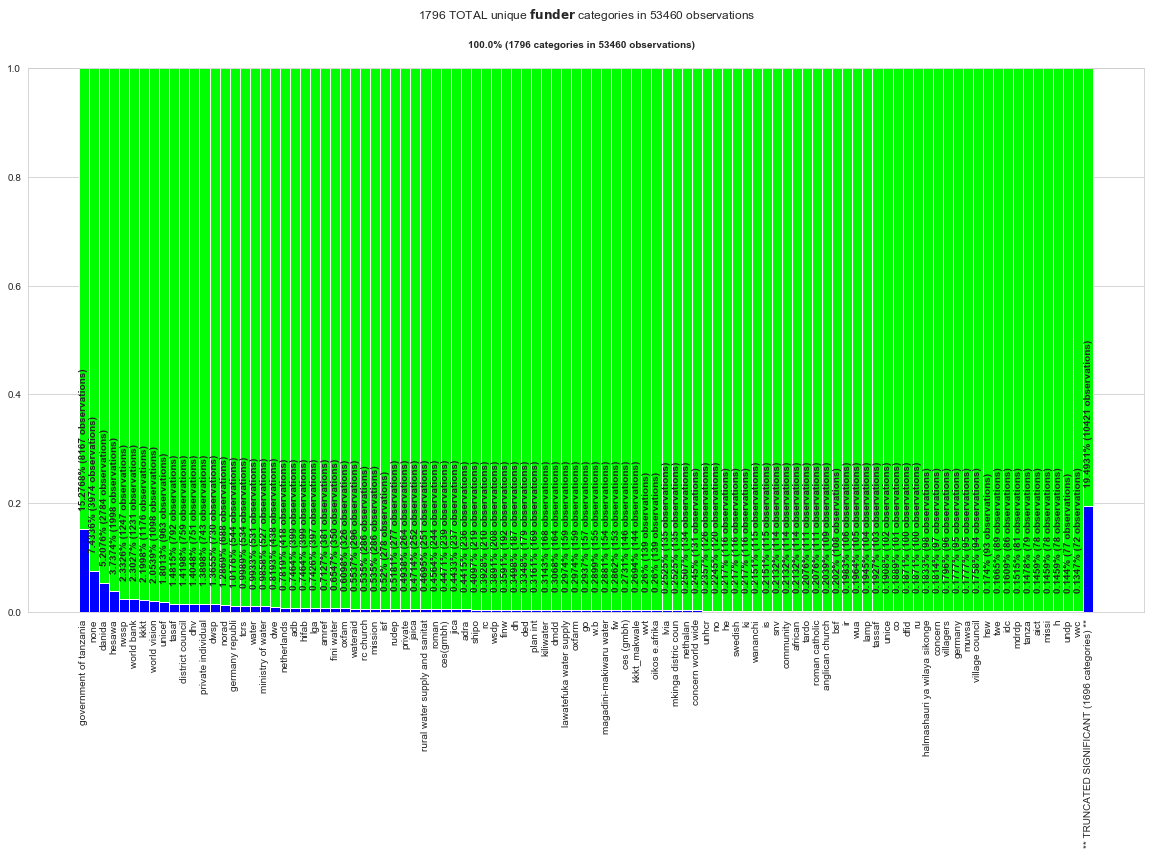

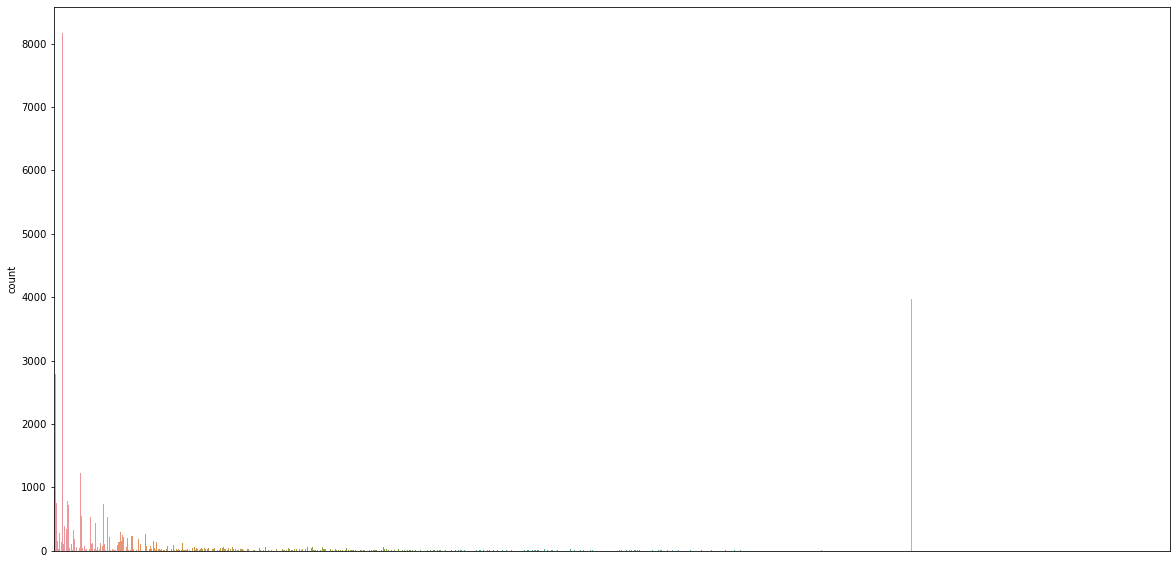

In [88]:
scjpnutils.analyze_distributions(
    X_train__required_preprocessing_via_cfg, 
    'X_train__required_preprocessing_via_cfg', 
    'funder'
);

Note the *cardinality* of this categorical variable - it's QUITE HIGH!  But are those categories really unique?

In [89]:
scjpnutils.analyze_non_alphanumeric_strings(X_train__required_preprocessing_via_cfg[['funder']], 'X_train__required_preprocessing_via_cfg <i>funder</i>');

Questions:

1. Is there really a funder named "action in a"?  Seems like a typo to me.
2. How about "adp/w"?
3. And look at all of those so-called "unique" <b>funder</b>s that start with the words "africa" or "african" - in particular, are "african development bank" and "african development foundation" or, worse yet, "africa 2000 network/undp" and "african 2000 network" really DIFFERENT/unique entities?  It's hard to say in some cases but **these last examples are clearly data-entry mistakes**!
4. Perhaps a more blatant example is: "arab community" vs. "arabs community"; once again, these clearly reference the same real-world entity but are represented in the data as two different, "unique" <b>funder</b> entities.

You see the problem?  If we have seen this much "duplication" of single entities with different representations in only the first handful of examples, then this problem must be pervasive throughout this categorical variable... indeed, throughout ALL categorical variables (with high cardinality).

<p><br><br>

### Strategy Development: *`TF-IDF` `KMeans` Classify High-Cardinality Categoricals*

Thus, an <i>unsupervised learning</i> algorithm involving `TF-IDF` combined with `KMeans Clustering` has been developed to address this natural language processing problem.  I will not duplicate the details of that research herein - if you are interested in the details, they can be found in the separate <i>High Cardinality Text-based Categorical Variable Classification</i> Jupyter notebook ([TFIDF-KMeans-CategoricalClassification-Algo.ipynb](TFIDF-KMeans-CategoricalClassification-Algo.ipynb)) - but I will now apply the results, encapsulated in the `tfidf_kmeans_classify_feature__fit` and `tfidf_kmeans_classify_feature__transform` functions, used below.

Note that **this technique is meant to be applied sparingly and only to those categorical variables with initially <u>high</u> cardinality**.  

For example, <b>funder</b> has an unmanagably high amount of so-called "unique" categories - thus, its cardinality is very high.  The real aim here is to remove some inaccuracy by coalescing "similar" but ultimately different representations of what we think may be the same entity into one, with the help of some NLP techniques.

Since using this technique is basically a task involving building submodels - we actually build a `KMeans` model - there are hyper-parameters involved.  There are many hyper-parameters one can tune with `KMeans` but this has been abstracted away with the exception of the `n_clusters` hyper-parameter.  This is exposed only indirectly.  Instead, one *may* manipulate the mean cluster-size which should be related to the measure of disorder (entropy) after `TF-IDF` vectorization.  In fact, the default behavior is to do exactly that.  The idea goes like this:

1. `TF-IDF` vectorize the corpus of unique values.
2. Measure the entropy of the probability distribution `TF-IDF` vectorization creates - entropy represents "how many questions we must ask to get the right answer (given a probability distribution)" (see https://www.youtube.com/watch?v=2s3aJfRr9gE for a friendly explanation).
3. This effectively gives us the <u>mean</u> size a cluster `KMeans` creates should be.
4. So `KMeans` `n_clusters`, in this case, is defined as $n\_clusters = math.ceil(\frac{len(corpus)}{mean\_cluster\_size = entropy})$.

<p><br><br>

After applying the algorithm encapsulated within the `tfidf_kmeans_classify_feature__fit` and `tfidf_kmeans_classify_feature__transform` functions, we end up with the newly engineered feature <b>&lt;<i>feat_name</i>&gt;_tfidf_kmeans_class</b> added to the transformed data set.  For example, in this case, the new feature is named <b>funder_tfidf_kmeans_class</b>.

<p><br><br>

#### Implementation Details of `StrategyTransformer` class: `C__tfidf_kmeans_classify__StrategyTransformer`

This class will wrap the essence of what is demonstrated in the following example:

In [90]:
_, corpus, tfidf, tfidf_vectorizer, idx_term_map, kmeans, df_kmeans_clusters = scjpnsubmodels.tfidf_kmeans_classify_feature__fit(
    X_train__required_preprocessing_via_cfg, 
    '', 
    'funder', 
    verbosity=1
)

Now we transform (map dirty funders to funder_tfidf_kmeans_classes in) X_train (with required preprocessing already done)...

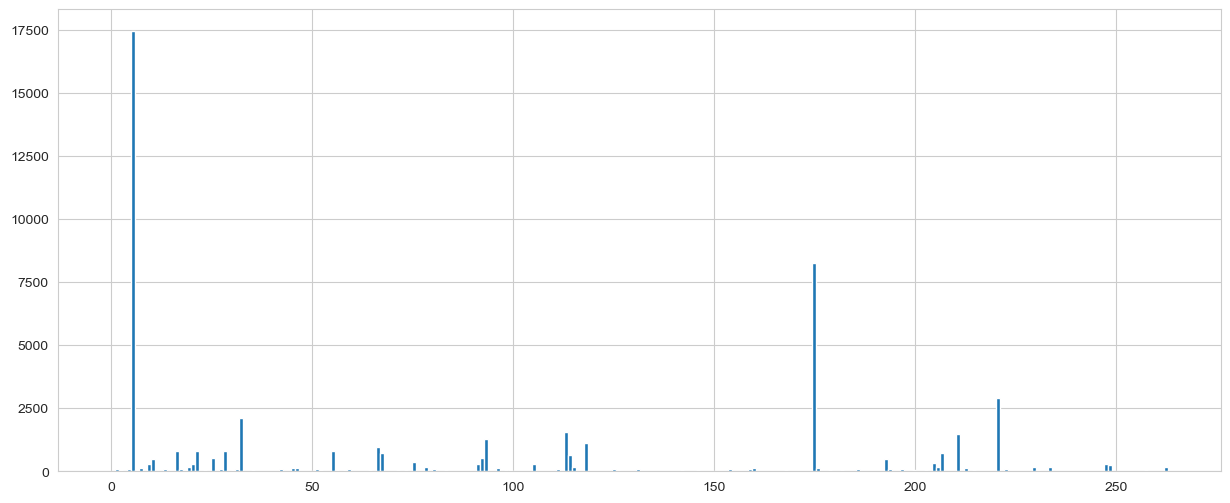

In [91]:
X_train_funder_tfidf_classified, _, _ = scjpnsubmodels.tfidf_kmeans_classify_feature__transform(
    X_train__required_preprocessing_via_cfg, 
    '', 
    'funder', 
    tfidf_vectorizer, 
    idx_term_map, 
    kmeans, 
    df_kmeans_clusters, 
    verbosity=1
)

In [92]:
X_train_funder_tfidf_classified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   amount_tsh                 53460 non-null  float64
 1   date_recorded              53460 non-null  object 
 2   funder                     53460 non-null  object 
 3   gps_height                 53460 non-null  int64  
 4   installer                  50173 non-null  object 
 5   longitude                  53460 non-null  float64
 6   latitude                   53460 non-null  float64
 7   wpt_name                   53460 non-null  object 
 8   num_private                53460 non-null  int64  
 9   basin                      53460 non-null  object 
 10  subvillage                 53125 non-null  object 
 11  region                     53460 non-null  object 
 12  region_code                53460 non-null  int64  
 13  district_code              53460 non-null  i

Let's just test out the above (wrapped in `C__tfidf_kmeans_classify__StrategyTransformer`) on `X_validation`...

strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "strategy": "constant",
            "fill_value": "unknown"
        }
    ]
}
strategy "replace values for feature: funder" transformation is COMPLETE!


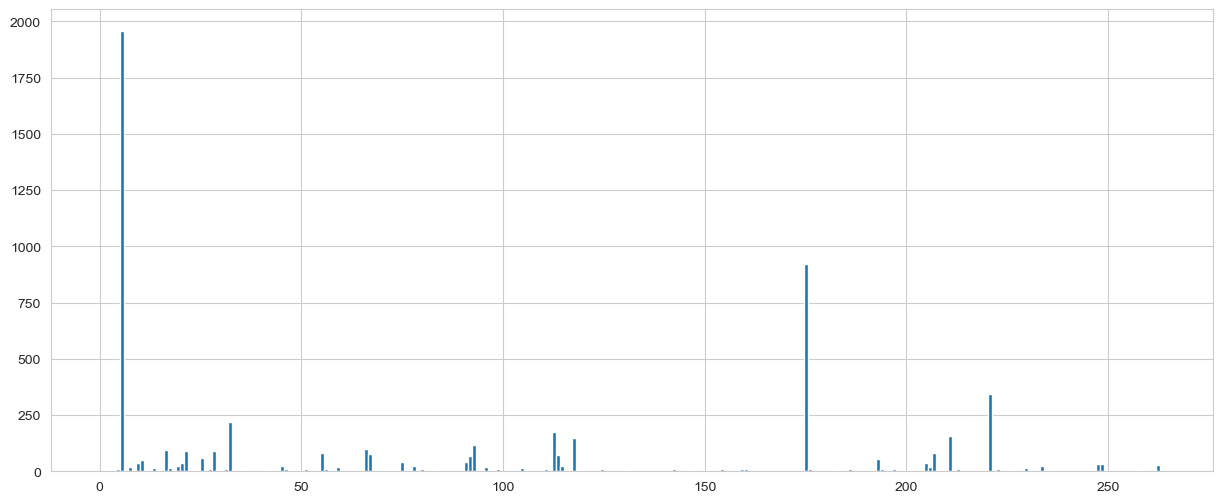

In [93]:
# test on X_validation
required_proprocessing_funder_transformer = scjpnstrattransformers.C__required_proprocessing__funder__StrategyTransformer(pipeline_data_preprocessor=None, verbose=True)
X_validation__required_preprocessing_funder = required_proprocessing_funder_transformer.fit_transform(X_validation)

X_validation_funder_tfidf_classified, _, _ = scjpnsubmodels.tfidf_kmeans_classify_feature__transform(
    X_validation__required_preprocessing_funder, 
    '', 
    'funder', 
    tfidf_vectorizer, 
    idx_term_map, 
    kmeans, 
    df_kmeans_clusters,
    verbosity=1
)

The `C__tfidf_kmeans_classify__StrategyTransformer` wraps the above to produce a transformed data set with new feature <b>&lt;<i>feat_name</i>&gt;_tfidf_kmeans_class</b> added to the (transformed) data set.

**Since these are effectively just labels, it is then required to Target Encode the resulting labels with one of the `StrategyTransformer` classes derived from `C__target_encode__StrategyTransformer`**.  But since there are different schemes for Target-Encoding, it is an external requirement and therefore not implicitly included in the class implementation.

In [94]:
# for example, using (regular, not LOO) target encoding with nans mapped to target global mean...
funder_tfidf_kmeans_class_target_encode_transformer = scjpnstrattransformers.C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer(
    'funder_tfidf_kmeans_class', 
    pipeline_data_preprocessor=None, 
    verbose=True
)
X_train__after_target_encoding_funder_tfidf_kmeans_class = funder_tfidf_kmeans_class_target_encode_transformer.fit_transform(
    X_train_funder_tfidf_classified, 
    y_train_encoded.status_group
)

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'funder_tfidf_kmeans_class' in X match those that were previously fit
added new feature: funder_tfidf_kmeans_class_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder_tfidf_kmeans_class' dropped feature 'funder_tfidf_kmeans_class' after target encoding
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder_tfidf_kmeans_class' transformation of feature 'funder_tfidf_kmeans_class' to 'funder_tfidf_kmeans_class_target_encoded' is COMPLETE!


In [95]:
X_train__after_target_encoding_funder_tfidf_kmeans_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   amount_tsh                                53460 non-null  float64
 1   date_recorded                             53460 non-null  object 
 2   funder                                    53460 non-null  object 
 3   gps_height                                53460 non-null  int64  
 4   installer                                 50173 non-null  object 
 5   longitude                                 53460 non-null  float64
 6   latitude                                  53460 non-null  float64
 7   wpt_name                                  53460 non-null  object 
 8   num_private                               53460 non-null  int64  
 9   basin                                     53460 non-null  object 
 10  subvillage                      

Note that after we compose these two operations, we still have the original feature in the data set, plus, since we then Target-Encode **funder_tfidf_kmeans_class**, we have **funder_tfidf_kmeans_class_target_encoded**.  Thus, it is a good idea to follow this up with the "drop the feature" strategy on the original feature (**funder** in this case).

We wrap up this part of the discussion with an example demonstrating how this is used with an emulated config.

In [96]:
# # this has been commented out due to the amount of time it takes

# # but this is how it is done
# s_cfg__funder_tfidf_kmeans_classified_target_encoded = '''
#     {
#         "feature_groupings": {
#             "funder": {
#                 "preprocessing_strategy": [
#                     ["funder", "C__required_proprocessing__funder__StrategyTransformer"],
#                     ["funder", "C__tfidf_kmeans_classify__funder__StrategyTransformer"], //new feature funder_tfidf_kmeans_class exists after this
#                     ["funder_tfidf_kmeans_class", "C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer"], //new feature funder_tfidf_kmeans_class_target_encoded exists after this, implicitly drops funder_tfidf_kmeans_class
#                     ["funder", "C__drop_it__StrategyTransformer"]
#                 ]
#             }
#         }
#     }
# '''
# feat_groupings_cfg = json.loads(json_minify(s_cfg__funder_tfidf_kmeans_classified_target_encoded)) # emulates loading this config from a file

# X_train__after_target_encoding_funder_tfidf_kmeans_class = demo_emulate_strat_transformation_via_config(
#     feat_groupings_cfg, 
#     'funder', 
#     'funder', 
#     X_train, 
#     y_train_encoded.status_group
# )
# # from the above, we will get the new feature: funder_tfidf_kmeans_class_target_encoded

# # check for this in col names
# X_train__after_target_encoding_funder_tfidf_kmeans_class.info()

Note that after we compose these two operations, we still have the original feature in the data set, plus, since we then Target-Encode **funder_tfidf_kmeans_class**, we have **funder_tfidf_kmeans_class_target_encoded**.  Thus, it is a good idea to follow this up with the "drop the feature" strategy on the original feature (**funder** in this case).

In [97]:
scjpnutils.analyze_values(
    X_train__after_target_encoding_funder_tfidf_kmeans_class[['funder_tfidf_kmeans_class_target_encoded']], 
    'X_train__after_target_encoding_funder_tfidf_kmeans_class <i>funder_tfidf_kmeans_class_target_encoded</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

As another, much simpler means of dimensionality-reduction, we consider an alternative strategy.  For this, we will consider using only the top *n* significant (by frequency) categories.

<p><br><br>

### Strategy Development: *Top n significant categories*

#### Concept

We consider the top *n* features (by frequency) significant and remap all remaining to categories "other".

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__top_n_significance__StrategyTransformer`

This class captures the the `analyze_distributions__top_n`.  This function returns a dictionary holding the top *n* (by frequency) categories, the index in the dataframe where those categories occur, as well as a list of the "insignificant" categories, which will be used to map to the "other" category.
    
For example...

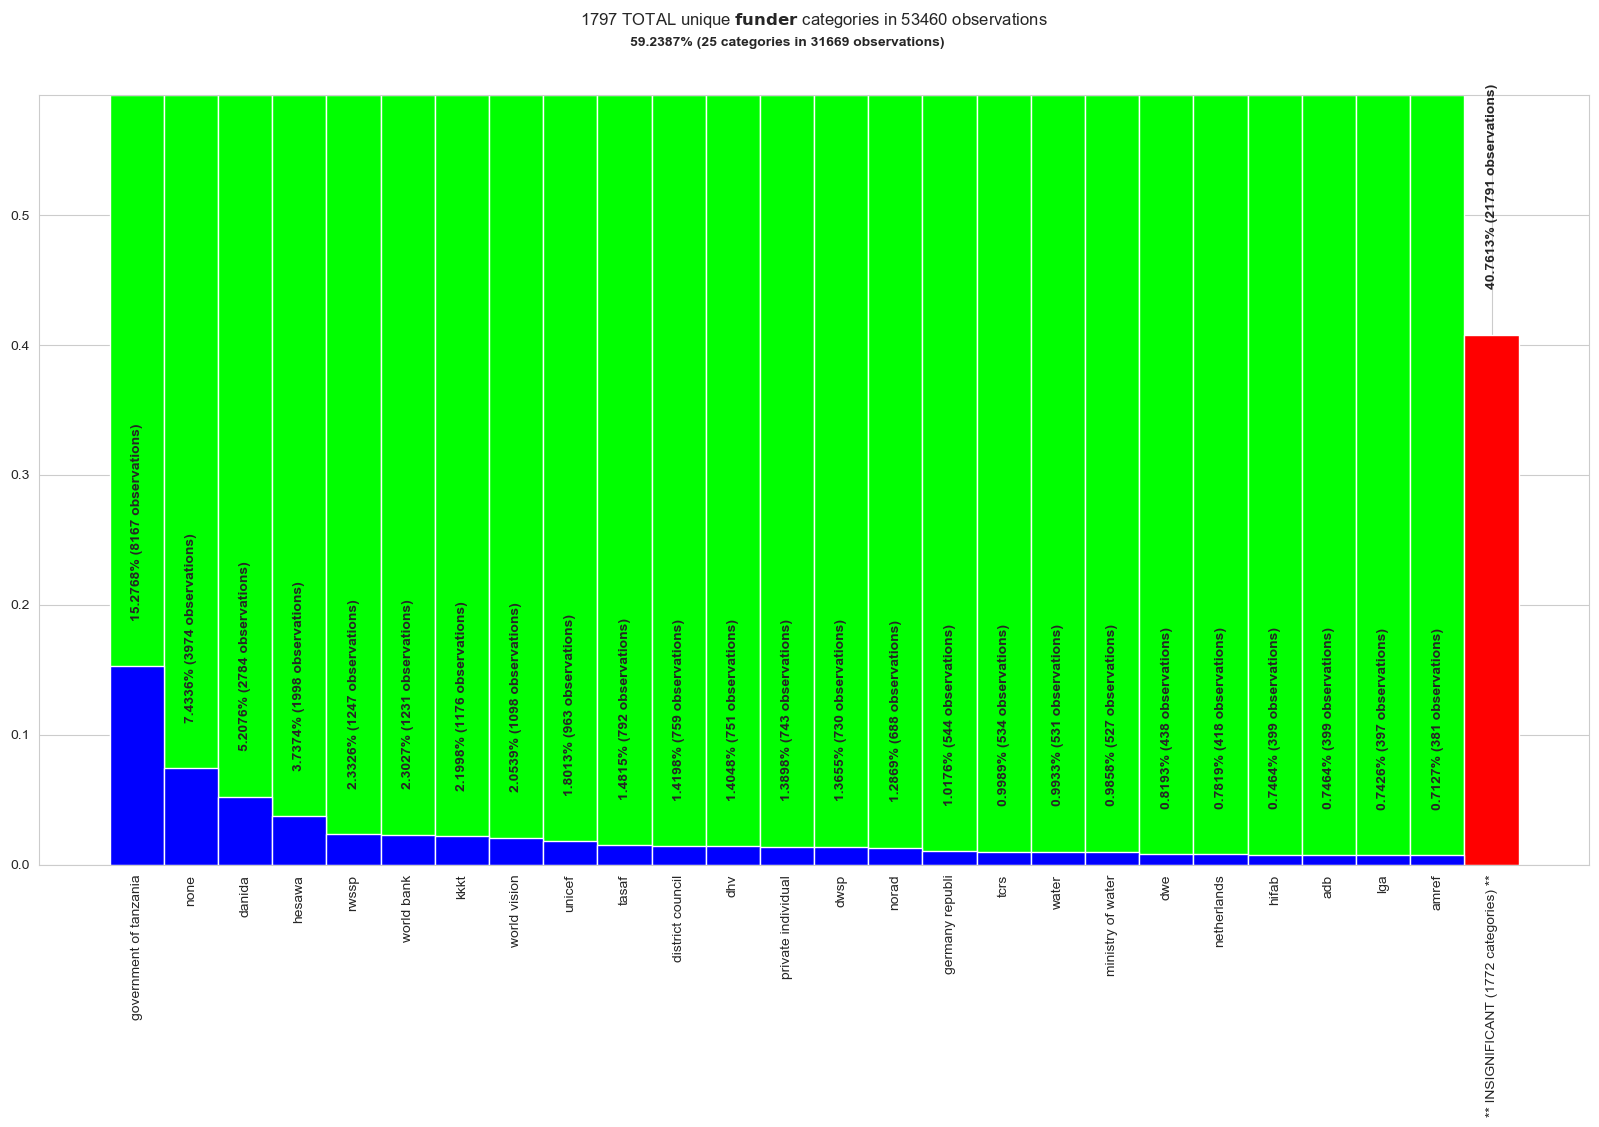

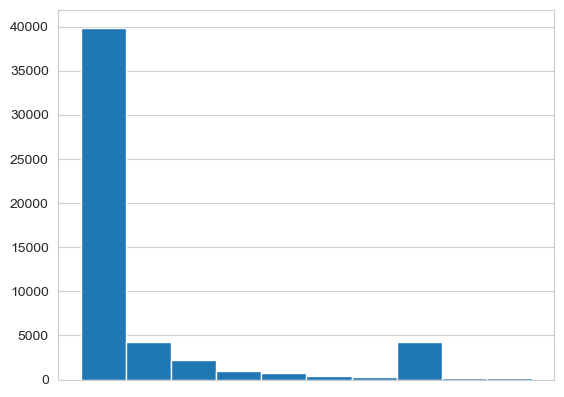

In [98]:
funder_result_by_top_n = scjpnutils.analyze_distributions__top_n(
    X_train_funder_transformed,
    'X_train_funder_transformed', 
    'funder',  
    top_n=25,
    map_to_candidates=['other']
)

<p><br>
    
The following function accomplishes the mapping of the "insignificant" categories to "none".

In [99]:
def replace_insig_categories(df, feat, top_n, map_to="other"):
    _result = scjpnutils.analyze_distributions__top_n(
        df, 
        '', 
        feat, 
        top_n=top_n, 
        suppress_output=True
    )
    replace_insig_categories_rules = []
    for insig_cat_val in _result[top_n]['insig'][0]:
        replace_insig_categories_rules.append({
            'missing_values': insig_cat_val,
            'strategy': 'constant',
            'fill_value': map_to
        })
    replace_insig_categories_rules = {feat: replace_insig_categories_rules}
    svt_insig_categories = SimpleValueTransformer(replace_insig_categories_rules)
    return svt_insig_categories.fit_transform(df)

For example...

In [100]:
X_train_funder_transformed__insig_replaced = replace_insig_categories(X_train_funder_transformed, 'funder', top_n=10, map_to="other")

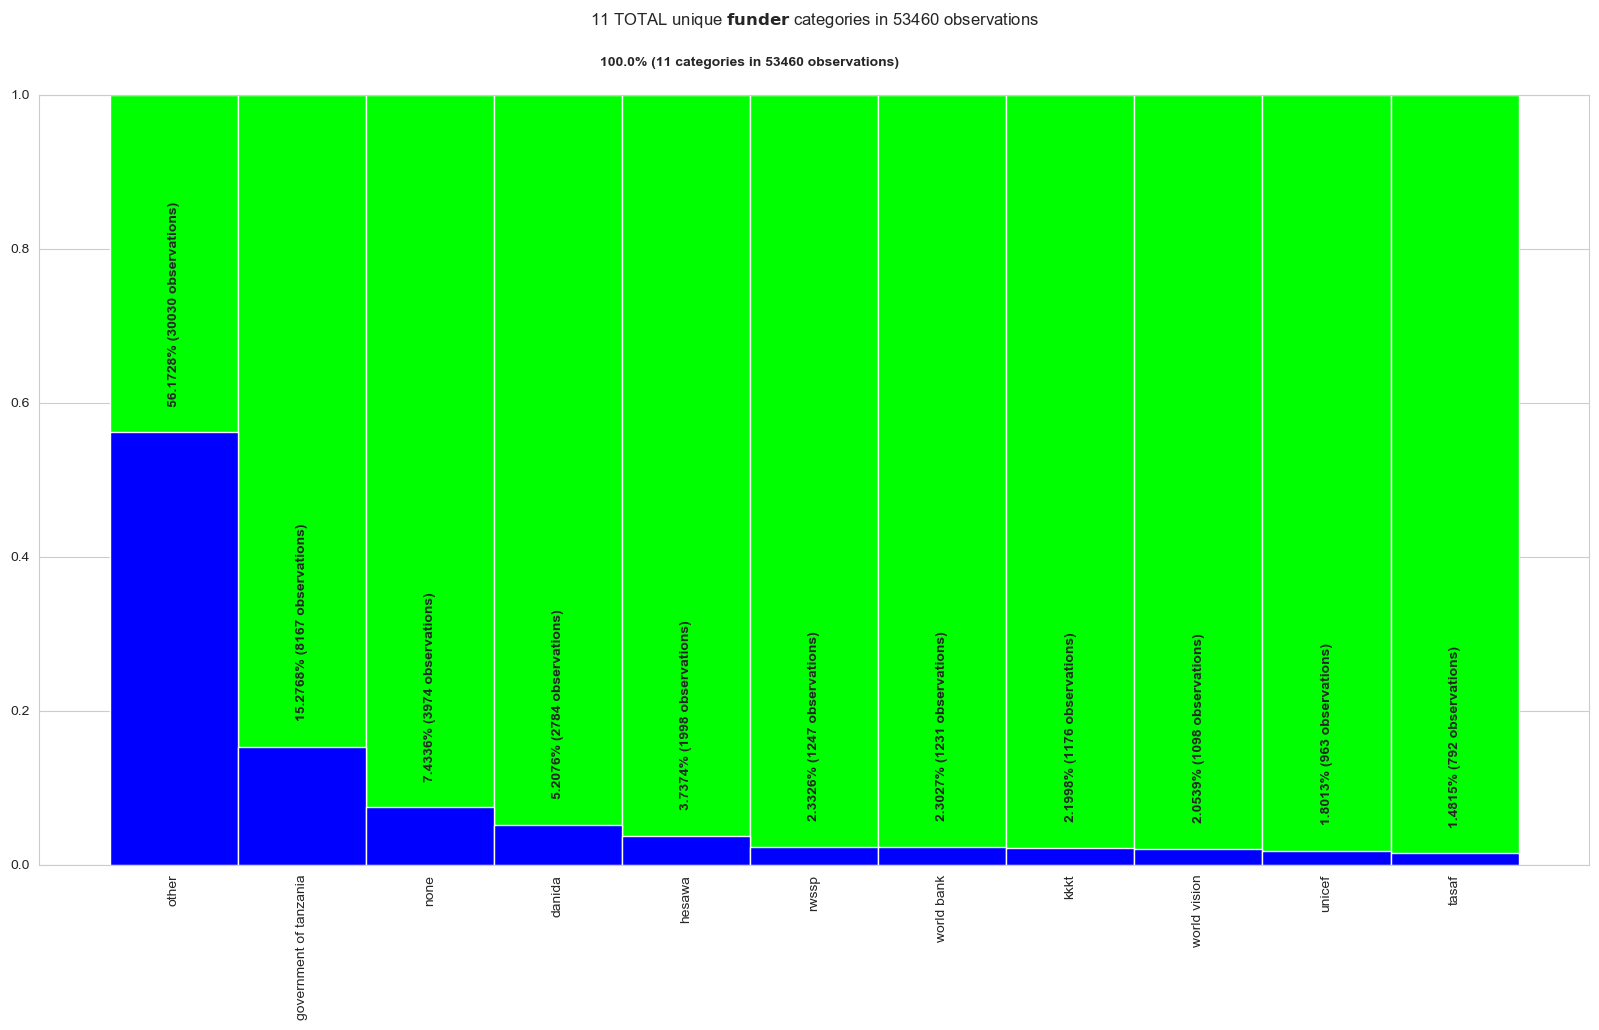

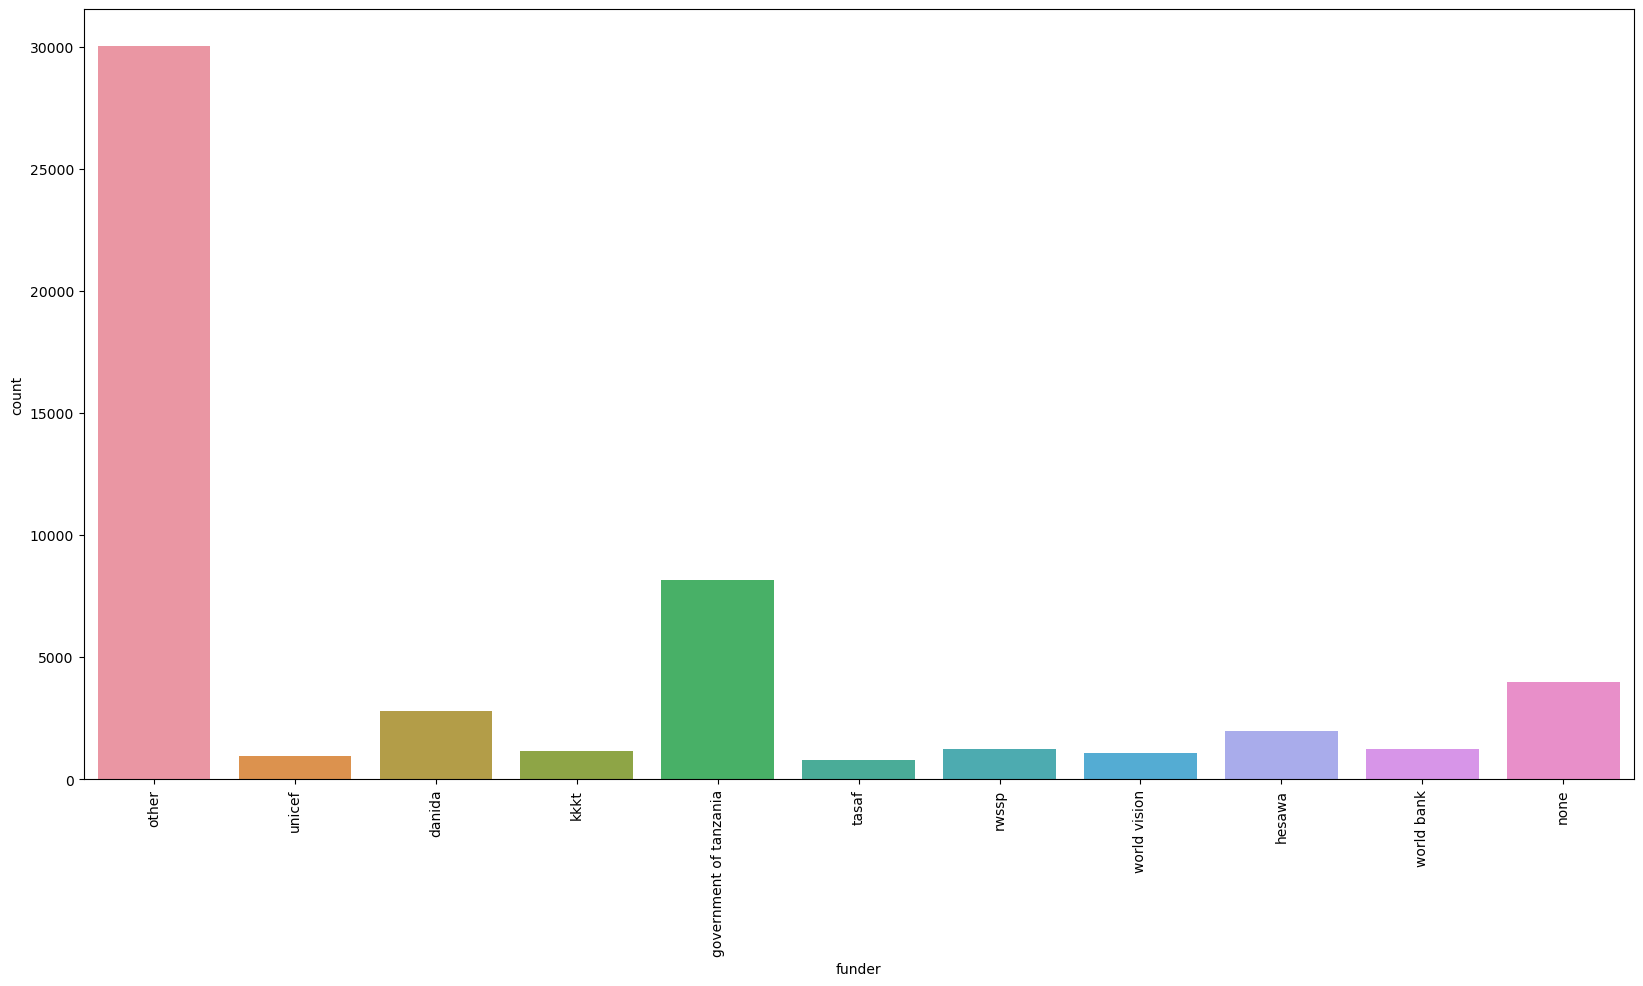

In [101]:
scjpnutils.analyze_distributions(
    X_train_funder_transformed__insig_replaced, 
    'X_train_funder_transformed__insig_replaced', 
    'funder'
);

<p><br><br>

### Feature grouping *funder* analysis Summary

There is obviously only one feature in this group: **funder**.

As a high-cardinality categorical, there are many possible paths to take with this feature (in the config file).

All possible options for the **funder** feature are:

0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
1. Target-encode it
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
    4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
2. `TF-IDF KMeans` Classify it - **since this results in numeric labels, the result MUST be target-encoded**
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
    4. Leave-One-Out target encoding with `nan` values left as is  
3. `TF-IDF` Normalize it (find and replace duplicates using Cosine Similarity of `TF-IDF` vectorized categories - **since this results in numeric labels, the result MUST be target-encoded**
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
    4. Leave-One-Out target encoding with `nan` values left as is 
4. Consider only the *top n* (by frequency) significant categories
5. Drop the feature

**If anything other than the "drop the feature" strategy is used then it must be preceded by `C__required_proprocessing__funder__StrategyTransformer`**.


Again, executing these options is conducted in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

#### Final note:
I saved this comment until the last since all of the above strategy development was necessary for other features.  But, in the end, **does it make sense that *who* the *funder* is will impact mechanical well/pump failure?**  I don't think so.  What might matter is the funding *behavior* - i.e. whether the **funder** keeps a well/pump financed or not.  This information is actually captured with the *payment_frequency_class* feature group.  So, intuitively speaking, **probably the best strategy will be to just drop the *funder* feature since payment *behavior* (which could have an effect on well/pump failure) is captured by features in the *payment_frequency_class* feature group**.

So does that mean all the effort put into strategy development above was a waste?  NOT AT ALL since we now have those strategies encapsulated so that they can be applied to other features that DO need them - e.g. **installer**.

Let's move on to feature grouping <b>gps_height</b>.

<p><br><br>

In [102]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'gps_height', X_train, 'X_train')

#### Feature Analysis: *gps_height*

It has no null/missing values.

Having a small ratio of values, <b>gps_height</b> is likely categorical-ordinal, possibly continuous.

Let's have a look at its value counts.

In [103]:
X_train.gps_height.value_counts()

 0       18452
-15         54
-16         51
-20         50
 1290       48
         ...  
 2029        1
 2560        1
 2391        1
 2333        1
 2233        1
Name: gps_height, Length: 2415, dtype: int64

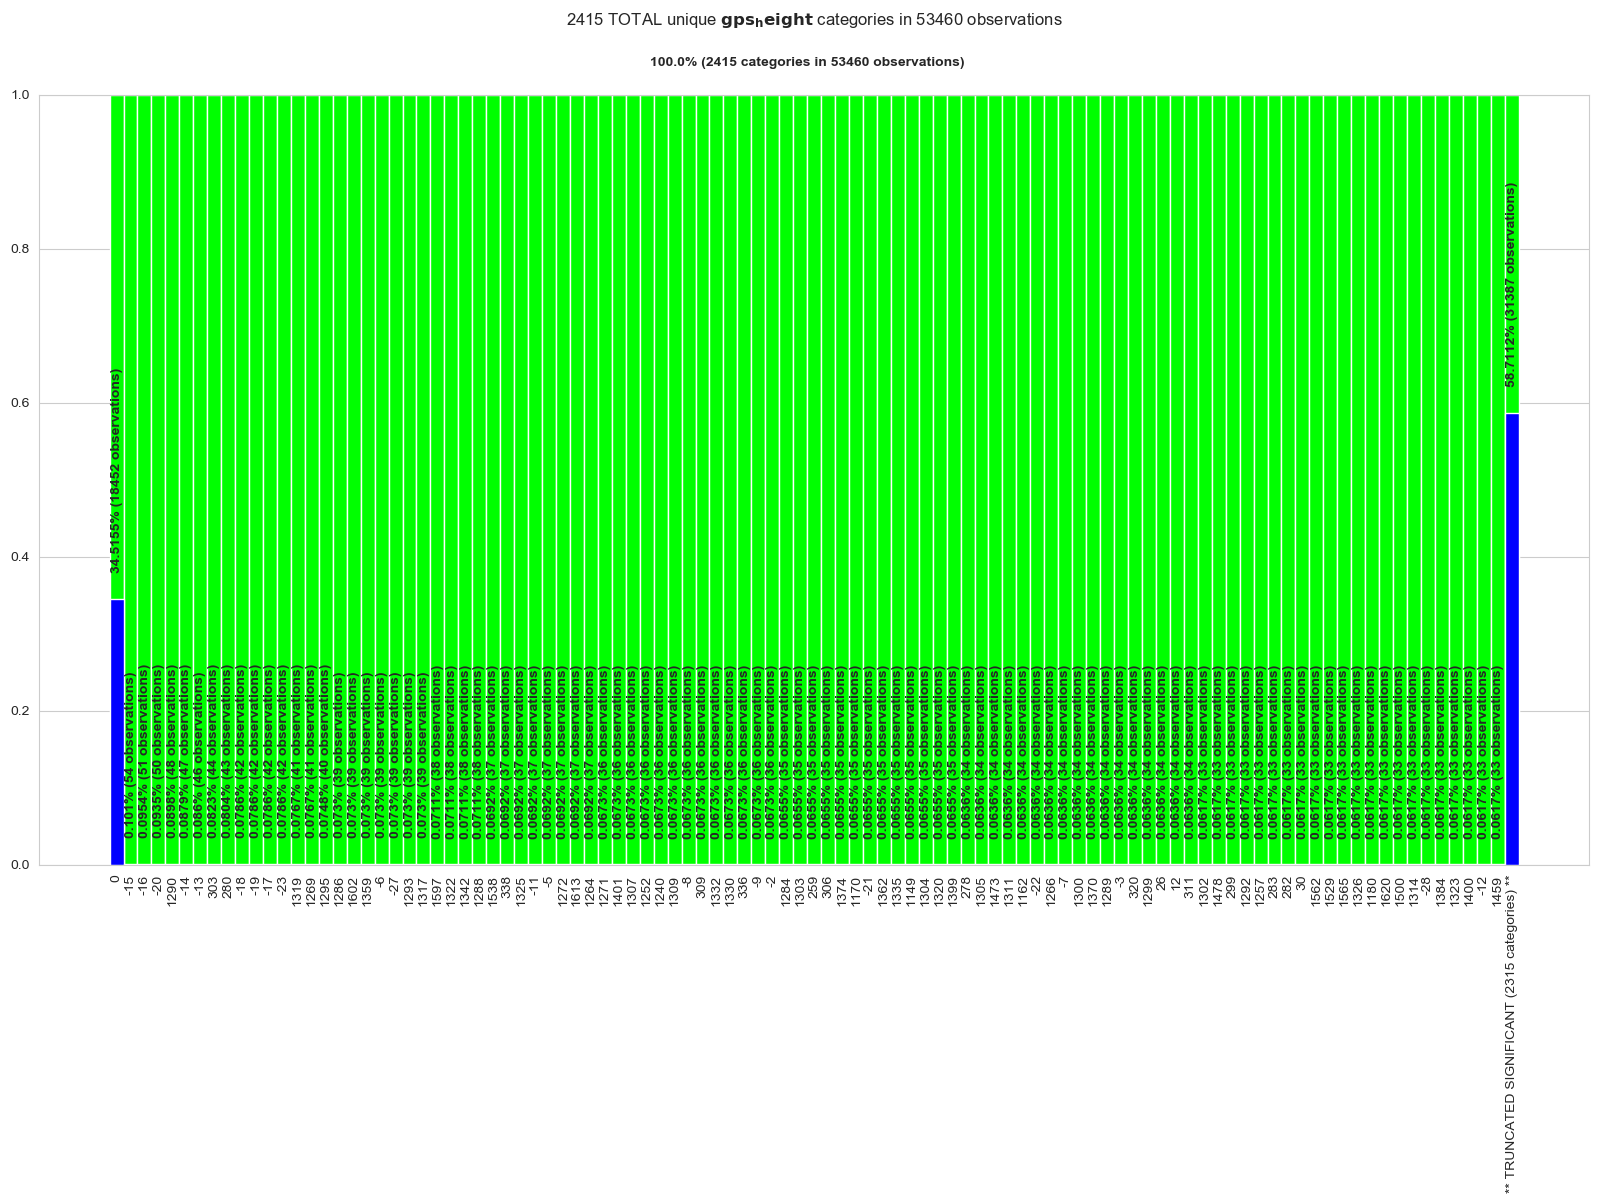

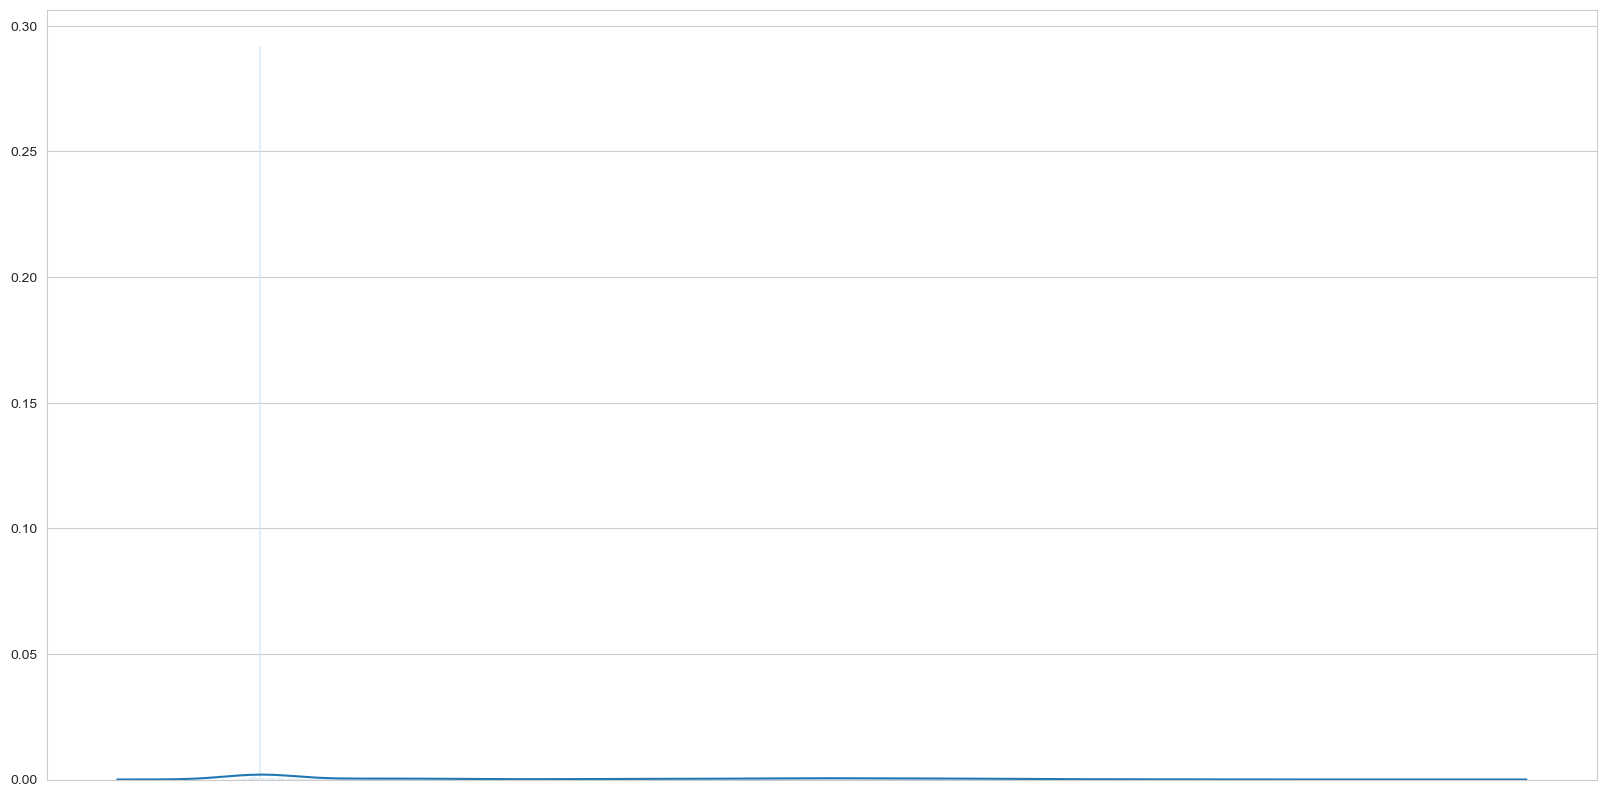

In [104]:
scjpnutils.analyze_distributions(
    X_train, 
    'X_train', 
    'gps_height'
);

Now let's consider the possibility that <b>gps_height</b> is continuous and then let's look at its outliers if this is so.

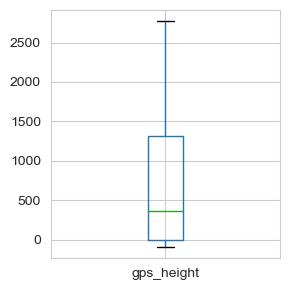

In [105]:
scjpnutils.analyze_outliers_detailed(
    X_train, 
    'X_train', 
    'gps_height', 
    top_percentile=34, 
    outlier_ratio_reduction_threshold=.10
);

There is not much going on here.  Whether we treat <b>gps_height</b> as a categorical (ordinal) or continuous, the result is the same since, continuously speaking, it has no outliers.

<p><br><br>

### Feature grouping *gps_height* analysis Summary

There is obviously only one feature in this group: **gps_height**.

The possible strategies we may take are very similar those we had for the **amount_tsh** feature but we don't admit the r*eplace-0-with-nan* strategy (or any of the other outliers-replacement strategies) since there are no apparent outliers in **gps_height**.

1. Leave the feature as is (do nothing, no transformations whatsoever)
2. Target-encode it - this feature *appears* to be categorical (but ordinal); since, if categorical, it is ordinal, we might consider that the size between values is not properly mathematically meaningful; if this is the case, target encoding could help this in modeling
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values are left as is
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    4. Leave-One-Out target encoding with `nan` values left as is
3. Drop the feature 

As this feature is numeric and it has no apparent outliers, there is no *required* preprocessing in order to execute any of the above strategies.

<p><br>

From the preceding analysis, it looks as though the best option to take is the "leave it as is" strategy.

NOTE: There was no new `StrategyTransformer` development required as we already have all that is necessary to execute the above options in the [prepreprocessing.ipynb](prepreprocessing.ipynb) notebook.

Let's move on to feature grouping <b>installer</b>.

<p><br><br>

In [106]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'installer', X_train, 'X_train')

#### Feature Analysis: *installer*

The first thing we notice is that there appears to be quite a bit of overlap in values between <b>funder</b> and <b>installer</b>.  That is not to say that data is duplicated since we haven't seen whether or not values are similar for a given single observation.  But let's finish our initial commentary based on high-level value analysis.

There are a fair amount of null/missing values.

Being an object with a small percentage of unique values, this feature is likely categorical.

Let's have a look at its value counts that aren't null/missing.

In [107]:
X_train.installer.value_counts()

DWE                 15636
Government           1645
RWE                  1084
Commu                 961
DANIDA                944
                    ...  
Nyamwanji               1
Rudri                   1
Sua                     1
Pentecost church        1
Mashaka M               1
Name: installer, Length: 2034, dtype: int64

With <b>installer</b>, we seem to suffer from more or less the same kinds of feature deficits as we did with <b>funder</b>.  So we take a similar approach.

First we need to handle those null/missing values.

Like we did with <b>funder</b>, let's see if <b>installer</b> contains common "none" type words.

But first we must impute lcase.  We will use our existing `C__impute_lcase__StrategyTransformer` to do this.

In [108]:
impute_lcase_transformer__installer = scjpnstrattransformers.C__impute_lcase__StrategyTransformer('installer', pipeline_data_preprocessor=None, verbose=True)
X_train_installer_lcase = impute_lcase_transformer__installer.fit_transform(X_train)

# finally, check to see if there is an appropriate existing value to indicate null - e.g. 'none', 'unknown', 'not known', etc.
scjpnutils.index_of_values(X_train_installer_lcase, 'X_train_installer_lcase', 'installer', ['none', 'unknown', 'not known'])

strategy "impute lower-case transform: installer" transformation is COMPLETE!


(array([ 2184,  3135,  5875,  8986, 11753, 19746, 20229, 22971, 23089,
        33198, 33743, 35737, 37800, 38987, 39735, 40262, 49240, 49728,
        50006, 50242, 50421, 50452, 50487, 50745, 51141, 51290, 51424,
        51544, 51547, 51549, 51625, 52152, 52406, 52731, 52982, 53129,
        53263]),
 array(['not known', 'unknown'], dtype=object))

Unlike <b>funder</b>, <b>installer</b> does NOT have a "none" category.

But exactly like <b>funder</b>, for <b>installer</b> there are also multiple values that represent an unknown <b>installer</b> - values are "unknown" and "not known" - let's replace one with the other.

And exactly like <b>funder</b>, for <b>installer</b>, we will replace "not known" with "unknown".

But, again, we need to handle null/missing values first.  Even though <b>installer</b> doesn't have an existing "none" category, we will introduce it and use it as the value replacement for null/missing values.

We also noticed that **installer**, like **funder**, has some "weird" values that we will map to "none".  Let's formally find all "weird" values...

In [109]:
scjpnutils.find_weird_vals(X_train_installer_lcase[['installer']], 'X_train_installer_lcase <i>installer</i>')

installer:
	'0' is weird (according to weird-value regex: '\b[^a-zA-Z]+\b')



{'installer': ['0']}

Now we have what we need to map all missing/null and so-called values to "none".  Again, we will make use of `C__value_replacement__StrategyTransformer`.

In [110]:
missing_value_replacement_transformer__installer = scjpnstrattransformers.C__value_replacement__StrategyTransformer(
    'installer', 
    [
        {'missing_values': np.nan, 'strategy': 'constant', 'fill_value': eda_config['missing_string_value_replacement']},
        {'missing_values': '0', 'strategy': 'constant', 'fill_value': eda_config['missing_string_value_replacement']},
        {'missing_values': '-', 'strategy': 'constant', 'fill_value': eda_config['missing_string_value_replacement']}
    ],
    pipeline_data_preprocessor=None, 
    verbose=True  
)
X_train_installer_lcase_nans_replaced = missing_value_replacement_transformer__installer.fit_transform(X_train_installer_lcase)

scjpnutils.analyze_values(
    X_train_installer_lcase_nans_replaced[['installer']], 
    'X_train_installer_lcase_nans_replaced <i>installer</i>', 
    standard_options_kargs={'sort_unique_vals':True}
);

strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" transformation is COMPLETE!


Again, like we did for **funder**, we must derive a specialized version of `C__value_replacement__StrategyTransformer` for **installer** so that it can be deployed via the config.

For **installer**, the above has been captured in the `C__missing_value_imputer__installer__StrategyTransformer` class.

And now "unknown" and "not known" values...

In [111]:
not_known_literal_value_replacement_transformer__installer = scjpnstrattransformers.C__value_replacement__StrategyTransformer(
    'installer',
    [{'missing_values': 'not known', 'strategy': 'constant', 'fill_value': 'unknown'}],
    pipeline_data_preprocessor=None,
    verbose=True
)

X_train_installer_transformed = not_known_literal_value_replacement_transformer__installer.fit_transform(X_train_installer_lcase_nans_replaced)

scjpnutils.index_of_values(X_train_installer_transformed, 'X_train_installer_transformed', 'installer', ['not known'])

strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": "not known",
            "strategy": "constant",
            "fill_value": "unknown"
        }
    ]
}
strategy "replace values for feature: installer" transformation is COMPLETE!


(array([], dtype=int64), array([], dtype=object))

<p><br><br>

### Strategy Development: *Execute all required preprocessing transformations on installer*

#### Concept

The concept follows from all preceding transformations in this section.

All of the above preprocessing steps represent minimal "required" steps to do further processing.  Any additional preprocessing must always follow the above preprocessing.  Therefore, all steps above have been encapsulated within a single class: `C__required_proprocessing__installer__StrategyTransformer`.  

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__installer__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the preceding discussion.

Now let's get an accurate view of the distribution of "unique" values.  

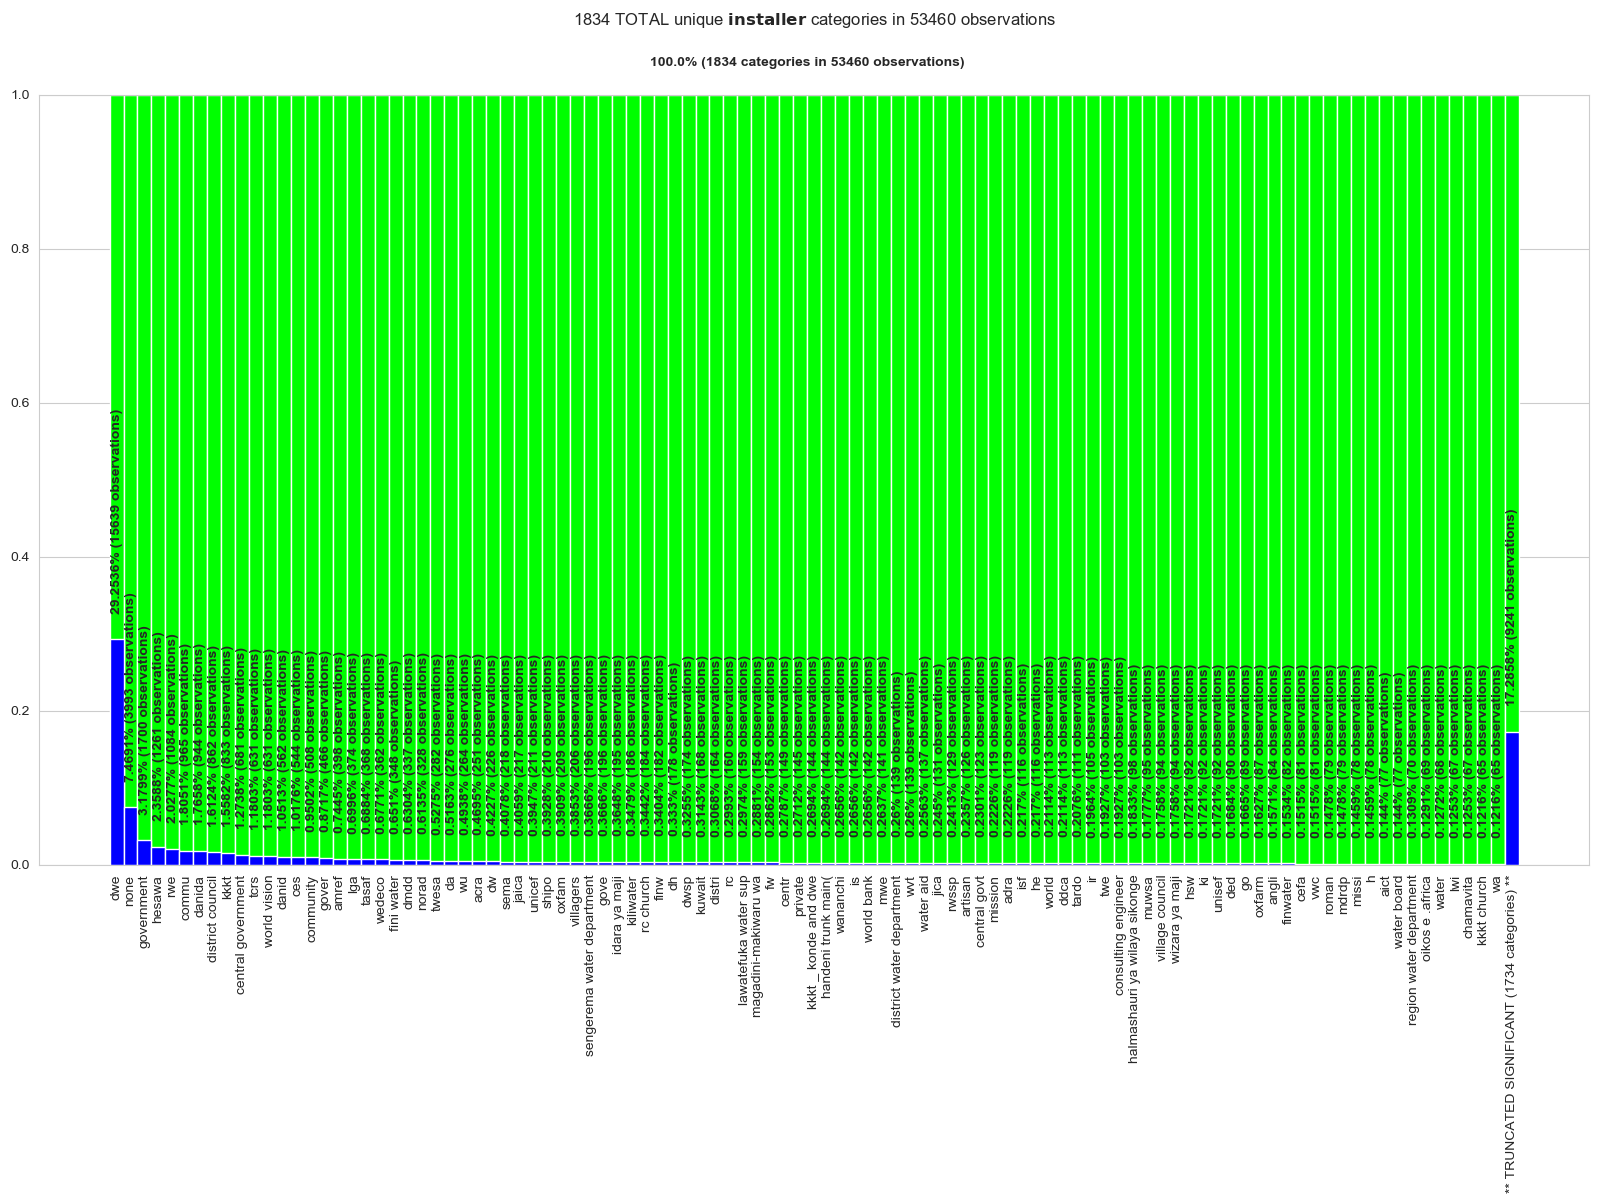

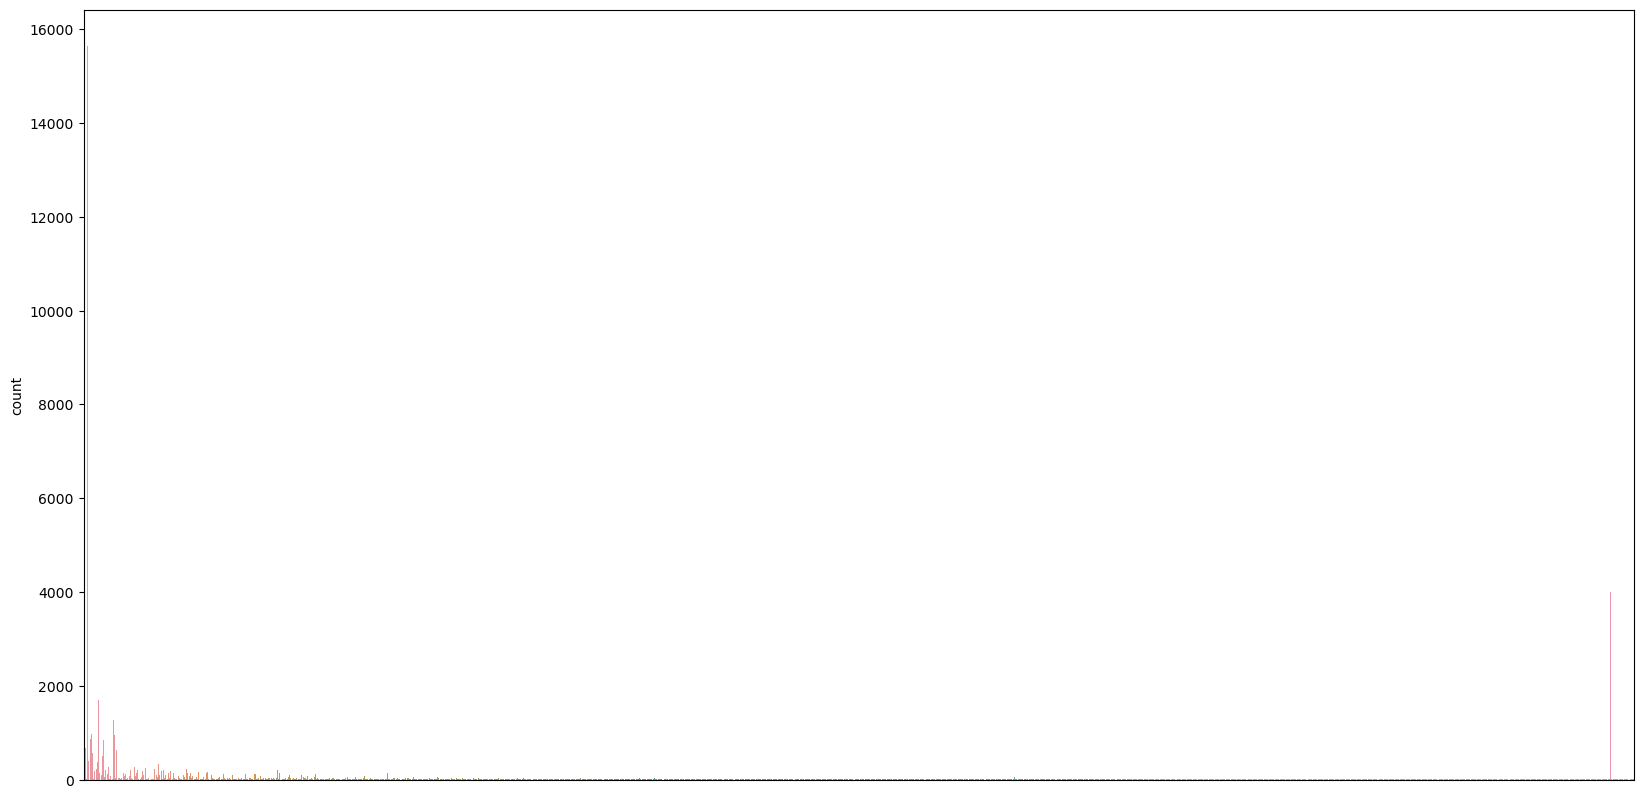

In [112]:
scjpnutils.analyze_distributions(
    X_train_installer_transformed, 
    'X_train_installer_transformed', 
    'installer'
);

Again, similar to <b>funder</b>, <b>installer</b> supposedly has A LOT of "unique" categories (high cardinality)!  Certainly too many to One-Hot Encode.

Let's see how bad duplication is and use this as a guide as to whether or not we ought to consider employing `C__tfidf_kmeans_classify__StrategyTransformer`.

In [113]:
scjpnutils.analyze_non_alphanumeric_strings(X_train_installer_transformed[['installer']], 'X_train_installer_transformed <i>installer</i>');

Wow!  The "duplication" situation seems to be just as bad for <b>installer</b> as it was for <b>funder</b>!

Thus we have derived `C__tfidf_kmeans_classify__installer__StrategyTransformer` (from `C__tfidf_kmeans_classify__StrategyTransformer`) as a preprocessing option (to be done in [preprocessing.ipynb](preprocessing.ipynb)).  Remember that **whenever we use `C__tfidf_kmeans_classify__StrategyTransformer`, we MUST follow it up with Target Encoding - i.e. chain one of the classes derived from `C__target_encode__StrategyTransformer`**.  Also, again, we ought to drop the original feature since `C__tfidf_kmeans_classify__StrategyTransformer` will not implicitly drop it.

As a high-cardinality categorical, we of course additionally consider the `C__top_n_significance__StrategyTransformer` strategy developed in the **funder** section.

<p><br><br>

### Feature grouping *installer* analysis Summary

There is obviously only one feature in this group: **installer**.

For the **installer** feature, we have the same strategic options to consider as we did the **funder** feature.

As a high-cardinality categorical, all possible strategic options are:

0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
1. Target-encode it
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
    4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
3. `TF-IDF KMeans` Classify it - **since this results in numeric labels, the result MUST be target-encoded**
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
    4. Leave-One-Out target encoding with `nan` values left as is  
3. `TF-IDF` Normalize it (find and replace duplicates using Cosine Similarity of `TF-IDF` vectorized categories - **since this results in numeric labels, the result MUST be target-encoded**
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
    4. Leave-One-Out target encoding with `nan` values left as is 
4. Consider only the *top n* (by frequency) significant categories
5. Drop the feature

**If anything other than the "drop the feature" strategy is used then it must be preceded by `C__required_proprocessing__installer__StrategyTransformer`**.


Again, executing these options is conducted in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

#### Final note:
Unlike **funder**, whoever installed the well/pump seems intuitively like it would be a very important feature in predicting its failure.  Thus, the "drop the feature" strategy is likely not going to be the best option.  But we will explore this in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to feature grouping <b>gps_coordinates</b>.

<p><br><br>

In [114]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'gps_coordinates', X_train, 'X_train')

Since these really form ordered pairs, it doesn't make much sense to examine them separately.

Notice that there is a zero value in <b>longitude</b>.

In [115]:
X_train_with_0_lon = X_train[X_train['longitude']==0][['latitude', 'longitude']]
X_train_with_0_lon

latitude  longitude
id                            
52060 -2.000000e-08        0.0
38213 -2.000000e-08        0.0
66434 -2.000000e-08        0.0
69593 -2.000000e-08        0.0
36330 -2.000000e-08        0.0
...             ...        ...
69295 -2.000000e-08        0.0
51994 -2.000000e-08        0.0
2386  -2.000000e-08        0.0
6619  -2.000000e-08        0.0
51357 -2.000000e-08        0.0

[1654 rows x 2 columns]

Very interesting!  That definitely looks like a mistake.

In [116]:
X_train_with_0_lon.latitude.unique()

array([-2.e-08])

In [117]:
X_train_with_0_lon.latitude.min()

-2e-08

In [118]:
X_train_with_0_lon.latitude.max() # but does this value occur with any longitude != 0.0?

-2e-08

To me this looks like some sort of floating point/rounding error occurred.

Let's just see if this value for <b>latitude</b> occurs with any <b>longitude</b> other than 0.0.

In [119]:
X_train_with_weird_lat = X_train[(X_train['latitude']==-2.e-08) & (X_train['longitude']!=0.0)][['latitude', 'longitude']]
X_train_with_weird_lat

Empty DataFrame
Columns: [latitude, longitude]
Index: []

It is, therefore, clear that <b>latitude</b> value -2e-08 should be replaced by 0.0.

In [120]:
X_train.longitude.min()

0.0

In [121]:
X_train.longitude.max()

40.34519307

So this is an easy fix.  We require no new strategy development.  We will use the existing `C__value_replacement__StrategyTransformer`.

In [122]:
literal_value_replacement_transformer__latitude = scjpnstrattransformers.C__value_replacement__StrategyTransformer(
    'latitude',
    [{'missing_values': -2.e-08, 'strategy': 'constant', 'fill_value': 0.0}],
    pipeline_data_preprocessor=None,
    verbose=True
)

X_train_latitude_transformed = literal_value_replacement_transformer__latitude.fit_transform(X_train)

strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" transformation is COMPLETE!


In [123]:
X_train_latitude_transformed_with_0_lon = X_train_latitude_transformed[X_train_latitude_transformed['longitude']==0][['latitude', 'longitude']]
X_train_latitude_transformed_with_0_lon

latitude  longitude
id                        
52060       0.0        0.0
38213       0.0        0.0
66434       0.0        0.0
69593       0.0        0.0
36330       0.0        0.0
...         ...        ...
69295       0.0        0.0
51994       0.0        0.0
2386        0.0        0.0
6619        0.0        0.0
51357       0.0        0.0

[1654 rows x 2 columns]

In [124]:
X_train_latitude_transformed_with_0_lon.latitude.unique()

array([0.])

In [125]:
X_train_latitude_transformed_with_0_lat = X_train_latitude_transformed[X_train_latitude_transformed['latitude']==0][['latitude', 'longitude']]
X_train_latitude_transformed_with_0_lat

latitude  longitude
id                        
52060       0.0        0.0
38213       0.0        0.0
66434       0.0        0.0
69593       0.0        0.0
36330       0.0        0.0
...         ...        ...
69295       0.0        0.0
51994       0.0        0.0
2386        0.0        0.0
6619        0.0        0.0
51357       0.0        0.0

[1654 rows x 2 columns]

In [126]:
X_train_latitude_transformed_with_0_lat.longitude.unique()

array([0.])

In [127]:
X_train_latitude_transformed_with_0_lat.latitude.min()

0.0

In [128]:
X_train_latitude_transformed_with_0_lat.latitude.max()

0.0

In [129]:
X_train_latitude_transformed.latitude.min()

-11.64944018

In [130]:
X_train_latitude_transformed.latitude.max()

0.0

FIXED!!

<p><br><br>

### Strategy Development: *Execute all required preprocessing transformations on gps_coordinates (feature group)*

#### Concept

The concept follows from all preceding transformations in this section.

All of the above preprocessing steps represent minimal "required" steps to do further processing.  Any additional preprocessing must always follow the above preprocessing.  Therefore, all steps above have been encapsulated within a single class: `C__required_proprocessing__gps_coordinates__StrategyTransformer`.  

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__gps_coordinates__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the preceding discussion.

### Feature grouping *gps_coordinates* analysis Summary

There are two features in the group: **latitude** and **longitude**.

These two features constitute an *ordered pair*.

Thus, if any scaling or translation is done to one, it must be done to the other.

Additionally, as gps coordinates (as opposed to quantitites), it makes no sense to consider outliers for either component.

However, as coordinates, each component forms a *total order*.  Hence, mathematical relationships *may* be established between coordinate components and the target in terms of classification.

Because of this, it makes no sense to Target Encode as a strategy.

Therefore, AS A GROUP (ordered pair), only the following preprocessing options are possible:

1. use the group in model building, in which case `C__required_proprocessing__gps_coordinates__StrategyTransformer` is executed
2. otherwise, the "drop the feature" strategy must be executed for both features in this group

Let's move on to feature grouping <b>wpt_name</b>.

<p><br><br>

In [131]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'wpt_name', X_train, 'X_train')

#### Feature Analysis: *wpt_name*

There is almost no point analyzing this feature since it is fairly obvious this just another kind of identifier.

But let's give it its due diligence.

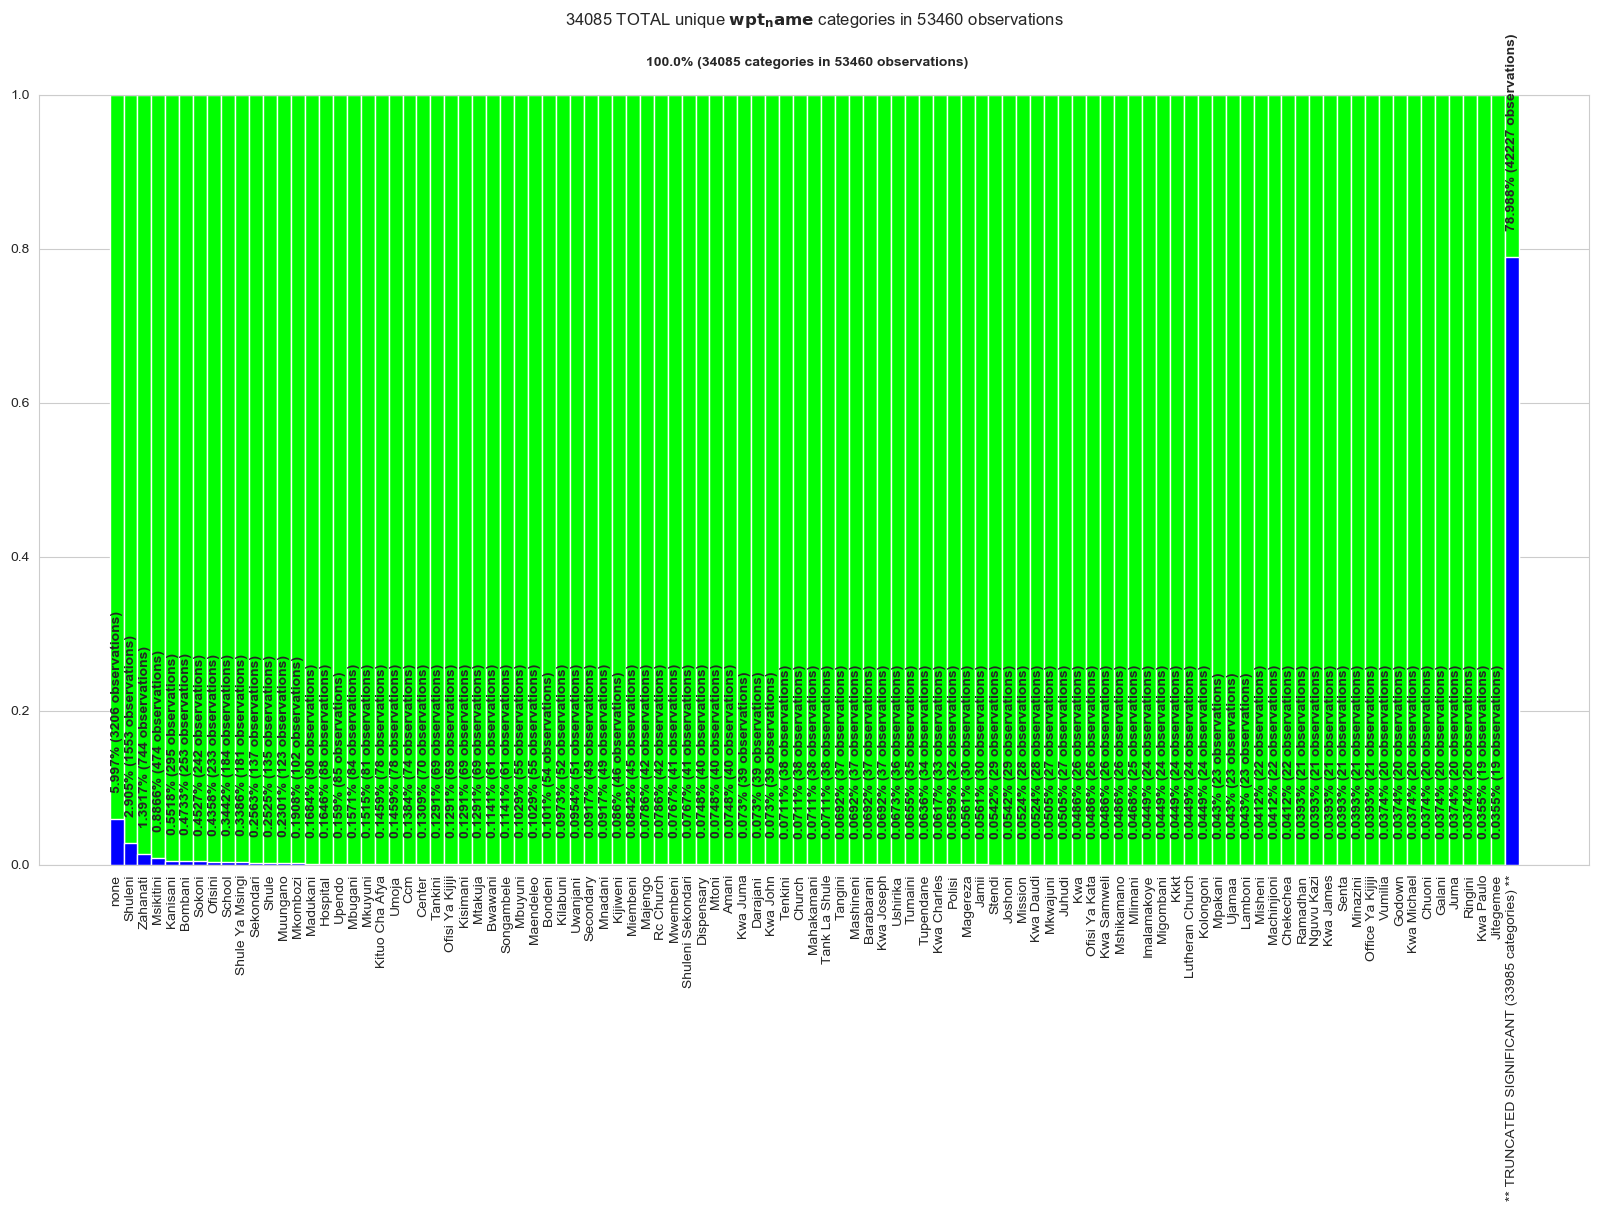

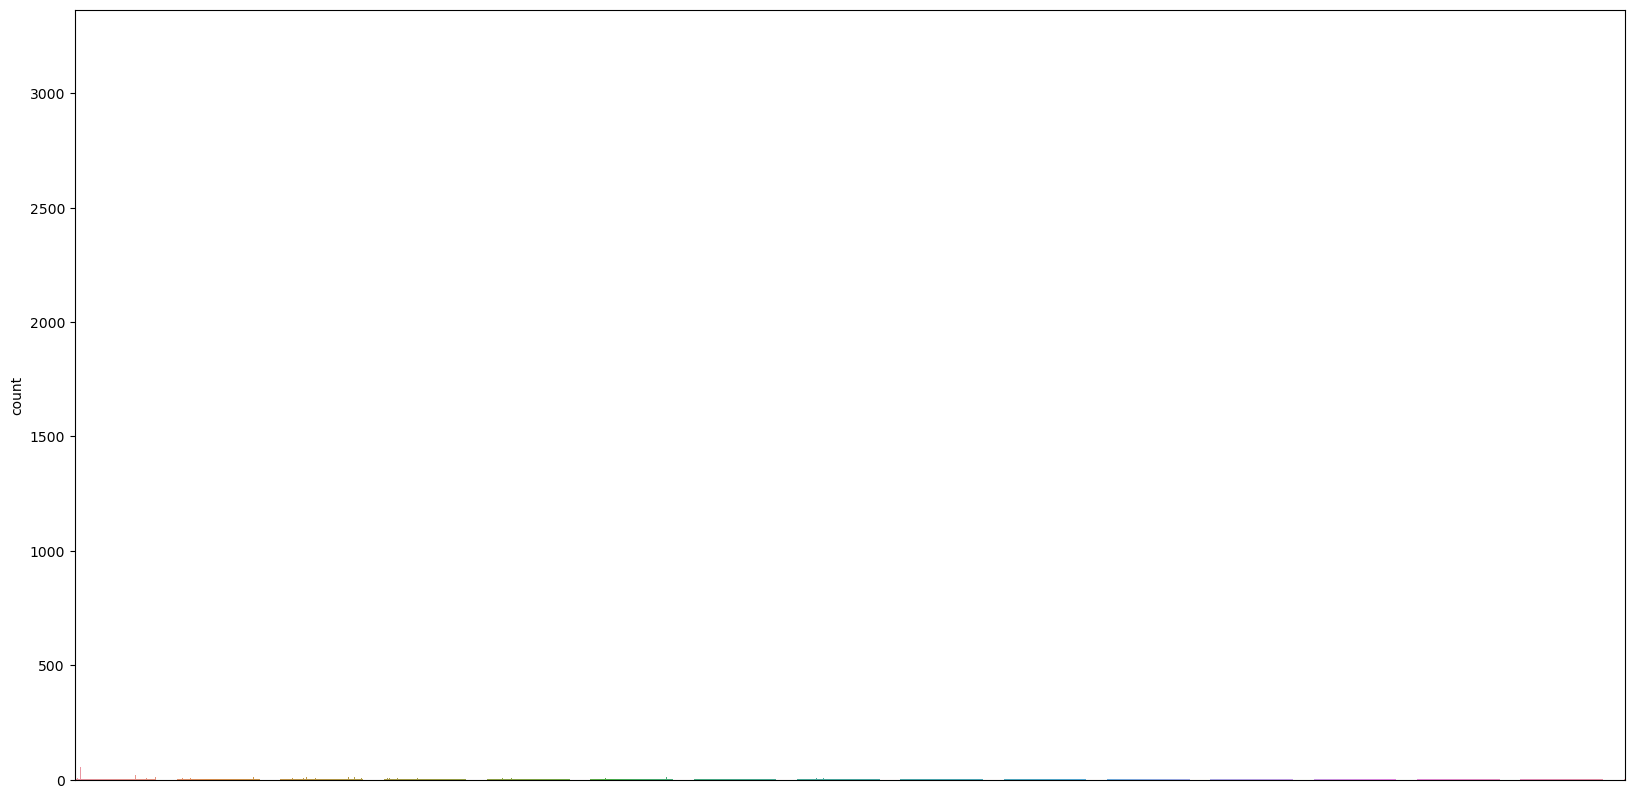

In [132]:
scjpnutils.analyze_distributions(
    X_train, 
    'X_train', 
    'wpt_name'
);

Again, we'll employ `analyze_non_alphanumeric_strings` to get a feel for "duplication" status.  If we see little duplication or the values appear to truly be unique names, then we should be able to write this feature off as a quasi-identifier.

In [133]:
scjpnutils.analyze_non_alphanumeric_strings(X_train[['wpt_name']], 'X_train <i>wpt_name</i>');

<p><br><br>

### Feature grouping *wpt_name* analysis Summary

From the samples above, it seems pretty clear that this feature is indeed a quasi-indentifier.

We're taking a shortcut here since we are rather certain that **wpt_name** is a quasi-identifier.

This will save us a lot of work by not having to create the associated `StrategyTransformer` classes required to try out different options via the config file in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Why do that if we are certain it is unnecessary?

Therefore, we will always use the "drop the feature" strategy for **wpt_name**.

Let's move on to feature grouping <b>num_private</b>.

<p><br><br>

In [134]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'num_private', X_train, 'X_train')

#### Feature Analysis: *num_private*

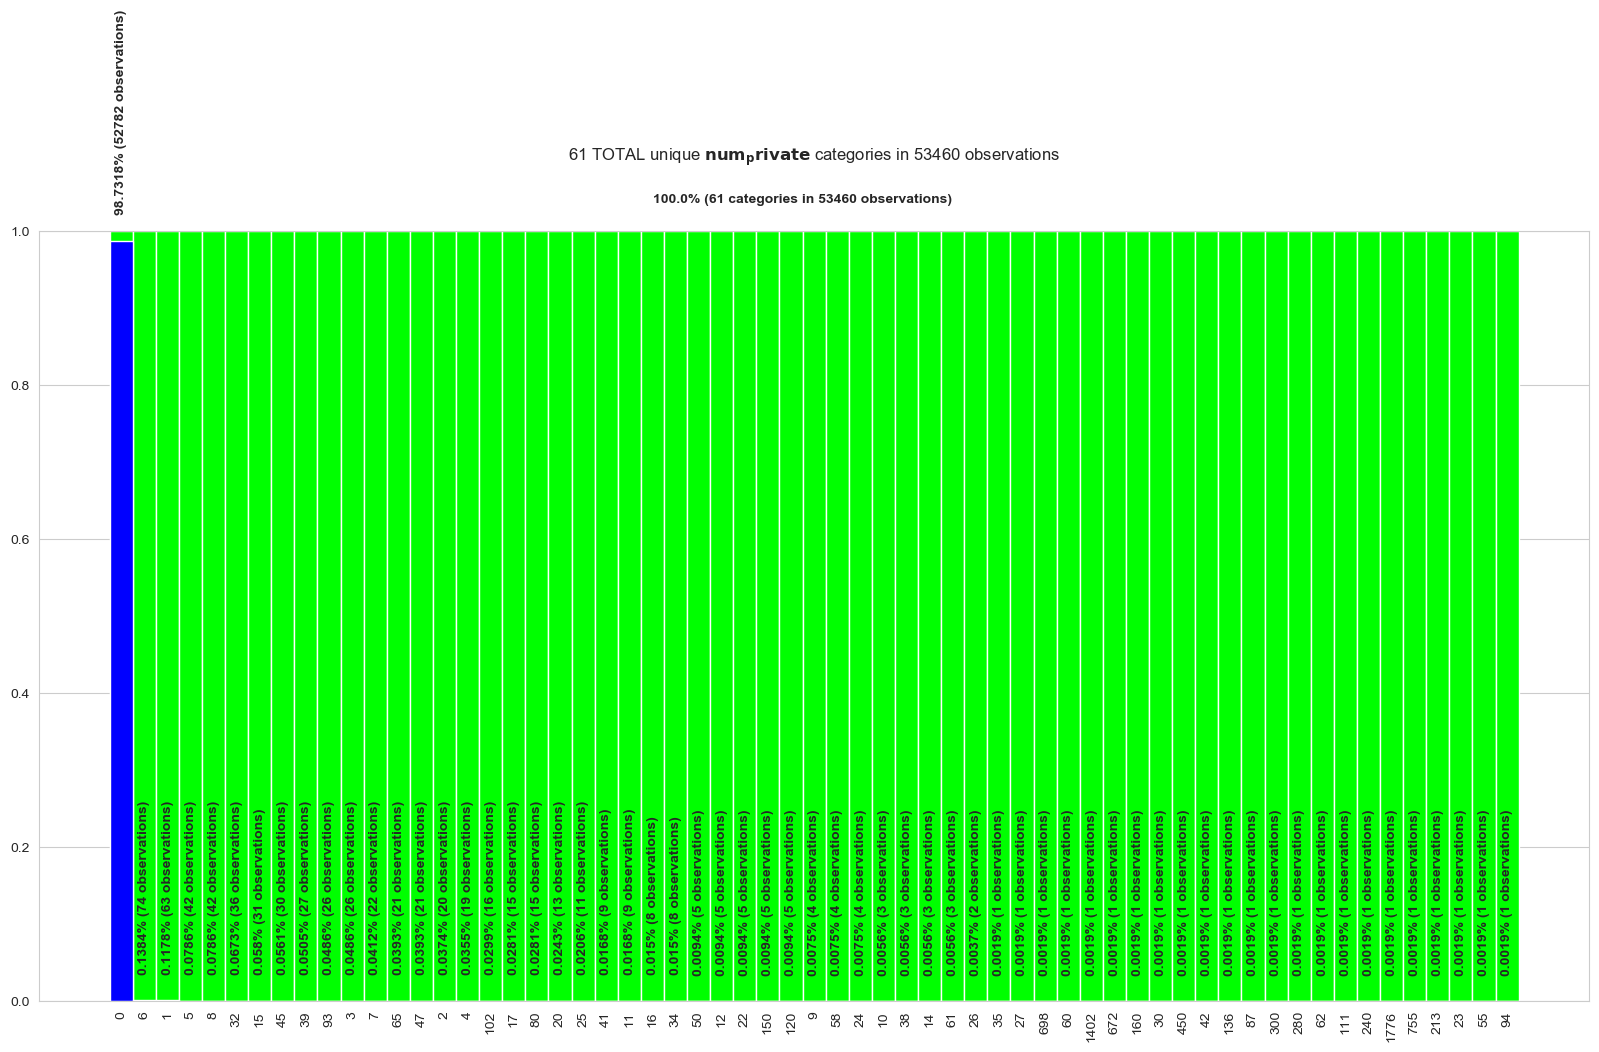

/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


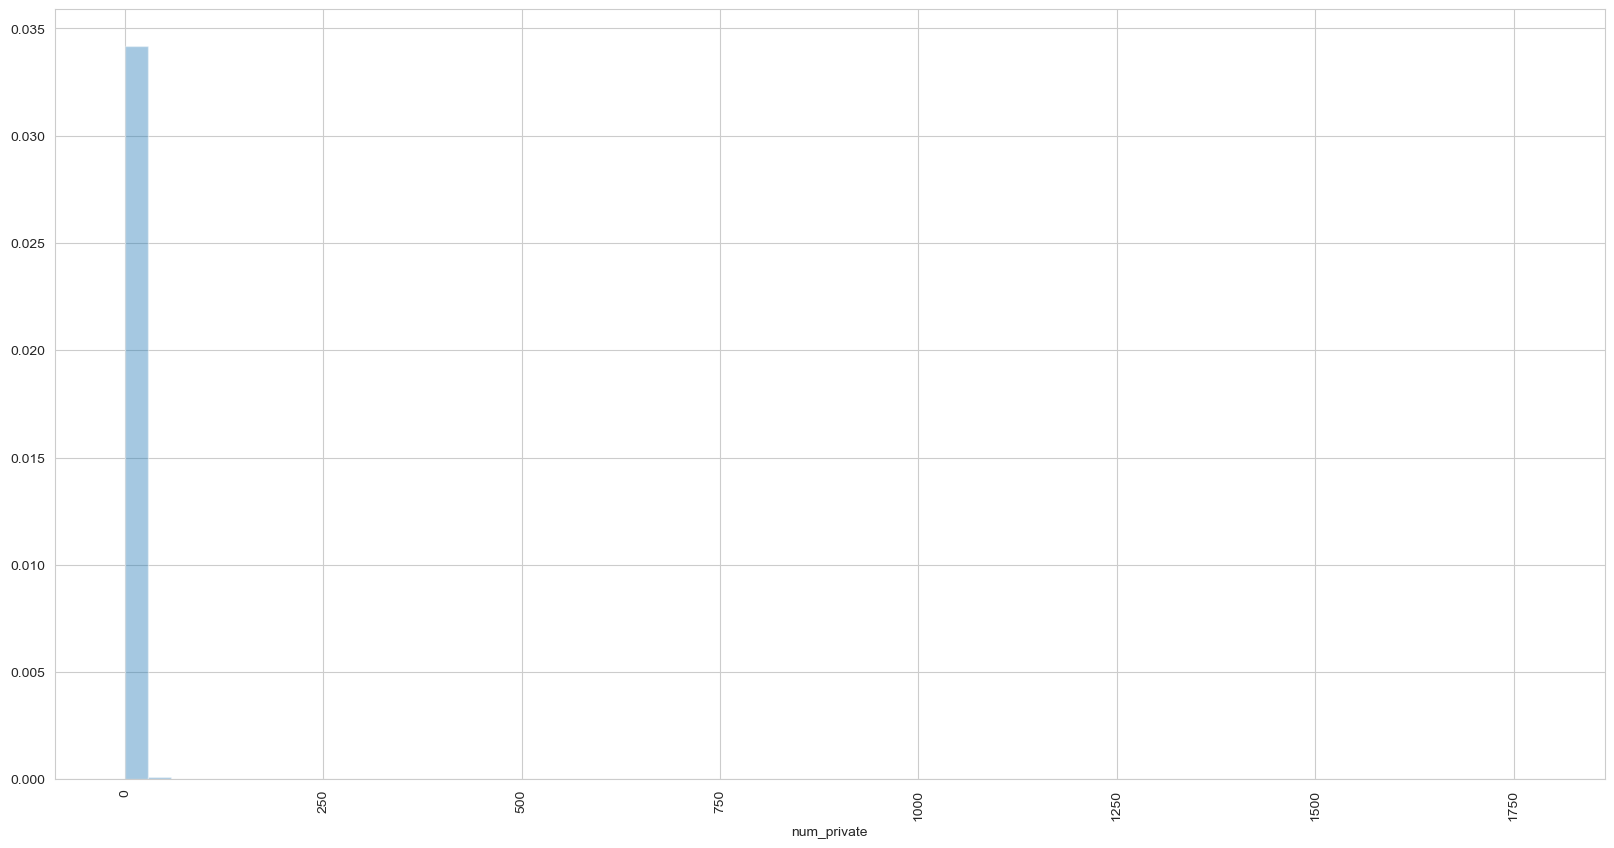

In [135]:
scjpnutils.analyze_distributions(
    X_train, 
    'X_train', 
    'num_private'
);

<p><br><br>

### Feature grouping *num_private* analysis Summary

The above analysis indicates that 1 single value (0) constitutes more than 98% of the population of labeled observations!

We will always use the "drop the feature" strategy for **num_private**.

Let's move on to feature grouping <b>basin</b>.

<p><br><br>

In [136]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'basin', X_train, 'X_train')

#### Feature Analysis: *basin*

It has no null/missing values.

It is not high-cardinality relative to, for example, **installer** or **funder**.

Yet it still has enough unique categories to justify Target-Encoding it.

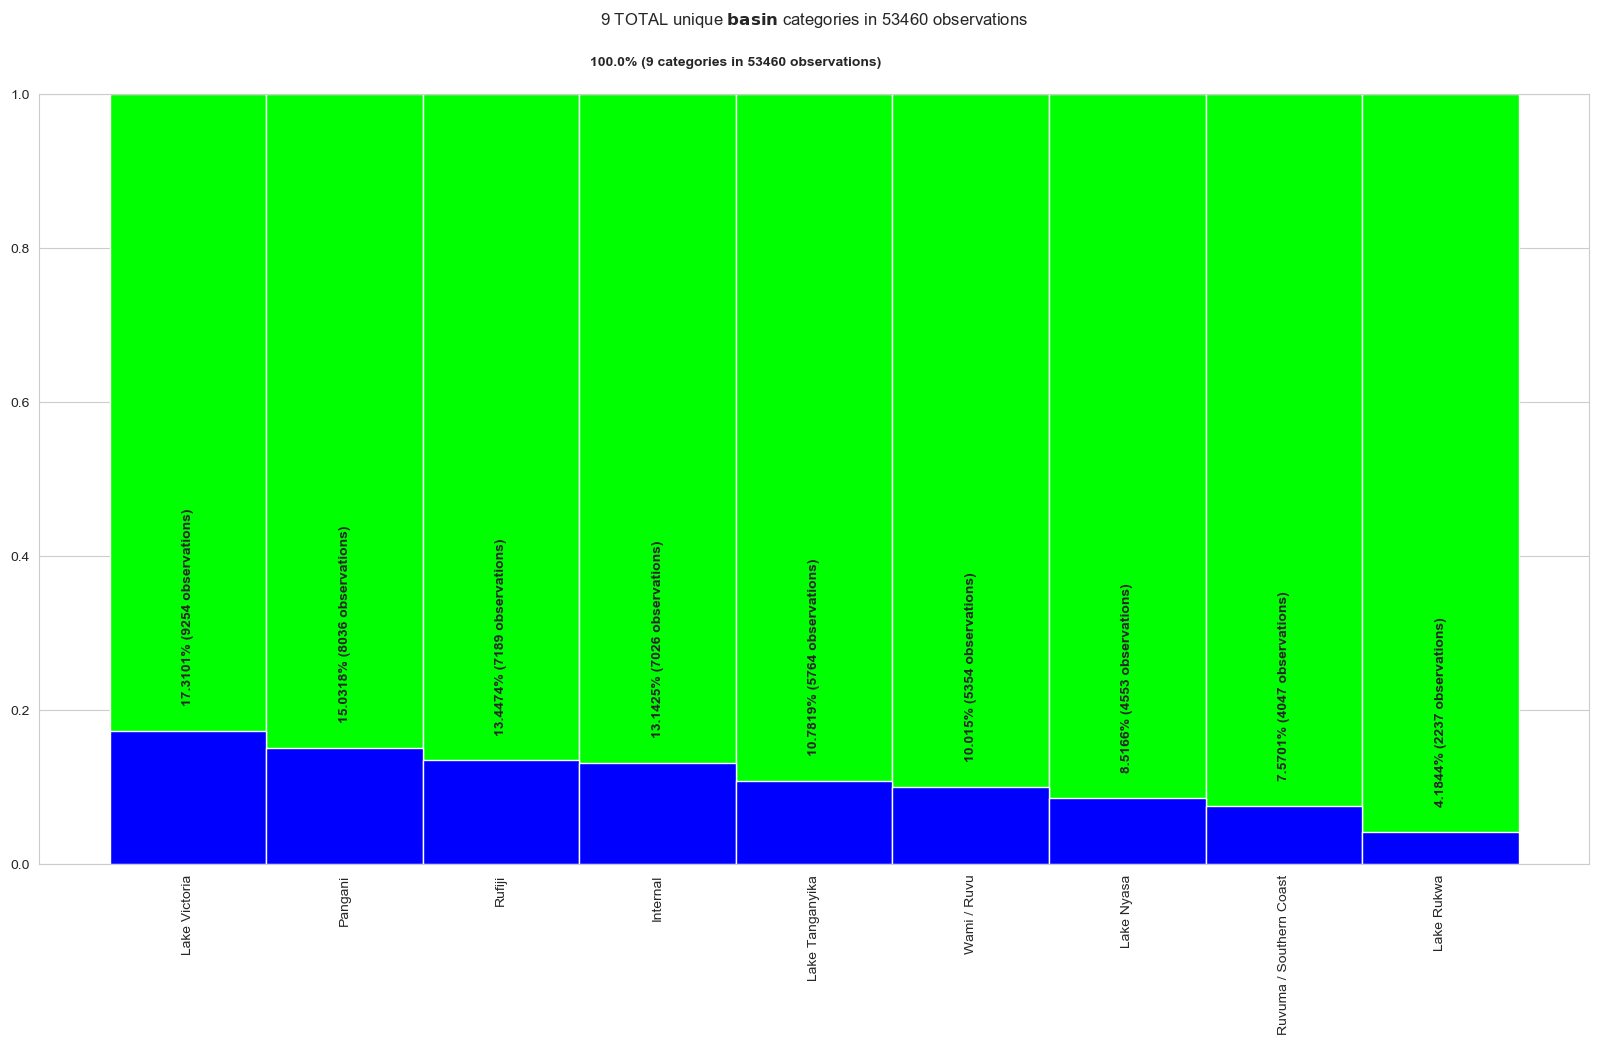

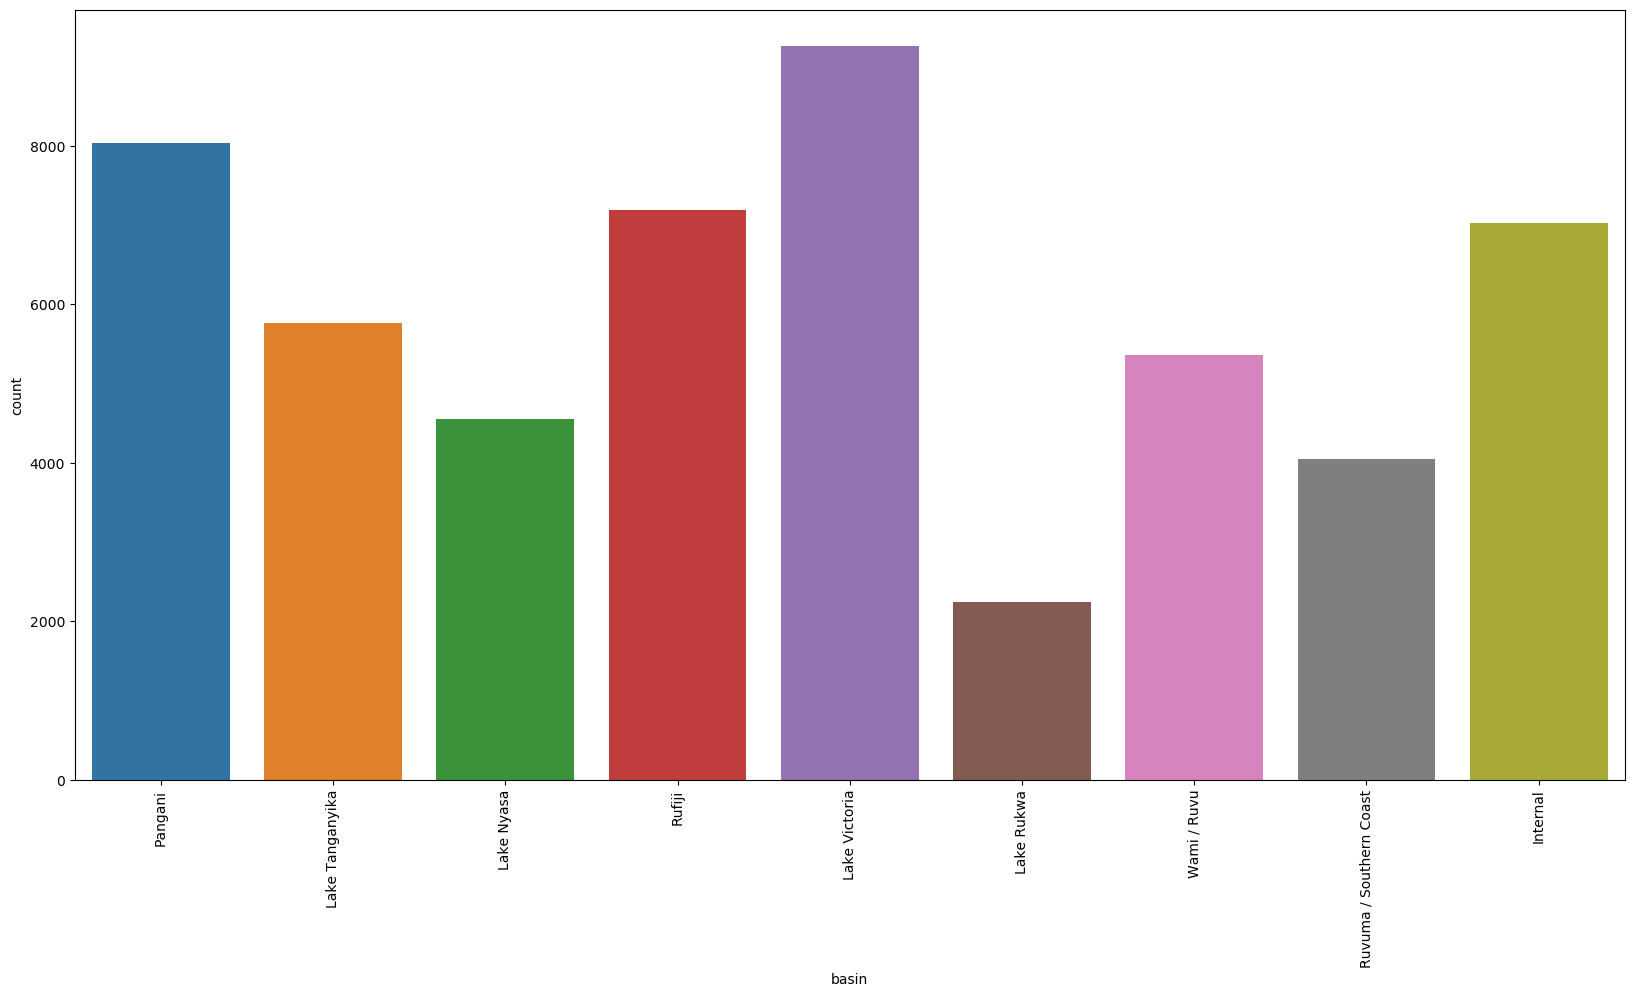

In [137]:
scjpnutils.analyze_distributions(
    X_train, 
    'X_train', 
    'basin'
);

There is nothing really out of the ordinary here.

<p><br><br>

### Feature grouping *basin* analysis Summary

There is obviously only one feature in this group: **basin**.

Since **basin** is a string-categorical, if it is used in the model, it should be Target-Encoded as the other string-categoricals may be.  And this requires the usual string-based preprocessing (which has been encapsulated within `C__required_proprocessing__basin__StrategyTransformer`).

Thus, all possible strategic options are:

0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
1. Target-encode it
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
    4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
2. Drop the feature

**If anything other than the "drop the feature" strategy is used then it must be preceded by `C__required_proprocessing__basin__StrategyTransformer`**.

Let's move on to feature grouping <b>geographic_location</b>.

<p><br><br>

In [138]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'geographic_location', X_train, 'X_train')

#### Feature Analysis: *region_code*

There are no null/missing values.  NICE!

This is clearly a categorical (but not ordinal) variable.  

But since it is categorical (non-ordinal), it should be Target-Encoded if it is used in the model.

Aside from needing to Target-Encode this feature, we should be able to use this feature as is.

But let us continue with analysis to be sure.

Let's have a look at value-counts.

In [139]:
X_train.region_code.value_counts()

11    4772
17    4530
12    4190
3     3918
5     3606
18    2988
19    2746
2     2719
16    2519
10    2381
4     2271
1     2001
13    1883
20    1787
14    1779
15    1638
21    1436
6     1435
80    1123
60     907
90     821
7      726
99     387
9      349
24     289
8      258
40       1
Name: region_code, dtype: int64

Let's have a look at the distribution of "unique" values.  

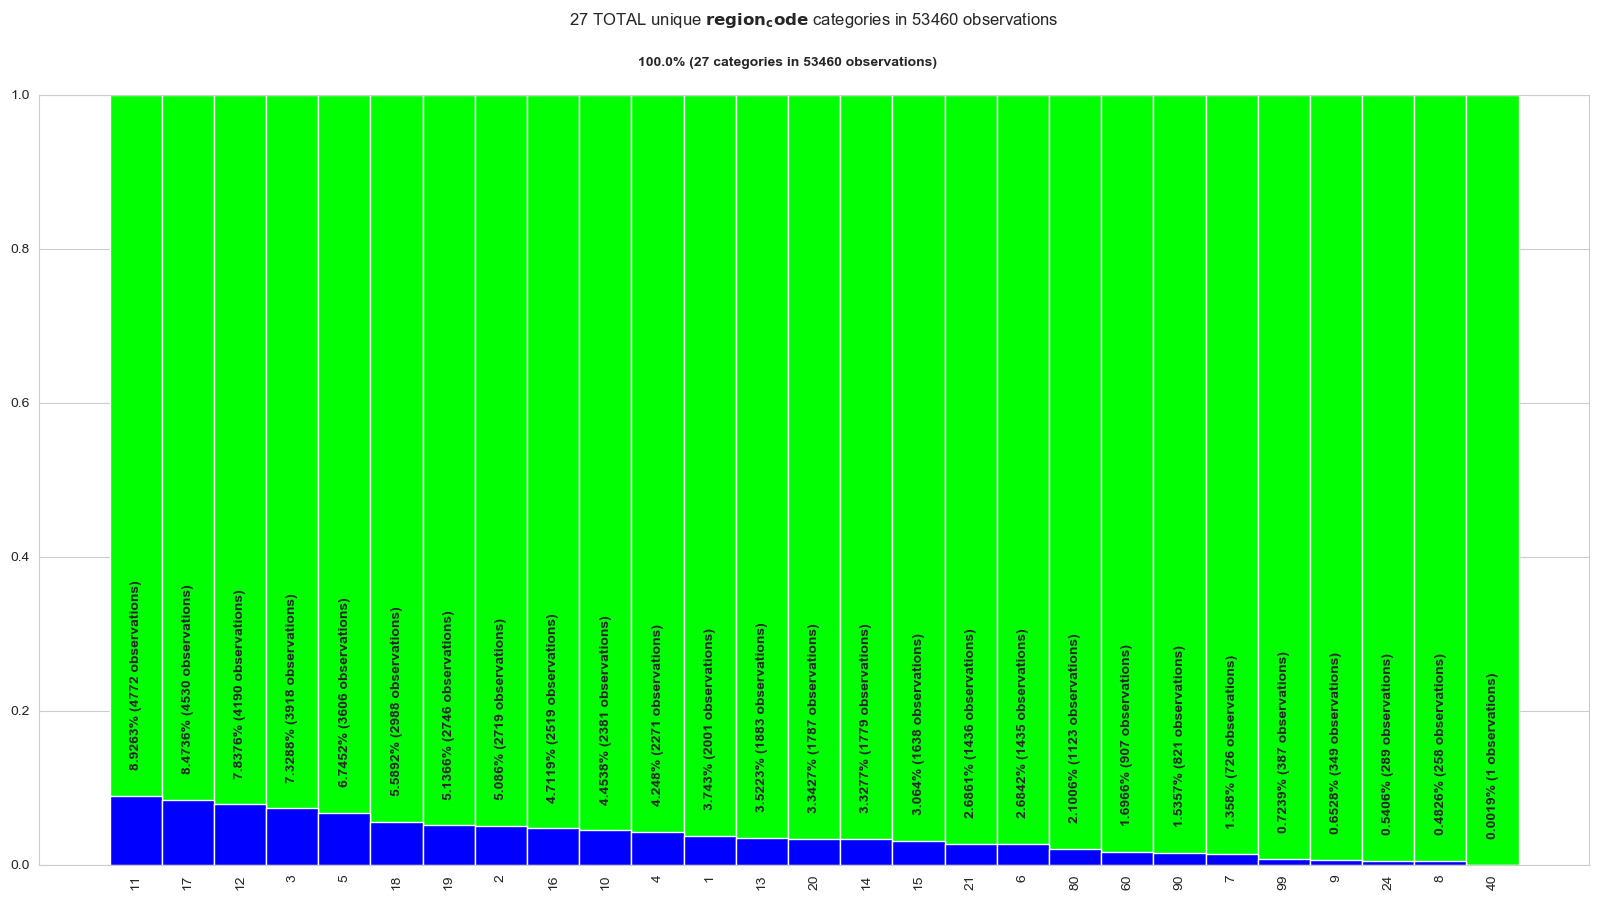

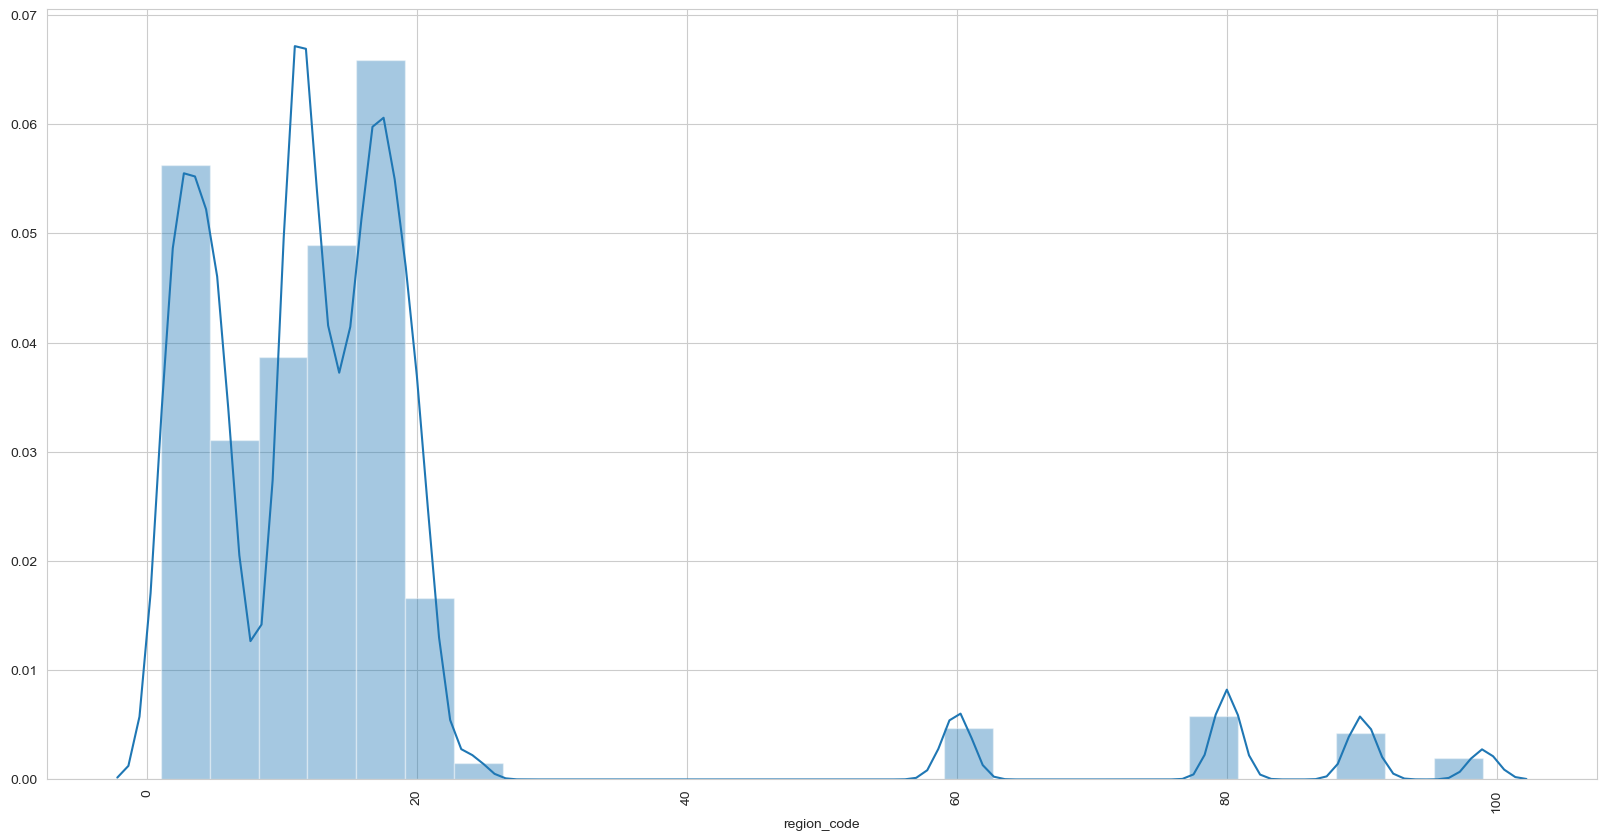

In [140]:
scjpnutils.analyze_distributions(
    X_train, 
    'X_train', 
    'region_code'
);

This feature is good to go.  Remember that if it is used, it must be Target-Encoded.

#### Feature Analysis: *district_code*

As with <b>region_code</b>, <b>district_code</b> has no null/missing values.

This is also clearly a categorical (but not ordinal) variable.  

But since it is categorical (non-ordinal), it should be Target-Encoded if it is used in the model.

Aside from needing to Target-Encode this feature, we should be able to use this feature as is.

Let's have a look at value-counts.

In [141]:
X_train.district_code.value_counts()

1     10979
2     10048
3      9018
4      8077
5      3916
6      3697
7      3014
8       943
30      884
33      787
53      659
43      445
13      355
23      273
63      173
62       99
60       55
0        21
80       11
67        6
Name: district_code, dtype: int64

And its distribution...

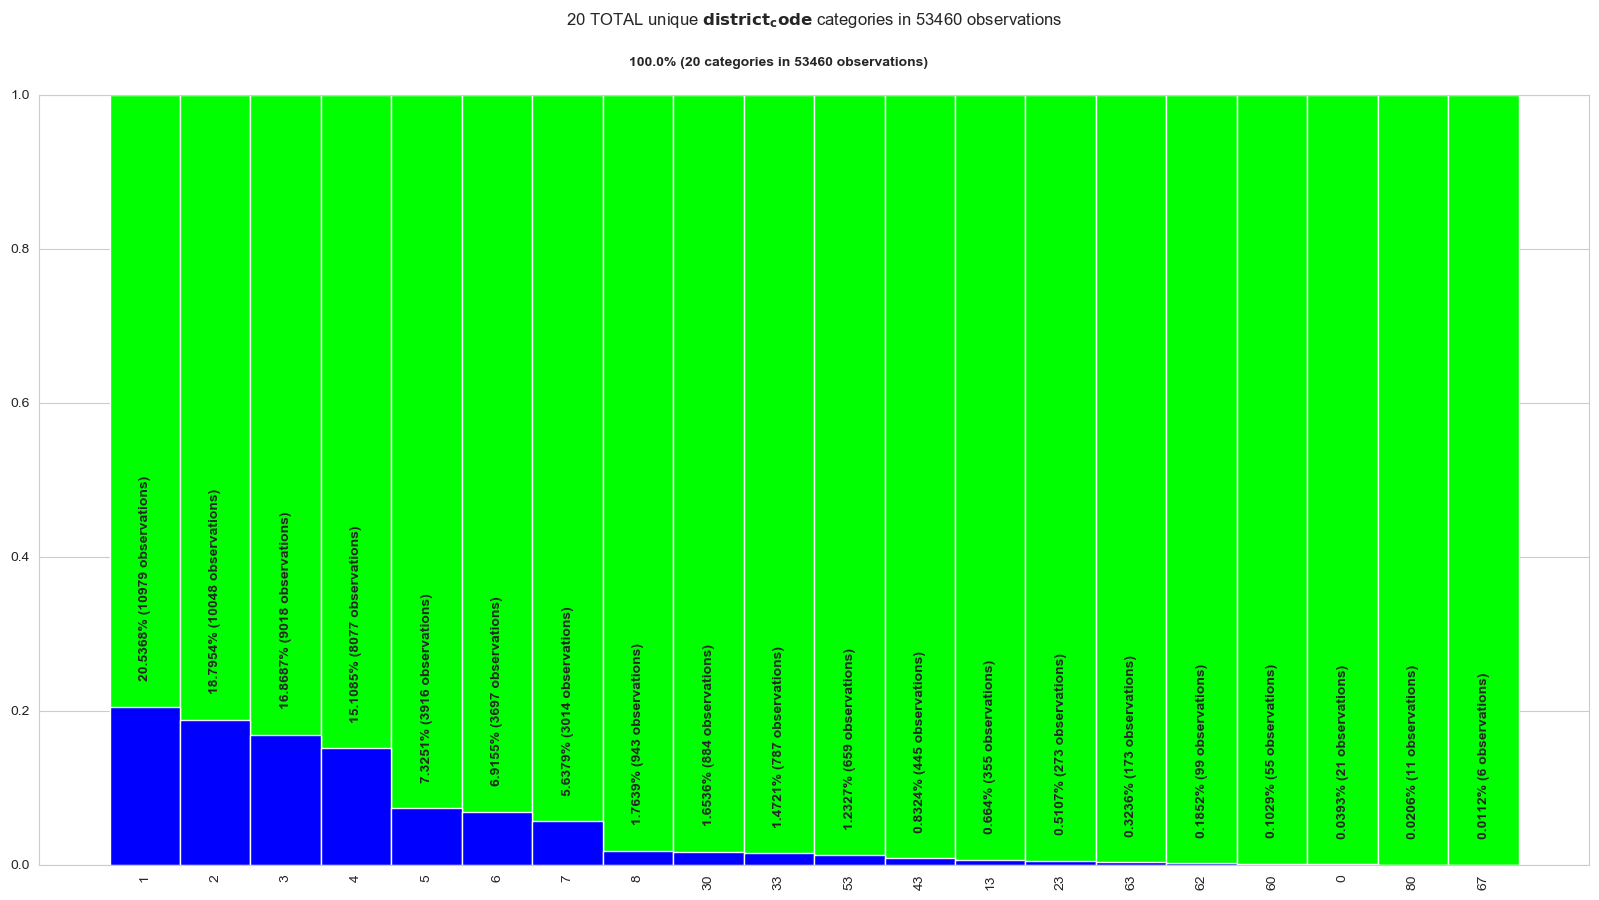

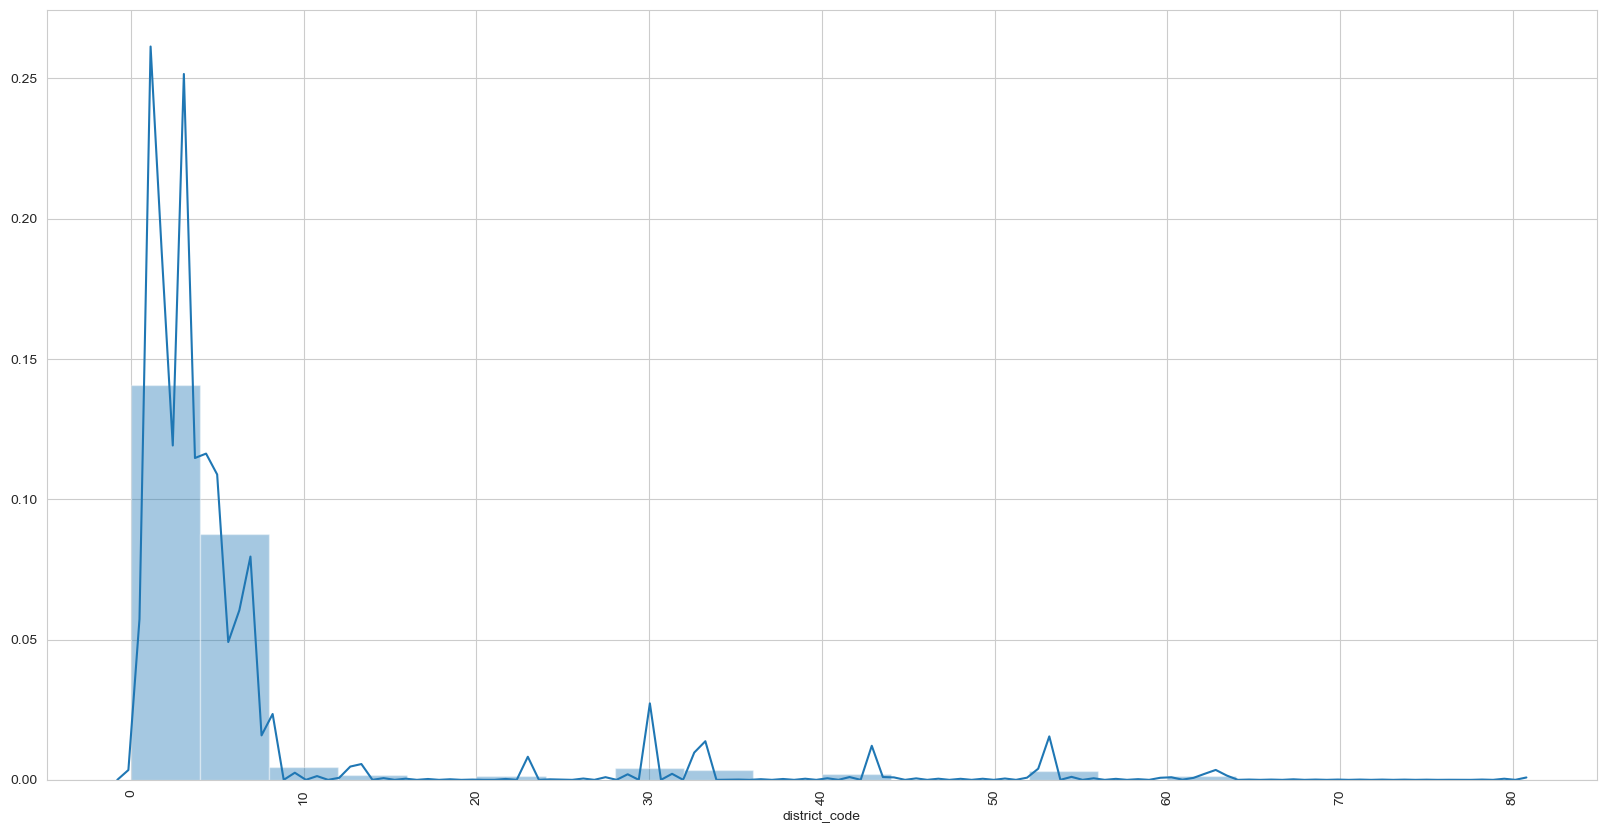

In [142]:
scjpnutils.analyze_distributions(
    X_train, 
    'X_train', 
    'district_code'
);

This feature is good to go.  Remember that if it is used, it must be Target-Encoded.

#### Feature Analysis: *subvillage*, *region*, *lga*, and *ward*

These features represent, in string (name) format, information we already have in the **region_code** and **district_code** features within this group.  

So we can short-circuit analysis.

We will always apply the "drop the feature" strategy to these features in the [proprocessing.ipynb](proprocessing.ipynb) notebook.

<p><br><br>

### Feature grouping *geographic_location* analysis Summary

There are several features in this group: **region_code**, **district_code**, **subvillage**, **region**, **lga**, and **ward**.

As this is a numeric feature with no apparent null-values, there is no *required* preprocessing.

All possible options for preprocessing the **geographic_location** feature are:

1. for **region_code**:
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
    2. Drop the feature
2. for **district_code**:
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
    2. Drop the feature
3. for **subvillage**: Drop the feature
4. for **region**: Drop the feature
5. for **lga**: Drop the feature
6. for **ward**: Drop the feature

Since the categorical-string features in this group will always be dropped (since **region_code** and **district_code** represent the information they contain but numerically) and, since **region_code** and **district_code** contain no null values, there is no required preprocessing (to precede the above options) for this group.

Let's move on to feature grouping <b>population</b>.

<p><br><br>

In [143]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'population', X_train, 'X_train')

#### Feature Analysis: *population*

There are no null/missing values.

It is numeric.  It seems to be categorical-ordinal. 

We might be able to use this feature as is but we ought to consider the continuous case and look for outliers.

Let's have a look at value-counts.

In [144]:
X_train.population.value_counts()

0       19310
1        6327
200      1728
150      1686
250      1511
        ...  
2807        1
726         1
694         1
4788        1
687         1
Name: population, Length: 1019, dtype: int64

And its distribution...

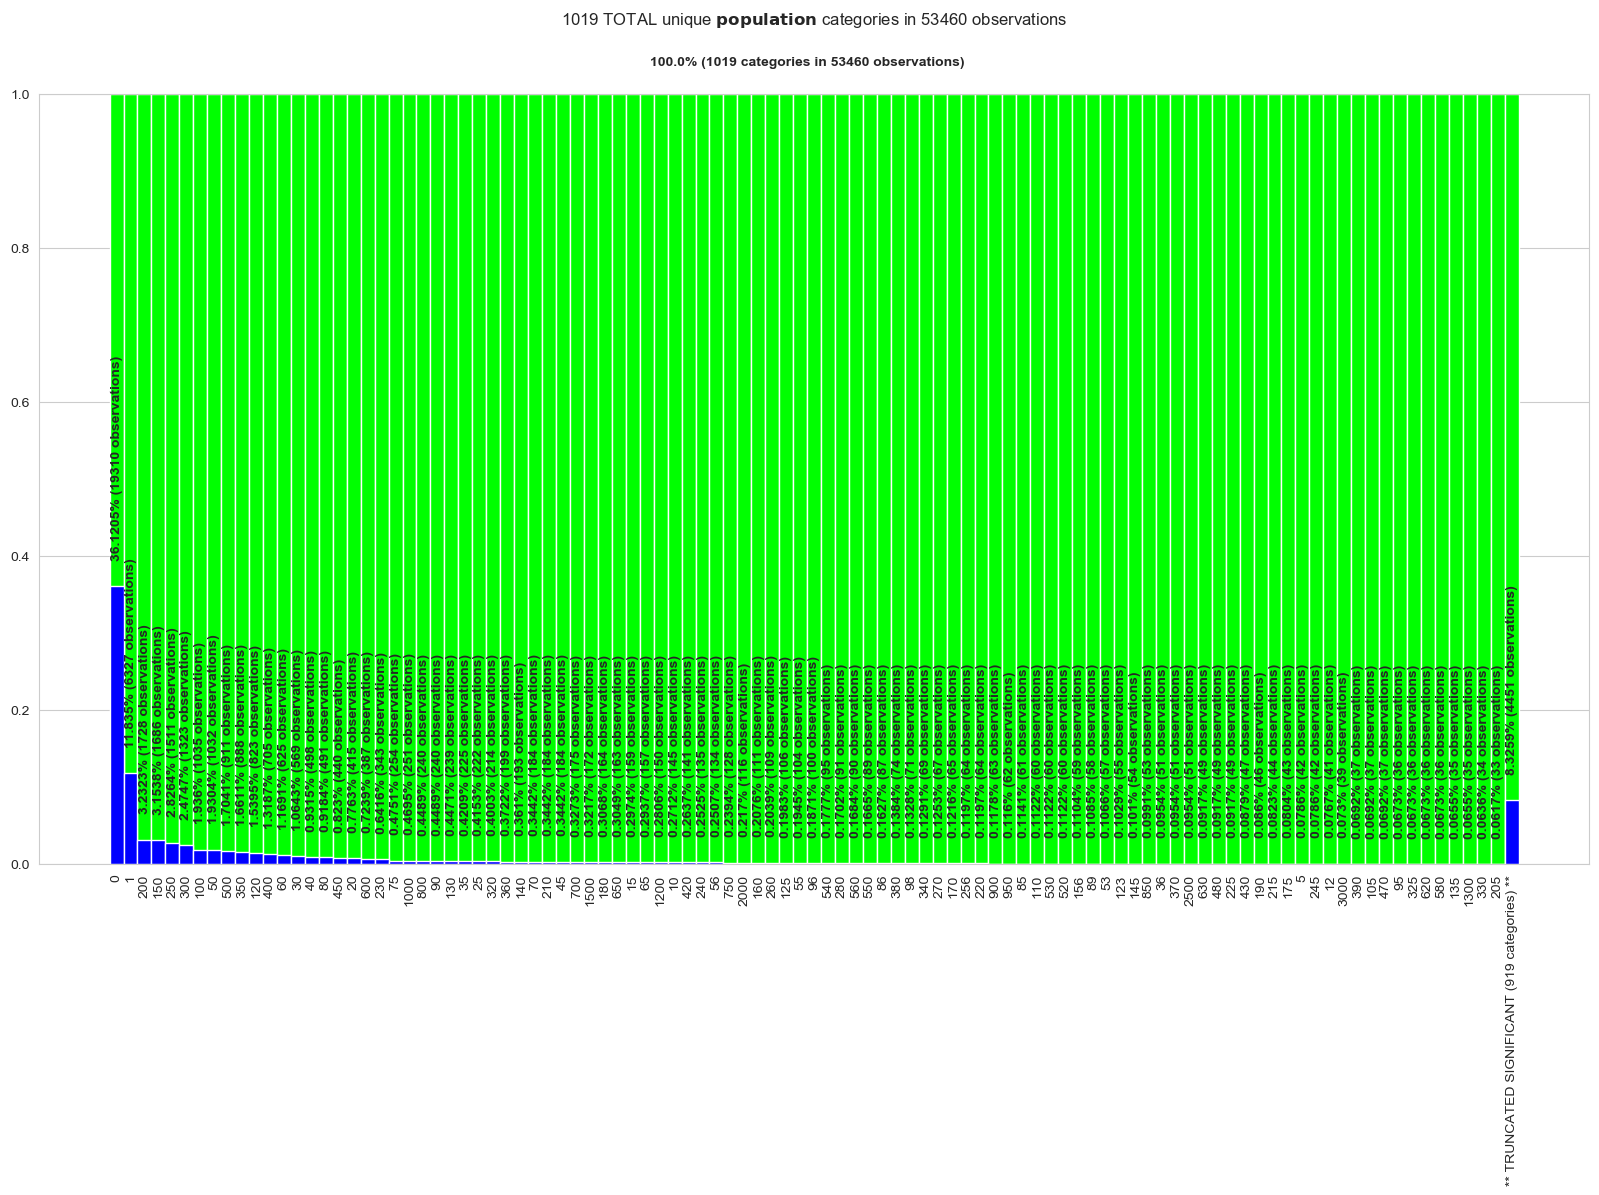

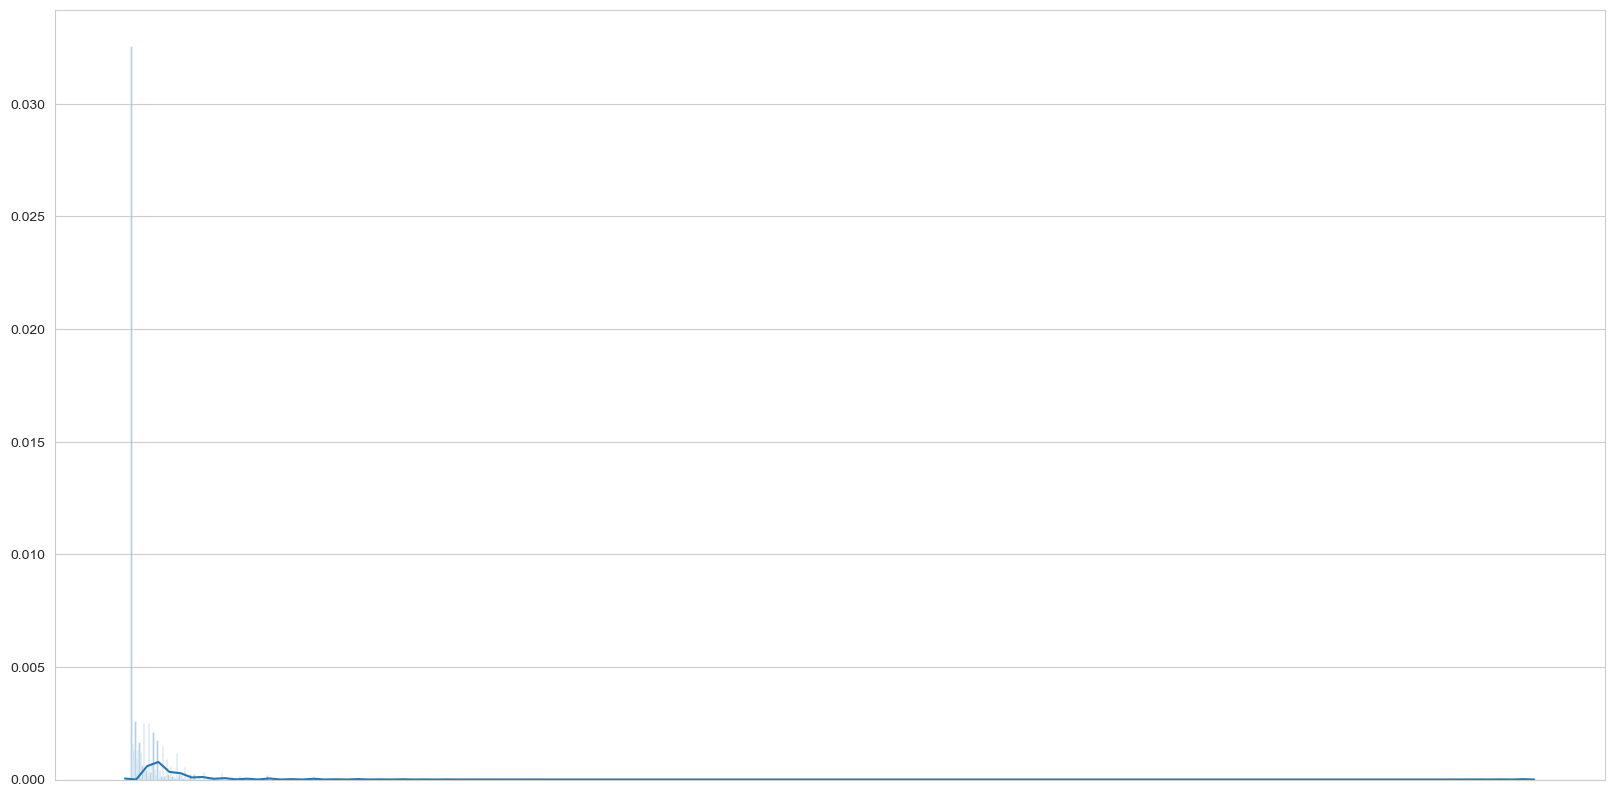

In [145]:
scjpnutils.analyze_distributions(
    X_train, 
    'X_train', 
    'population'
);

One thing to note is that there are many observations with a 0-value.

We must consider the possibility that <b>population</b> is continuous and then look at the outliers scenario.

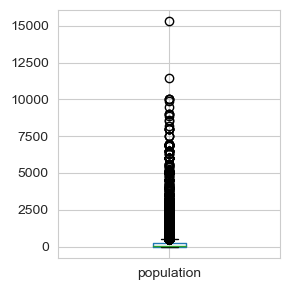

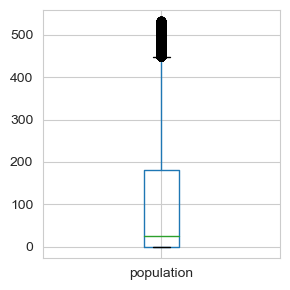

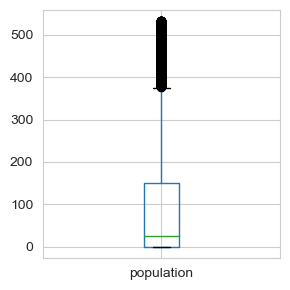

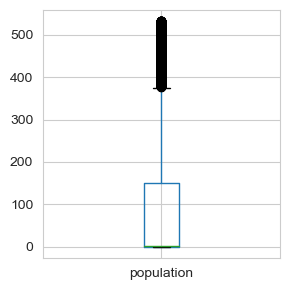

In [146]:
scjpnutils.analyze_outliers_detailed(
    X_train, 
    'X_train', 
    'population', 
    top_percentile=36, 
    outlier_ratio_reduction_threshold=.10
);

If we assume <b>population</b> is continuous, then no strategy above will remove outliers entirely.  We are in a similar with this feature as we were in with **amount_tsh**.

For this feature, we see that replacing outliers with the mean value will improve the situation.

But we haven't officially created `StrategyTransformer` classes for replacing outliers with mean or median yet.

So we'll do that now in order to deploy it as an option in [preprocessing.ipynb](preprocessing.ipynb).

<p><br><br>

### Strategy Development: *Replace outliers* (base strategy)

#### Concept

For the reader, this is no doubt "old hat".  I don't really need to explain the concept here.

But we want to vary the replacement strategy so that we can replace outliers with the *mean*, *median*, or *mode* (as well as possibly some other fixed literal/constant value).

So, this will involve creating a base `StrategyTransformer` (from which specific replacement semantics can be derived).

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__replace_outliers__StrategyTransformer`

The first thing this class must do is find outliers.

Therefore, this class simply wraps the function `analyze_outliers_detailed` which we have already judiciously applied througout this project.

The `analyze_outliers_detailed` function was purposefully written to return dictionaries containing *replacement_rules* for each of the *mean*, *median*, or *mode* methods, which are meant to be used with the `SimpleValueTransformer`.

<p><br><br>

### Strategy Development: *Replace outliers with <u>mean</u>*

#### Concept

Same as above, but with *mean* as the specific replacement strategy.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__replace_outliers_with_mean__StrategyTransformer`

This class simply derives from the `C__replace_outliers__StrategyTransformer` and specifies *mean* as the replacement strategy.

Simple.


<p><br><br>

### Strategy Development: *Replace outliers with <u>median</u>*

#### Concept

Same as above, but with *median* as the specific replacement strategy.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__replace_outliers_with_median__StrategyTransformer`

This class simply derives from the `C__replace_outliers__StrategyTransformer` and specifies *median* as the replacement strategy.

Equally simple as above.

In [147]:
# for example, replace outliers with mean
replace_outliers_with_mean_strat_transformer__population = scjpnstrattransformers.C__replace_outliers_with_mean__StrategyTransformer(
    'population',
    pipeline_data_preprocessor=None,
    verbose=True
)

X_train_populatation_outliers_replaced_with_mean_transformed = replace_outliers_with_mean_strat_transformer__population.fit_transform(X_train)

strategy "replace "population" outliers with mean" transformation is COMPLETE!


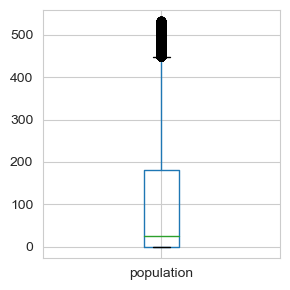

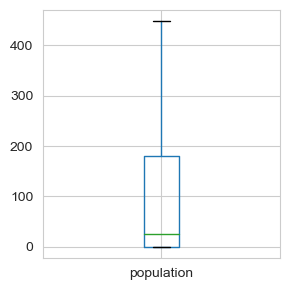

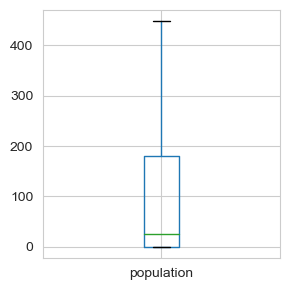

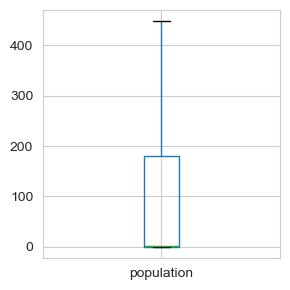

In [148]:
scjpnutils.analyze_outliers_detailed(
    X_train_populatation_outliers_replaced_with_mean_transformed, 
    'X_train_populatation_outliers_replaced_with_mean_transformed', 
    'population', 
    top_percentile=36, 
    outlier_ratio_reduction_threshold=.10
);

We see that by applying this `StrategyTransformer`, we end up with the same result provided by the first execution of `analyze_outliers_detailed` in this section - i.e. it works.

What is interesting is that the output/analysis produced by using this (basically, just running `analyze_outliers_detailed` and following its suggestion and using the dict it returns as replacement_rules) suggests that applying another round using the same strategy will result in 0 outliers.

We might actually consider doing this to see how it turns out in model building!

<p><br><br>

### Feature grouping *population* analysis Summary

There is obviously only one feature in this group: **population**.

As this is a numeric feature with no apparent null-values, there is no *required* preprocessing.

But, analysis above suggests this is a continuous feature, rather than categorical-ordinal.

It has outliers which ought to be dealt with.

Even so, we still allow for the consideration/treatment as a categorical-ordinal variable, which means we consider Target-Encoding as an option.

This consideration will likely not produce better results than a continuous treatment will, but we do at least allow for this as a possible strategy to execute in [preprocessing.ipynb](preprocessing.ipynb).

Therefore, all possible options for preprocessing the **population** feature are:

1. Leave the feature as is (do nothing, no transformations whatsoever)
2. Target-encode it - this feature *appears* to be categorical (but ordinal); since, if categorical, it is ordinal, we might consider that the size between values is not properly mathematically meaningful; if this is the case, target encoding could help this in modeling
    1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set) - in this case, `nan` values occur (after target encoding is applied) in the validation and unlabeled transformed data sets when categories not seen in training are observed; thus a mapping from training is not possible; a `nan` value therefore would exclude the observation when modeling; mapping to the global mean counters this
    2. Regular (NOT Leave-One-Out) target encoding with `nan` values are left as is - i.e. NOT mapped to the global mean of the fit target (from the training set); note that this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
    3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
    4. (Leave-One-Out) target encoding with `nan` values left as is; again, this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
3. Replace 0-values with `nan` so that the feature is effectively ignored in the model for would-be 0-values - this technique is employed if we treat the feature as purely continuous, in an effort to deal with the lopsided distribution toward 0; the effect is for the model to consider only non-zero values as relevant in modeling; again, this precludes the use of tree-based classifiers incapable of handling `nan` values - i.e. `DecisionTreeClassifier` and `RandomForesetClassifier` - thus, we only use `XGBClassifier` in this case
4. Replace outliers with mean (one round)
6. Replace outliers with mean (two rounds)
4. Drop the feature - again, if we consider the feature as continuous, this is another way of handling it

Based on the analysis in this section, it seems likely that the best strategy to employ is using `C__replace_outliers_with_mean__StrategyTransformer` (one round).  Two rounds of the same will be tested out of curiosity (in addition to the other strategies above).

Let's move on to feature grouping <b>public_meeting</b>.

<p><br><br>

In [149]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'public_meeting', X_train, 'X_train')

#### Feature Analysis: *public_meeting*

There are null/missing values we must deal with.  We will replace null/missing values with `False`.

Doing this will also implicitly convert it to its proper type (`bool`).

In [150]:
# val counts before replacing nulls
X_train.public_meeting.value_counts(normalize=True)

True     0.909759
False    0.090241
Name: public_meeting, dtype: float64

In [151]:
replace_null_rules = {'public_meeting': [{'missing_values': np.nan, 'strategy': 'constant', 'fill_value': False}]}
svt_null_public_meeting = SimpleValueTransformer(replace_null_rules)
X_train_nulls_replaced__public_meeting = svt_null_public_meeting.transform(X_train)

In [152]:
X_train_nulls_replaced__public_meeting.public_meeting.value_counts(normalize=True)

True     0.858605
False    0.141395
Name: public_meeting, dtype: float64

<p><br><br>

### Strategy Development: *Execute all required preprocessing transformations on public_meeting (feature group)*

#### Concept

The concept follows from all preceding transformations in this section.

All of the above preprocessing steps represent minimal "required" steps to do further processing.  Any additional preprocessing must always follow the above preprocessing.  Therefore, all steps above have been encapsulated within a single class: `C__required_proprocessing__public_meeting__StrategyTransformer`.  

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__public_meeting__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the preceding discussion.

<p><br><br>

### Feature grouping *public_meeting* analysis Summary

There is obviously only one feature in this group: **public_meeting**.

This is a simple boolean categorical.

Therefore, all possible options for preprocessing the **public_meeting** feature are:

0. Use the feature in the model (in which case `C__required_proprocessing__public_meeting__StrategyTransformer` must be executed)
1. Drop the feature

**If it is kept, any subsequent processing must be preceded by `C__required_proprocessing__public_meeting__StrategyTransformer`**.

It is not clear from analysis which option is likely best but intuition suggests this feature should not impact mechanical failure of a well/pump... UNLESS for some reason the meeting is held AT THE PUMP location itself... more foot-traffic in this case means a greater likelihood some individual can break something?  It's a stretch but it certainly is possible, albeit very unlikely.  (HINT: This feature is probably irrelevant to pump failure.)

Let's move on to feature grouping <b>recorded_by</b>.

<p><br><br>

In [153]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'recorded_by', X_train, 'X_train')

#### Feature Analysis: *recorded_by*

This feature is obviously non-contributing since it contains only 1 unique value.

We will always drop it (via `C__drop_it__StrategyTransformer`).

Let's move on to feature grouping <b>wpt_operator</b>.

<p><br><br>

In [154]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'wpt_operator', X_train, 'X_train')

#### Feature Analysis: *scheme_management*

We need to deal with its null/missing values.

As usual, we'll first imput lower-case and then check for existing "none"-type categories.

In [155]:
ft_impute_lcase_scheme_management = FunctionTransformer(lambda X: scjpnutils.impute_TO_lcase(X, 'scheme_management'), validate=False)
X_train_scheme_management_lcase = ft_impute_lcase_scheme_management.fit_transform(X_train)

# finally, check to see if there is an appropriate existing value in X_labeled.funder to indicate null - e.g. 'none', 'unknown', 'not known', etc.
scjpnutils.index_of_values(X_train_scheme_management_lcase, 'X_train_scheme_management_lcase', 'scheme_management', ['none', 'unknown', 'not known'])

(array([15899]), array(['none'], dtype=object))

So we will not need to create a new category to replace null/missing values...

In [156]:
replace_null_rules = {'scheme_management': [{'missing_values': np.nan, 'strategy': 'constant', 'fill_value': 'none'}]}
svt_null_scheme_management = SimpleValueTransformer(replace_null_rules)
X_train_scheme_management_transformed = svt_null_scheme_management.fit_transform(X_train_scheme_management_lcase)

<p><br><br>

### Strategy Development: *Execute all required preprocessing transformations on scheme_management*

#### Concept

The concept follows from all preceding transformations in this section.

All of the above preprocessing steps represent minimal "required" steps to do further processing.  Any additional preprocessing must always follow the above preprocessing.  Therefore, all steps above have been encapsulated within a single class: `C__required_proprocessing__scheme_management__StrategyTransformer`.  

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__scheme_management__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the preceding discussion.

And now its distribution...

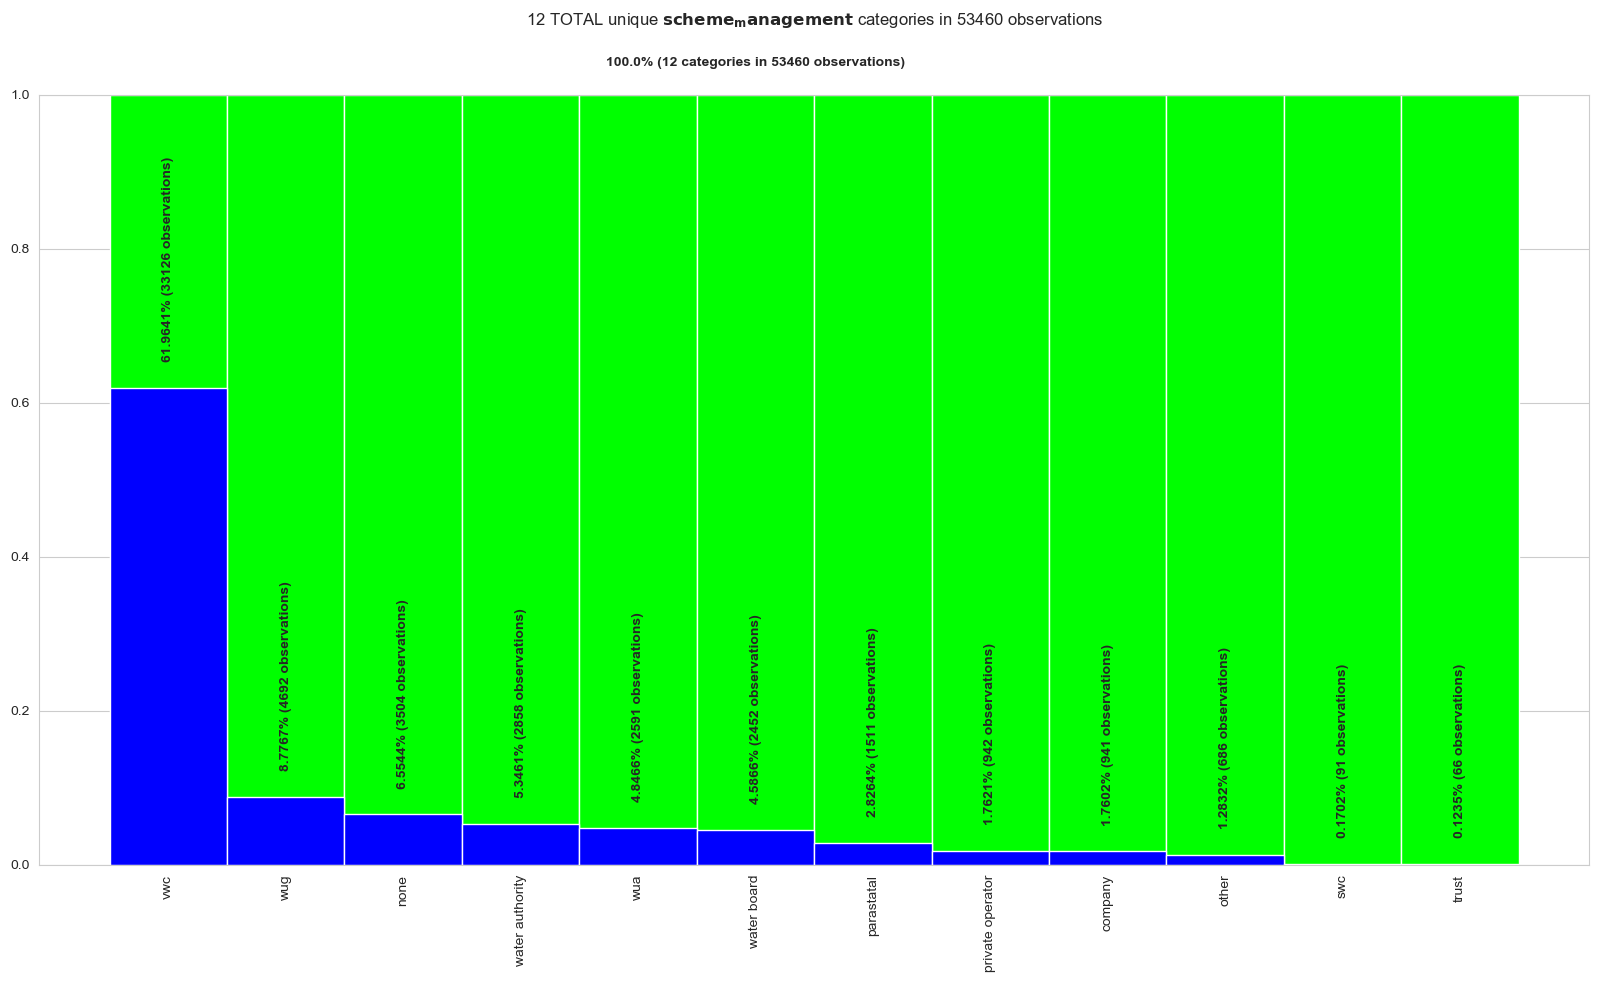

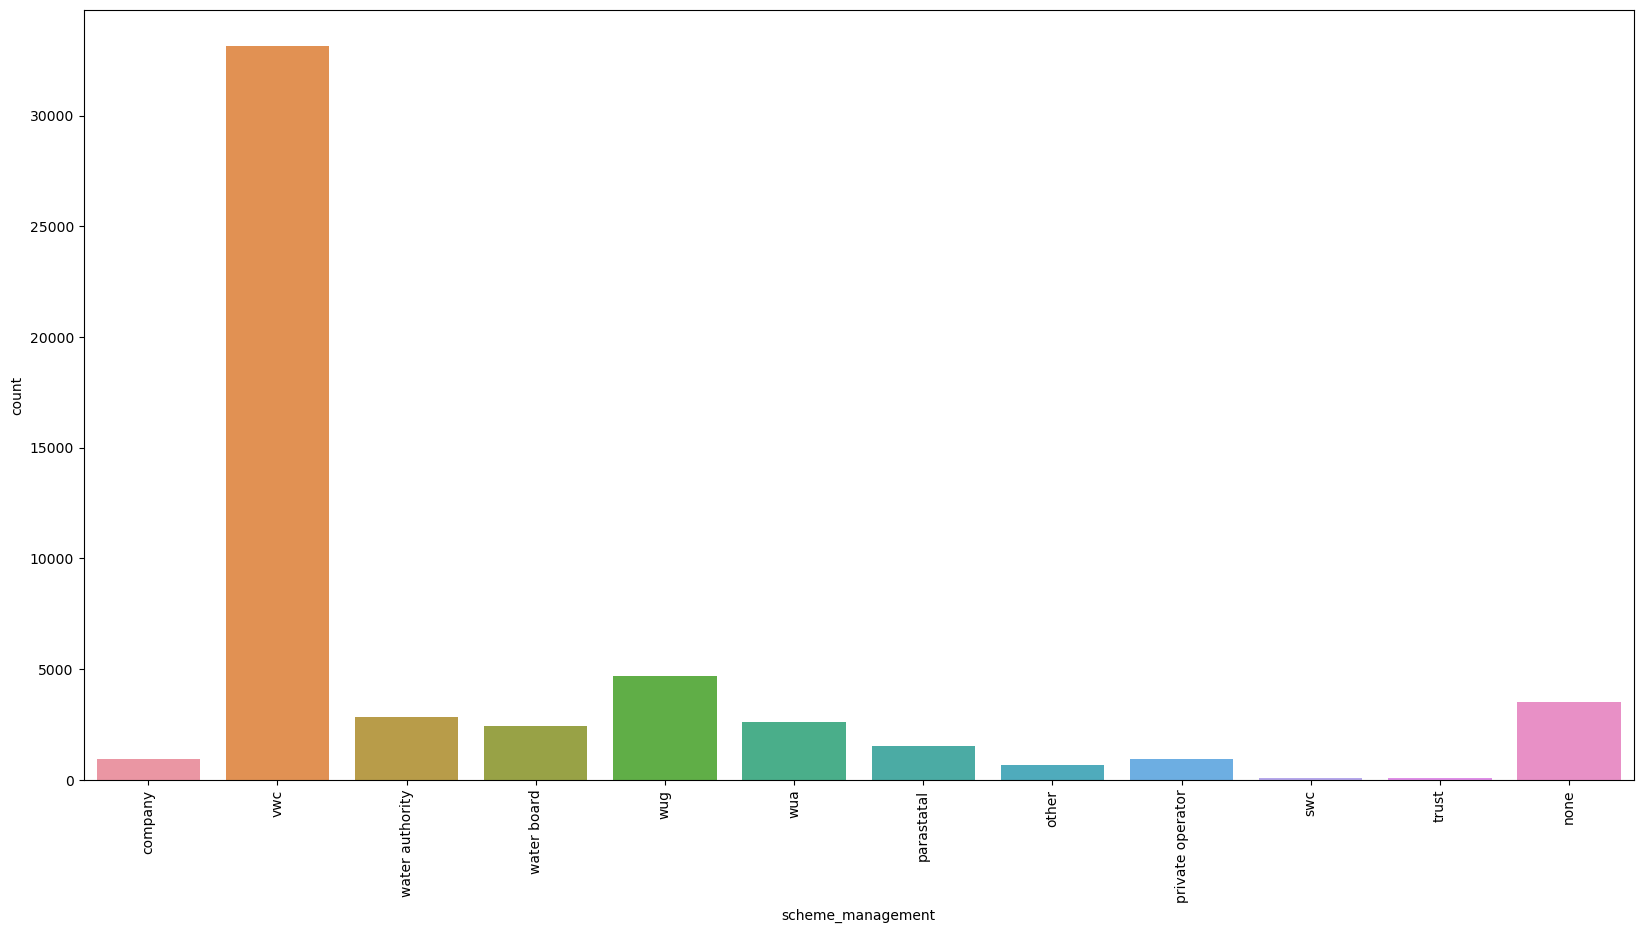

In [157]:
scjpnutils.analyze_distributions(
    X_train_scheme_management_transformed, 
    'X_train_scheme_management_transformed', 
    'scheme_management'
);

If kept, **scheme_management** must be target-encoded (after required processing via `C__required_proprocessing__scheme_management__StrategyTransformer`).

#### Feature Analysis: *scheme_name*

We need to deal with its null/missing values.

As usual, we'll first imput lower-case and then check for existing "none"-type categories.

In [158]:
ft_impute_lcase_scheme_name = FunctionTransformer(lambda X: scjpnutils.impute_TO_lcase(X, 'scheme_name'), validate=False)
X_train_scheme_name_lcase = ft_impute_lcase_scheme_name.fit_transform(X_train)

# finally, check to see if there is an appropriate existing value to indicate null - e.g. 'none', 'unknown', 'not known', etc.
scjpnutils.index_of_values(X_train_scheme_name_lcase, 'X_train_scheme_name_lcase', 'scheme_name', ['none', 'unknown', 'not known'])

(array([   60,    71,    98,   101,   119,   158,   255,   278,   301,
          392,   421,   437,   508,   583,   593,   595,   612,   625,
          644,   683,   749,   773,   883,  1007,  1021,  1026,  1093,
         1170,  1174,  1176,  1202,  1322,  1342,  1387,  1503,  1626,
         1685,  1723,  1862,  1863,  1877,  1894,  1918,  1956,  1971,
         2018,  2037,  2088,  2311,  2438,  2450,  2523,  2559,  2570,
         2625,  2650,  2651,  2678,  2737,  2771,  2807,  2914,  3044,
         3088,  3136,  3186,  3189,  3202,  3208,  3263,  3278,  3311,
         3318,  3356,  3518,  3529,  3533,  3552,  3615,  3628,  3634,
         3636,  3677,  3689,  3716,  3817,  3820,  3827,  3917,  3978,
         3997,  4032,  4158,  4165,  4180,  4239,  4309,  4366,  4415,
         4473,  4511,  4568,  4590,  4610,  4653,  4667,  4704,  4735,
         4774,  4901,  4974,  5080,  5105,  5310,  5313,  5337,  5359,
         5375,  5422,  5428,  5490,  5504,  5541,  5564,  5590,  5661,
      

We will replace null/missing values with "none".

We will replace "not known" with "unknown".

In [159]:
replace_null_rules = {'scheme_name': [{'missing_values': np.nan, 'strategy': 'constant', 'fill_value': 'none'}]}
svt_null_scheme_name = SimpleValueTransformer(replace_null_rules)
X_train_scheme_name_transformed = svt_null_scheme_name.fit_transform(X_train_scheme_name_lcase)

In [160]:
replace_same_concept_words = {'scheme_name': [{'missing_values': "not known", 'strategy': 'constant', 'fill_value': "unknown"}]}
svt_not_known_scheme_name = SimpleValueTransformer(replace_same_concept_words)
X_train_scheme_name_transformed = svt_null_scheme_name.fit_transform(X_train_scheme_name_transformed)

<p><br><br>

### Strategy Development: *Execute all required preprocessing transformations on scheme_name*

#### Concept

The concept follows from all preceding transformations in this section.

All of the above preprocessing steps represent minimal "required" steps to do further processing.  Any additional preprocessing must always follow the above preprocessing.  Therefore, all steps above have been encapsulated within a single class: `C__required_proprocessing__scheme_name__StrategyTransformer`.  

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__scheme_name__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the preceding discussion.

And now the distribution...

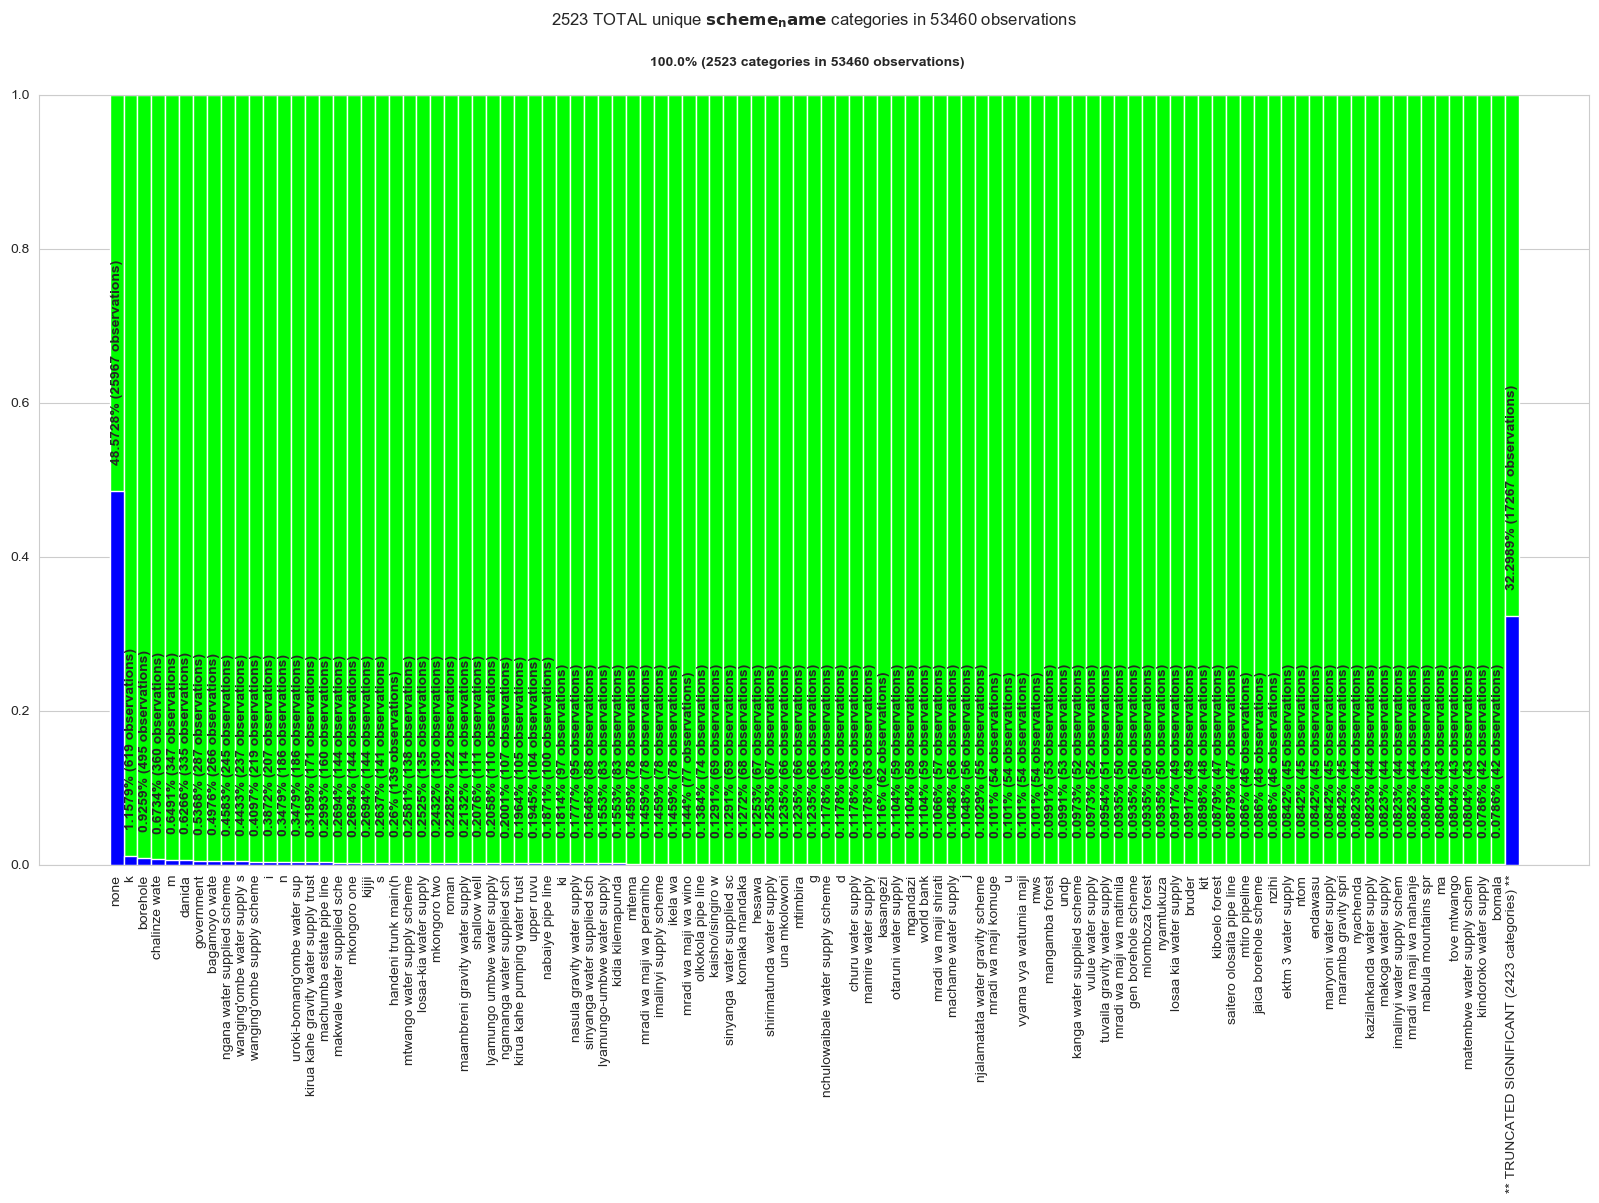

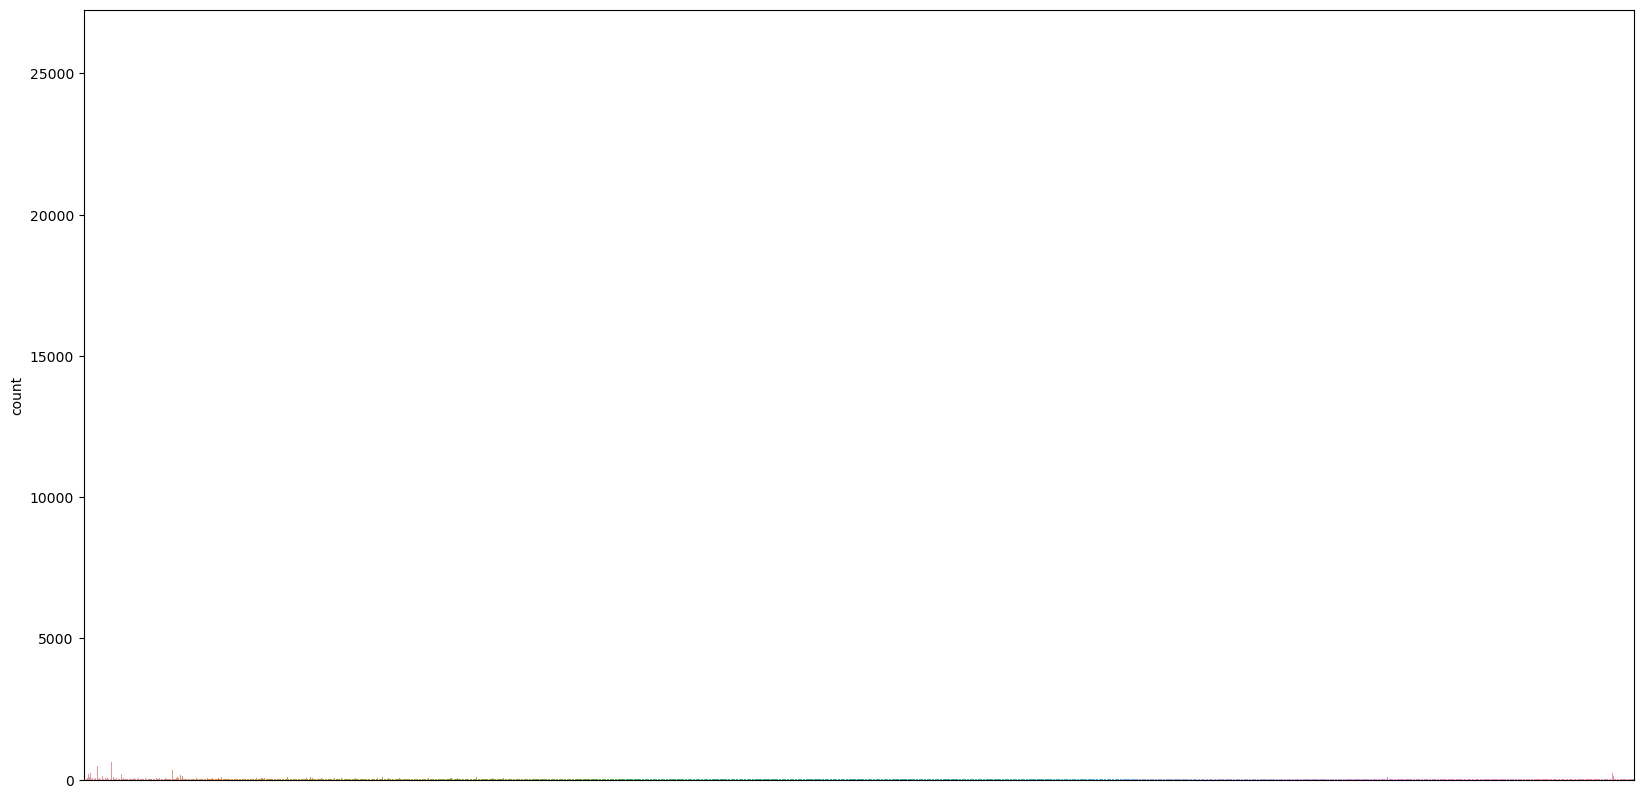

In [161]:
scjpnutils.analyze_distributions(
    X_train_scheme_name_transformed, 
    'X_train_scheme_name_transformed', 
    'scheme_name'
);

Like **funder** and **installer**, **scheme_name** is also a high-cardinality string-categorical.

Let's see how bad duplication is, as a guide in determining whether we should similarly consider `C__tfidf_kmeans_classify__StrategyTransformer` as an option.

In [162]:
scjpnutils.analyze_non_alphanumeric_strings(X_train_scheme_name_transformed[['scheme_name']], 'X_train_scheme_name_transformed <i>scheme_name</i>');

YIKES!  There appears to be much duplication.  We will definitely be consider `C__tfidf_kmeans_classify__StrategyTransformer` as an option.

As a high-cardinality categorical, we of course additionally consider the `C__top_n_significance__StrategyTransformer` strategy developed in the **funder** section.

<p><br><br>

### Feature grouping *wpt_operator* analysis Summary

There are two features in this group: **scheme_management** and **scheme_name**.

**scheme_management** is a relatively low-cardinality string-categorical; so we do NOT consider "`TF-IDF KMeans` Classify it" as an option.

**scheme_name** is a high-cardinality string-categorical; so we DO consider "`TF-IDF KMeans` Classify it" as an option (as well as the other high-cardinality-categorical preprocessing options).

We consider Target-Encoding as an option for both.

Thus, all possible strategic options are:

1. for **scheme_management**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **scheme_name**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
    2. `TF-IDF KMeans` Classify it - **since this results in numeric labels, the result MUST be target-encoded**
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is  
    3. `TF-IDF` Normalize it (find and replace duplicates using Cosine Similarity of `TF-IDF` vectorized categories - **since this results in numeric labels, the result MUST be target-encoded**
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is 
    4. Consider only the *top n* (by frequency) significant categories
    5. Drop the feature

**If anything other than the "drop the feature" strategy is used for *scheme_management* then it must be preceded by `C__required_proprocessing__scheme_management__StrategyTransformer`**.

**If anything other than the "drop the feature" strategy is used for *scheme_name* then it must be preceded by `C__required_proprocessing__scheme_name__StrategyTransformer`**.


Again, executing these options is conducted in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to feature grouping <b>permit</b>.

<p><br><br>

In [163]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'permit', X_train, 'X_train')

#### Feature Analysis: *permit*

This situation with this feature is pretty much identical to that of **public_meeting**.

So we will shortcircuit a detailed analysis and apply the same results of the conclusion thereof.

<p><br><br>

### Strategy Development: *Execute all required preprocessing transformations on permit (feature group)*

#### Concept

The concept follows from all preceding transformations in the **public_meeting** section.

All of the preprocessing steps therein represent minimal "required" steps to do further processing.  Any additional preprocessing must always follow the above preprocessing.  Therefore, all steps above have been encapsulated within a single class: `C__required_proprocessing__permit__StrategyTransformer`.  

Development of the implementation is as follows.

<p><br>

#### Implementation Details of `StrategyTransformer` class: `C__required_proprocessing__permit__StrategyTransformer`

The class simply encapsulates the sequence of transformations from the **public_meeting** discussion.

<p><br><br>

### Feature grouping *permit* analysis Summary

There is obviously only one feature in this group: **permit**.

Like **public_meeting**, this feature is a simple boolean categorical.

Therefore, all possible options for preprocessing the **permit** feature are:

0. Use the feature in the model (in which case `C__required_proprocessing__permit__StrategyTransformer` must be executed)
1. Drop the feature

**If it is kept, any subsequent processing must be preceded by `C__required_proprocessing__permit__StrategyTransformer`**.

It is not clear from analysis which option is likely best but intuition suggests this feature should not impact mechanical failure of a well/pump... UNLESS for some reason having a permit somehow garners some sort of maintenance schedule?  Again, it's a stretch but it certainly is possible, albeit very unlikely.  (HINT: This feature is probably irrelevant to pump failure.)

Let's move on to feature grouping <b>wpt_extraction_type_class</b>.

<p><br><br>

In [164]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'wpt_extraction_type_class', X_train, 'X_train')

No feature contains any null/missing values.

These are relatively low-cardinality string-categorical features that seem to have some overlap.  Let's formalize this overlap-analysis.

In [165]:
scjpnutils.analyze_overlap(
    'wpt_extraction_type_class', 
    feat_groupings['wpt_extraction_type_class']['features'], 
    'X_train', 
    X_train,
    suppress_value_analysis_output=True
)

Overlap analysis suggests that **extraction_type** is the superset.

Therefore, we can commit to employing the "drop the feature" strategy on the other two: **extraction_type_group** and **extraction_type_class**.

As for **extraction_type**, since it contains no null/missing values, there is technically no *required* preprocessing to execute on it.

Thus, we require the development of no new `StrategyTransformer`s.

<p><br><br>

### Feature grouping *wpt_extraction_type_class* analysis Summary

There three features in this group: **extraction_type**, **extraction_type_group**, and **extraction_type_class**.

These features all contain overlapping/duplicate information for each observation, with **extraction_typ** being the superset of the three.

Therefore, all possible options for preprocessing the **wpt_extraction_type_class** feature group are:

1. for **extraction_type**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **extraction_type_group**: Drop the feature
3. for **extraction_type_class**: Drop the feature

So the only path to really fork on is deciding how exectly to handle **extraction_type**.  Based on the description for this group, "the kind of extraction the waterpoint uses", inuitively speaking, this seems like a fairly important feature grouping.  Thus, dropping **extraction_type** is likely not the best option.  This leaves us with only one real path to take.  Analysis suggests the best option should be to Target-Encode **extraction_type**.  

As usual, though, we will explore these paths in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to feature grouping <b>wpt_management</b>.

<p><br><br>

In [166]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'wpt_management', X_train, 'X_train')

This feature grouping follows the same pattern as the **wpt_extraction_type_class** feature grouping.

No feature contains any null/missing values.

These are relatively low-cardinality string-categorical features that seem to have some overlap.  Let's formalize this overlap-analysis.

In [167]:
scjpnutils.analyze_overlap(
    'wpt_management', 
    feat_groupings['wpt_management']['features'], 
    'X_train', 
    X_train,
    suppress_value_analysis_output=True
)

It turns out the population does not actually manifest much *strict* (read: literal) overlap.  But, semantically speaking, it is clear that information is duplicated by these categorites.

We will therefore settle on keeping **management** since it is the semantic superset and employing the "drop the feature" strategy on the other feature: **management_group**.

As for **management**, since it contains no null/missing values, there is technically no *required* preprocessing to execute on it.

Thus, we require the development of no new `StrategyTransformer`s.

<p><br><br>

### Feature grouping *wpt_management* analysis Summary

There two features in this group: **management** and **management_group**.

These feature don't overlap in a strict, literal sense but, semantically, they do with **management** as the superset. 

Therefore, all possible options for preprocessing the **wpt_management** feature group are:

1. for **management**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **management_group**: Drop the feature

Analysis suggests the best option should be to Target-Encode **management**.  

As usual, though, we will explore these paths in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to feature kind <b>payment_frequency_class</b>.

<p><br><br>

In [168]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'payment_frequency_class', X_train, 'X_train')

The overlap is clear.

In [169]:
scjpnutils.analyze_overlap(
    'payment_frequency_class', 
    feat_groupings['payment_frequency_class']['features'], 
    'X_train', 
    X_train,
    suppress_value_analysis_output=True
)

Since these are basically semantically identical, we will go with the less wordy one: <b>payment_type</b>.

<p><br><br>

### Feature grouping *payment_frequency_class* analysis Summary

There two features in this group: **payment** and **payment_type**.

The categories in each are virtually identical with one being a bit more wordy than the other. 

Therefore, all possible options for preprocessing the **payment_frequency_class** feature group are:

1. for **payment_type**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **payment**: Drop the feature

Analysis suggests the best option should be to Target-Encode **payment_type**.  

As usual, though, we will explore these paths in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to feature grouping <b>water_quality_class</b>.

<p><br><br>

In [170]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'water_quality_class', X_train, 'X_train')

Again, the overlap is clear and there are no null/missing values...

In [171]:
scjpnutils.analyze_overlap(
    'water_quality_class', 
    feat_groupings['water_quality_class']['features'], 
    'X_train', 
    X_train,
    suppress_value_analysis_output=True
)

**water_quality** is the superset.  We must note that "soft" is equivalent to "good" in the superset but it is pointless to replace it since, if we keep this feature in the model, it must be target-encoded anyway.

<p><br><br>

### Feature grouping *water_quality_class* analysis Summary

There two features in this group: **quality_group** and **water_quality**.

Therefore, all possible options for preprocessing the **water_quality_class** feature group are:

1. for **water_quality**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **quality_group**: Drop the feature

Analysis suggests the best option should be to Target-Encode **water_quality**.  

As usual, though, we will explore these paths in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to feature kind <b>water_quantity_class</b>.

<p><br><br>

In [172]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'water_quantity_class', X_train, 'X_train')

Wow!  Do we even need to bother checking overlap officially?  These features already appear to be identical in every response but, again, let's formalize that.

In [173]:
scjpnutils.analyze_overlap(
    'water_quantity_class', 
    feat_groupings['water_quantity_class']['features'], 
    'X_train', 
    X_train,
    suppress_value_analysis_output=True
)

So they are identical in every observation!

We will go with **quantity** based solely on its shorter name.

<p><br><br>

### Feature grouping *water_quantity_class* analysis Summary

There two features in this group: **quantity** and **quantity_group**.

Therefore, all possible options for preprocessing the **water_quantity_class** feature group are:

1. for **quantity**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **quantity_group**: Drop the feature

Analysis suggests the best option should be to Target-Encode **quantity**.  

As usual, though, we will explore these paths in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to feature kind <b>water_source_type_class</b>.

<p><br><br>

In [174]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'water_source_type_class', X_train, 'X_train')

No feature contails null/missing values.

The overlapping situation is not so obvious here.  Let's formalize it.

In [175]:
scjpnutils.analyze_overlap(
    'water_source_type_class', 
    feat_groupings['water_source_type_class']['features'], 
    'X_train', 
    X_train,
    suppress_value_analysis_output=True
)

**source** is the superset.

<p><br><br>

### Feature grouping *water_source_type_class* analysis Summary

There three features in this group: **source**, **source_type**, and **source_class**.

Therefore, all possible options for preprocessing the **water_source_type_class** feature group are:

1. for **source**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **source_type**: Drop the feature
3. for **source_class**: Drop the feature

Analysis suggests the best option should be to Target-Encode **source**.  

As usual, though, we will explore these paths in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

Let's move on to the FINAL feature grouping <b>wpt_type_class</b>.

<p><br><br>

In [176]:
scjpnutils.display_feature_grouping_header(feat_groupings, 'wpt_type_class', X_train, 'X_train')

No null/missing values.

**waterpoint_type** is the superset.

In [177]:
scjpnutils.analyze_overlap(
    'wpt_type_class', 
    feat_groupings['wpt_type_class']['features'], 
    'X_train', 
    X_train,
    suppress_value_analysis_output=True
)

<p><br><br>

### Feature grouping *wpt_type_class* analysis Summary

There two features in this group: **waterpoint_type** and **waterpoint_type_group**.

Therefore, all possible options for preprocessing the **wpt_type_class** feature group are:

1. for **waterpoint_type**:
    0. The "leave as is" strategy is NOT an option since this is a categorical-string feature and MUST be dealt with somehow (dropping this feature is a viable option).
    1. Target-encode it
        1. Regular (NOT Leave-One-Out) target encoding with `nan` values mapped to the global mean of the fit target (from the training set)
        2. Regular (NOT Leave-One-Out) target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier`
        3. Leave-One-Out target encoding with `nan` values mapped to the global mean of the fit target
        4. Leave-One-Out target encoding with `nan` values left as is - again this would preclude the use of `DecisionTreeClassifier` and `RandomForesetClassifier` 
    2. Drop the feature
2. for **waterpoint_type_group**: Drop the feature

Analysis suggests the best option should be to Target-Encode **waterpoint_type**.  

As usual, though, we will explore these paths in the [preprocessing.ipynb](preprocessing.ipynb) notebook.

<p><br>
    
## Conclusion
    
And that's it!  We now have everything we need to systematically find the best preprocessing options in the [preprocessing.ipynb](preprocessing.ipynb) notebook.
    
See you there!